In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

In [5]:

def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [6]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Select dataset

In [7]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# ----------------------------------------------------------------------------------------------------
# Aggregate projection results
This is output of classifications/aggregate_gradient_estimates()


In [8]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    return

## Set analysis parameters

In [9]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'
fit_thr=0.5
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)

#### Filter RF datasets by
rf_filter_by='drop_repeats'

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr

##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)


pixels_thr-0.003


In [10]:
# Set data identifiers

retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|retinobar-%s|rfs-%s' % (fov_type, state, magthr_str, rf_fit_desc)
print(data_id)


zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-fit-2dgaus_dff-no-cutoff


# Set output dirs

In [11]:
gradient_dir = os.path.join(aggr_dir, 'retinotopy', 'gradient_analysis')

if not os.path.exists(gradient_dir):
    os.makedirs(gradient_dir)
gradient_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis'

In [12]:
dst_dir = os.path.join(gradient_dir, 'pass_%s' % pass_criterion)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels'

# Load datasets

In [13]:
# Get datasets that have BOTH rfs and retinogradient measured
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
bothdata = pd.concat([g for s, g in sdata.groupby(['animalid', 'session', 'fov']) \
                        if ('retino' in sdata['experiment'].values) and \
                        ('rfs' in sdata['experiment'].values or 'rfs10' in sdata['experiment'].values)])
bothdata['datakey'] = ['_'.join([session, animalid, 'fov%i' % fovnum]) \
                         for (session, animalid, fovnum) in bothdata[['session', 'animalid', 'fovnum']].values]

common_datakeys = bothdata['datakey'].unique()

In [14]:
bothdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 26       26   26
Lm                 22       22   22
V1                 18       18   18

In [15]:
retdata = bothdata[bothdata['experiment']=='retino'].copy()
print("N retinobar experiment fovs:")
print(retdata.groupby(['visual_area']).count())

N retinobar experiment fovs:
             animalid  experiment  fov  session  fovnum  datakey
visual_area                                                     
Li                 23          23   23       23      23       23
Lm                 19          19   19       19      19       19
V1                 15          15   15       15      15       15


In [16]:
print("Threshold info: %s" % magthr_str)
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    
    datakey = '_'.join([session, animalid, fov, retinorun])
    try:
        fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                                'retino_analysis', 'retino_structure', 
                                        'projections_%s.pkl' % magthr_str)) # 'projection_results.pkl'))
        assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))
    except Exception as e:
        errors.append(datakey)
        continue
    proj_fit_paths.append((animalid, session, fov, retinorun, retinoid, fpaths[0]))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

Threshold info: pixels_thr-0.003
skipping, no retino (JC076, 20190502, FOV1_zoom2p0x)
skipping, no retino (JC091, 20191007, FOV1_zoom2p0x)
skipping, no retino (JC092, 20190527, FOV2_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV1_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV3_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV1_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV4_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV3_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV4_zoom2p0x)
60 of 60 paths found


In [17]:
errors

[]

# Load gradient data

In [19]:
# Create dir to copy gradient images to, for visual inspection
copy_images = True

dst = os.path.join(dst_dir, 'individual_session_inputs')
if not os.path.exists(dst):
    os.makedirs(dst)
    
if copy_images:
    delete_files(dst)
    
print(dst)

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/individual_session_inputs


In [20]:
d_list=[]
for di, (animalid, session, fov, retinorun, retinoid, fpath) in enumerate(proj_fit_paths):
    if di % 20 == 0 or di==(len(proj_fit_paths)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(proj_fit_paths)))
        
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    visual_area = retdata[(retdata['animalid']==animalid) 
                          & (retdata['session']==session) 
                          & (retdata['fov']==fov)]['visual_area'].values[0]
    
    metainfo = {'visual_area': visual_area, 'animalid': animalid, 'session': session, 'fov': fov,
               'retinorun': retinorun, 'retinoid': retinoid, 'datakey': datakey, 'fpath':fpath}
    tmpd = putils.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' % (visual_area[0], datakey, retinorun, fname, fext)))
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)

projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

print(projection_df.shape)
projection_df.head()

1 of 60 gradient result files loaded.
21 of 60 gradient result files loaded.
41 of 60 gradient result files loaded.
60 of 60 gradient result files loaded.
(120, 17)


R2       RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.545824  15.029276     0.049545   az  38.375491        0.0   0.738799   
1  0.747663   6.524156     0.036184   el -18.948086        0.0   0.864675   
2  0.175167   8.945338     0.012529   az   4.287611        0.0   0.418529   
3  0.010267   2.858159     0.000923   el   3.184619        0.0   0.101329   
4  0.991063   1.404291     0.050939   az  42.383800        0.0   0.995521   

     retinorun            fov   session animalid              datakey  \
0  retino_run1  FOV1_zoom2p0x  20190420    JC076  20190420_JC076_fov1   
1  retino_run1  FOV1_zoom2p0x  20190420    JC076  20190420_JC076_fov1   
2  retino_run1  FOV1_zoom2p0x  20190422    JC076  20190422_JC076_fov1   
3  retino_run1  FOV1_zoom2p0x  20190422    JC076  20190422_JC076_fov1   
4  retino_run1  FOV1_zoom2p0x  20190423    JC076  20190423_JC076_fov1   

  visual_area     retinoid                                              fpath  \
0          V1  analysis002  /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...   
1          V1  analysis002  /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...   
2          Li  analysis002  /n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...   
3          Li  analysis002  /n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...   
4          Lm  analysis002  /n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0...   

   abs_coef  cortical_mag  
0  0.049545     20.183516  
1  0.036184     27.636162  
2  0.012529     79.816001  
3  0.000923   1082.896855  
4  0.050939     19.631440

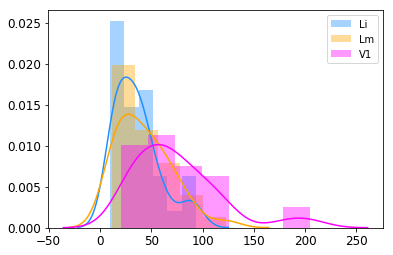

In [21]:
r2_thr=0.5
fig, ax = pl.subplots()
for visual_area, g in projection_df[projection_df['R2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['cortical_mag'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()

In [442]:
# Load 1 fov to test sth
animalid='JC110'
session = '20191006'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_5ae341/retino-structure/projection_results.pkl
(array([[ 0.02216148]]), array([ 19.95735156]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.928207  1.648383     0.022161   az  19.957352        0.0   0.963435
1  0.969433  0.526419     0.010254   el -12.249892        0.0   0.984598


['el', 'az']

# Cortical magnification

In [22]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', area_colors=None):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor)
    
    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.4,1.2), fontsize=8)

    return fig


In [23]:
def plot_axis_distributions(projdf, currmetric='abs_coef', hue='cond',
                            currcols=['windows blue', 'amber'], 
                             fontsize=10, fontcolor='k', area_colors=None):

    bi_palette = sns.xkcd_palette(currcols)

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    sns.stripplot(x='visual_area', y=currmetric, hue=hue, data=projdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", currmetric, data=projdf,
               hue=hue, order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    #ax.set_ylim([0, 0.12])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    pl.legend(bbox_to_anchor=((1.2, 1)))
    projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor)

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.2), fontsize=8)

    return fig

# Filter retino gradient results
- (Set some R2 threshold)
- "Bad" fits suggests that the retino gradient was messed up or points were all over the place?
- Also, drop extra run (retino_run1, and retino_run2)
- May have duplicate FOVS.

In [24]:
projection_df[['visual_area', 'datakey', 'retinorun']].drop_duplicates().groupby(['visual_area']).count()

datakey  retinorun
visual_area                    
Li                24         24
Lm                20         20
V1                16         16

In [25]:
repeat_retinos = pd.concat([g for k, g in projection_df.groupby(['visual_area', 'datakey']) \
                            if len(g['retinorun'].unique())>1], axis=0)


In [26]:
repeat_retinos.groupby(['visual_area', 'datakey']).count()

R2  RMSE  coefficient  cond  intercept  \
visual_area datakey                                                       
Li          20190605_JC090_fov1   4     4            4     4          4   
Lm          20190508_JC083_fov1   4     4            4     4          4   
            20190525_JC084_fov1   4     4            4     4          4   
V1          20190507_JC083_fov1   4     4            4     4          4   
            20190522_JC084_fov1   4     4            4     4          4   

                                 pearson_p  pearson_r  retinorun  fov  \
visual_area datakey                                                     
Li          20190605_JC090_fov1          4          4          4    4   
Lm          20190508_JC083_fov1          4          4          4    4   
            20190525_JC084_fov1          4          4          4    4   
V1          20190507_JC083_fov1          4          4          4    4   
            20190522_JC084_fov1          4          4          4    4   

                                 session  animalid  retinoid  fpath  abs_coef  \
visual_area datakey                                                             
Li          20190605_JC090_fov1        4         4         4      4         4   
Lm          20190508_JC083_fov1        4         4         4      4         4   
            20190525_JC084_fov1        4         4         4      4         4   
V1          20190507_JC083_fov1        4         4         4      4         4   
            20190522_JC084_fov1        4         4         4      4         4   

                                 cortical_mag  
visual_area datakey                            
Li          20190605_JC090_fov1             4  
Lm          20190508_JC083_fov1             4  
            20190525_JC084_fov1             4  
V1          20190507_JC083_fov1             4  
            20190522_JC084_fov1             4

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'compare_runs_retinograd_pixels_thr-0.003')


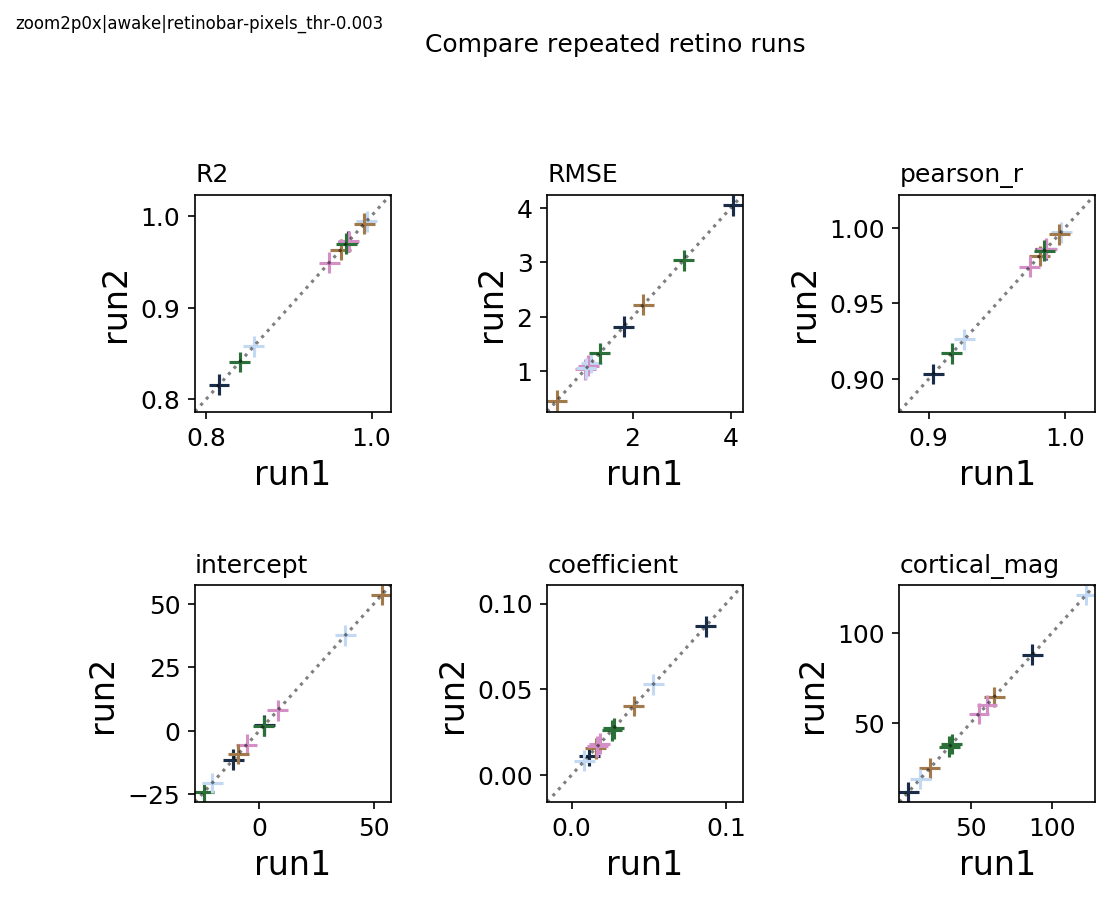

In [27]:
fig, axn = pl.subplots(2, 3, figsize=(8,6), dpi=dpi)
dkey_colors = sns.color_palette('cubehelix', n_colors=len(repeat_retinos['datakey'].unique()))

params=['R2', 'RMSE', 'pearson_r', 'intercept', 'coefficient', 'cortical_mag']
for ax, p in zip(axn.flat, params):
    currx = repeat_retinos[repeat_retinos['retinorun']=='retino_run1'][p].values
    curry = repeat_retinos[repeat_retinos['retinorun']=='retino_run2'][p].values
    ax.scatter(currx, curry, c=dkey_colors, marker='+', s=100)
    ax.set_title(p, loc='left', fontsize=12)
    ax.set_ylabel('run2')
    ax.set_xlabel('run1')
    max_lim = max([ax.get_ylim()[1], ax.get_xlim()[1]])
    min_lim = min([ax.get_ylim()[0], ax.get_xlim()[0]])
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k:', alpha=0.5)
pl.subplots_adjust(left=0.15, right=0.9, hspace=0.8, wspace=0.8, top=0.8)
fig.suptitle("Compare repeated retino runs")

label_figure(fig, retino_dataid)
figname = 'compare_runs_retinograd_%s' % (magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Remove repeat runs

In [28]:
gradient_df = pd.concat([g[g['retinorun']=='retino_run2'] if len(g['retinorun'].unique())>1 else g for k, g in projection_df.groupby(['visual_area', 'datakey'])], axis=0)
gradient_df['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in gradient_df[['datakey', 'retinorun']].values]
print(projection_df.shape, gradient_df.shape)


((120, 17), (110, 18))


# Filter FOVs, only select good gradient fits

In [311]:
r2_thr=0.5
all_retino_datakeys = gradient_df['datakey'].unique()
    
# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in gradient_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
print(gradient_df.shape, projdf.shape)


((110, 18), (74, 18))


In [312]:
pass_retino_datakeys = projdf['datakey'].unique()
fail_retino_datakeys = [r for r in projection_df['datakey'].unique() if r not in pass_retino_datakeys]
print("%i of %i retinokeys pass threshold (R2=%.2f)" % (len(pass_retino_datakeys), len(all_retino_datakeys), r2_thr))


37 of 55 retinokeys pass threshold (R2=0.50)


### Cortical mag, PAIRED

V1: (t-stat:-4.82, p=0.00)
Lm: (t-stat:-6.40, p=0.00)
Li: (t-stat:-3.99, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'cortical_mag_paired__R2-0.50_pixels_thr-0.003')


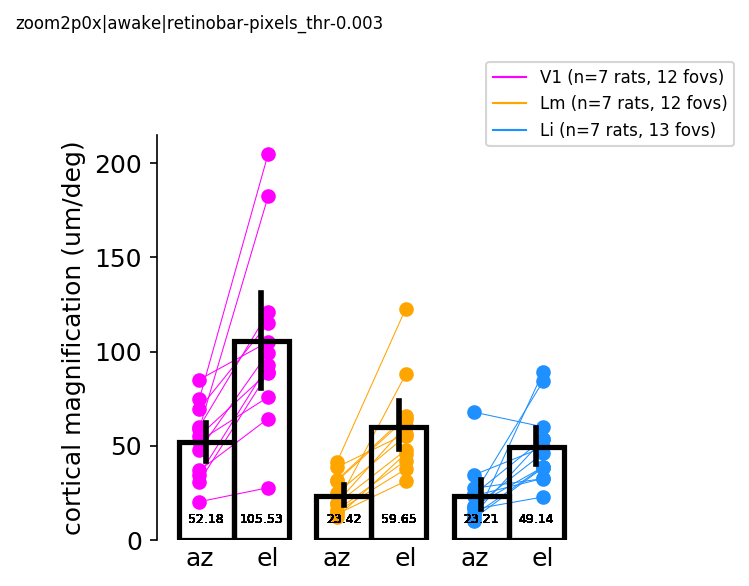

In [314]:
metric = 'cortical_mag'
#metric = 'abs_coef'

fig = plot_pairwise_by_axis(projdf, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors, fontsize=6, fontcolor='k')
pl.subplots_adjust(left=0.2, right=0.75, top=0.8)
if metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)
else:
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)

label_figure(fig, retino_dataid)
figname = '%s_paired__%s_%s' % (metric, fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Plot means, rather than splitting cond

In [315]:
gradient_means = projdf.groupby(['visual_area', 'retinokey']).mean().reset_index()

********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.002 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.215 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'avg_cortical_mag__R2-0.50_pixels_thr-0.003')


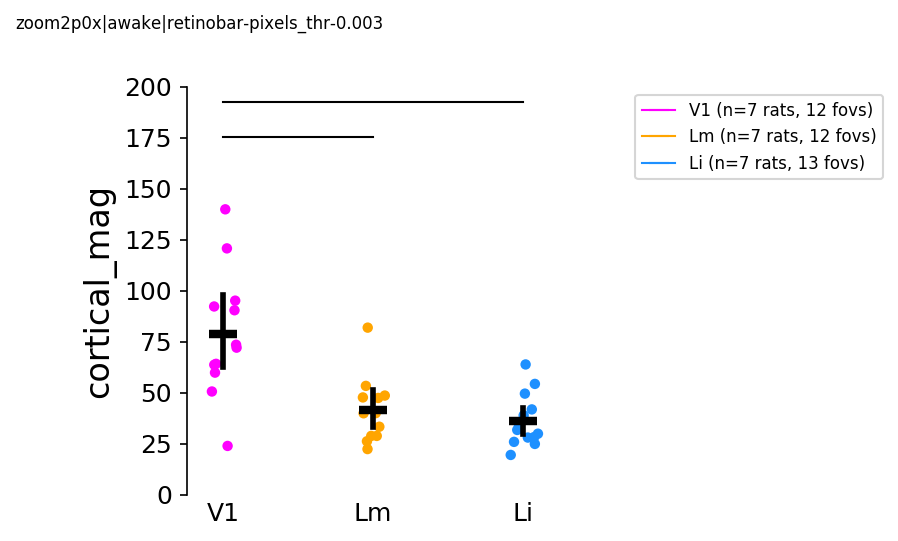

In [316]:
multi_comp_test = 'fdr_bh'
fig, ax = pl.subplots(dpi=dpi, figsize=(6,4))

sns.stripplot(x='visual_area', y='cortical_mag', data=gradient_means,
             ax=ax, palette=area_colors, zorder=0, order=visual_areas)
sns.pointplot(x='visual_area', y='cortical_mag', data=gradient_means,
             ax=ax, join=False, scale=2, markers='_', color='k',zorder=0, order=visual_areas)

statresults, ax = aggr.plot_mannwhitney(gradient_means, metric='cortical_mag', #y_loc=160,
                                        multi_comp_test=multi_comp_test, ax=ax)
ax.set_ylim([0, 200])
ax.tick_params(axis='x', which='both', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True, offset=4)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.6)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.2,1), fontsize=8)

label_figure(fig, retino_dataid)
figname = 'avg_cortical_mag__%s_%s' % (fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Compare by area, for each axis

********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.001 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.266 (fdr_bh), reject H0=False
****************************
********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.005 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.002 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.111 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'avg_cortical_mag_split-cond__R2-0.50_pixels_thr-0.003')


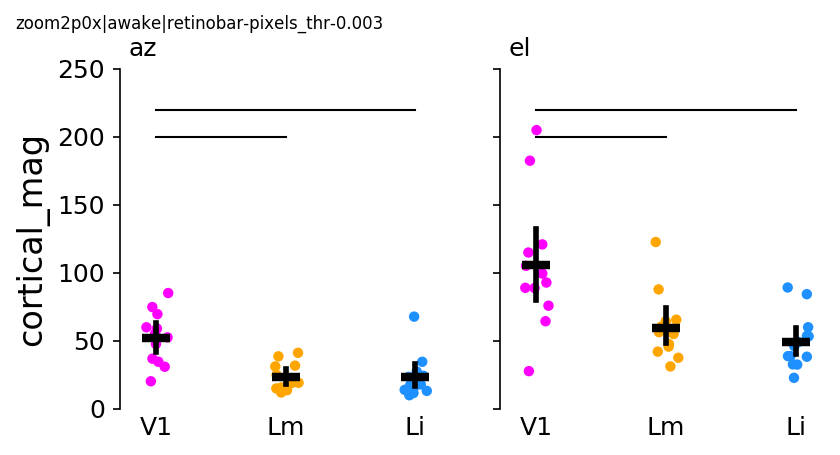

In [317]:
multi_comp_test = 'fdr_bh'
fig, axn = pl.subplots(1, 2, dpi=dpi, figsize=(6,3), sharex=True, sharey=True)

for ax, (cond, cond_df) in zip(axn.flat, projdf.groupby(['cond'])):

    sns.stripplot(x='visual_area', y='cortical_mag', data=cond_df,
                 ax=ax, palette=area_colors, zorder=0, order=visual_areas)
    sns.pointplot(x='visual_area', y='cortical_mag', data=cond_df,
                 ax=ax, join=False, scale=2, markers='_', color='k',zorder=0, order=visual_areas)

    statresults, ax = aggr.plot_mannwhitney(cond_df, metric='cortical_mag', y_loc=200, offset=20,
                                            multi_comp_test=multi_comp_test, ax=ax, )
    ax.tick_params(axis='x', which='both', size=0)
    #pl.subplots_adjust(left)
    ax.set_title(cond, loc='left', fontsize=12)
    ax.set_xlabel('')
ax.set_ylim([0, 250])
sns.despine(bottom=True, trim=True, offset=4)
axn[1].set_ylabel('')


label_figure(fig, retino_dataid)
figname = 'avg_cortical_mag_split-cond__%s_%s' % (fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Cortical mag, either axis passes

In [318]:
r2_thr=0.5
# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])


In [319]:
retino_dataid

'zoom2p0x|awake|retinobar-pixels_thr-0.003'

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'cortical_mag__R2-0.50_pixels_thr-0.003')


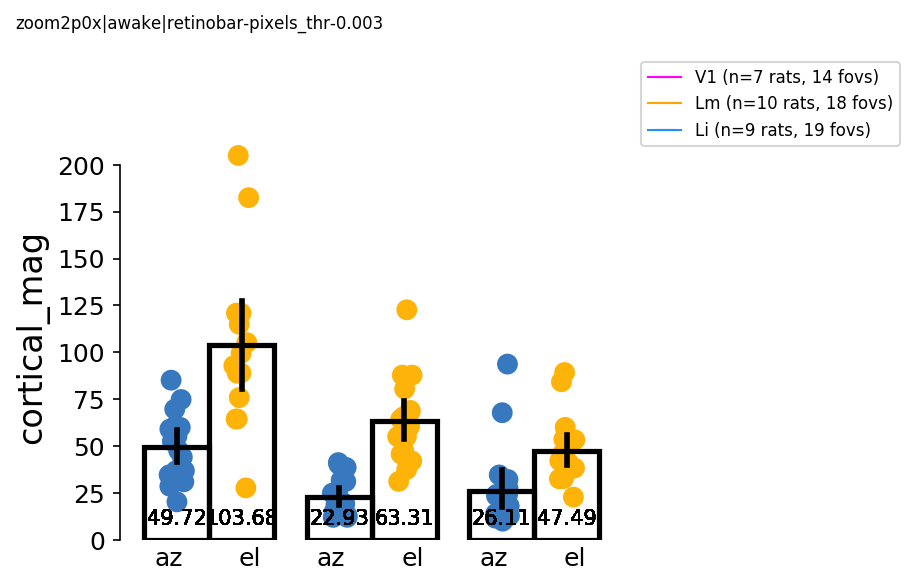

In [322]:
#currmetric='abs_coef'
currmetric = 'cortical_mag'

hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(projdf[projdf['R2']>r2_thr], currmetric=currmetric, hue=hue,
                            currcols=currcols, area_colors=area_colors)
label_figure(fig, retino_dataid)

pl.subplots_adjust(left=0.15, right=0.8, top=0.8)

figname = '%s__R2-%.2f_%s' % (currmetric, r2_thr, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Scatter

In [29]:
from pipeline.python.rois.utils import load_roi_coords

In [30]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

    #### Split fx, fy for theta comp
    r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
    r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
    r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

    # Convert thetas to [-90, 90]
    thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
              else (t % np.pi) for t in r_df['theta'].values]
    r_df['theta_c'] = thetas

    return r_df

In [31]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

### Select RF dataset filters

In [32]:
rf_filter_by

'drop_repeats'

In [33]:
rf_filter_by = None # 'drop_repeats'

reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

rf_fit_str = '%s_%s' % (rf_filter_by, reliable_str)

rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_str)
print(rf_dataid)


zoom2p0x|awake|rfs-None_reliable


In [34]:
rf_fit_desc

'fit-2dgaus_dff-no-cutoff'

In [35]:
# Set data identifiers

#retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
#rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|retinobar-%s|rfs-%s' % (fov_type, state, magthr_str, rf_fit_str)
print(data_id)


zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-None_reliable


# Load cell positions (and RF info)

In [36]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [37]:
#df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))


['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl']

In [38]:
df_fpath = glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))[0]
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


In [39]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            rf_df = pkl.load(f)
        if isinstance(rf_df, dict):
            rf_df = rf_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
False


In [40]:
if get_positions:
    # Get RF fit info first
    rf_df = get_rf_dataframe(filter_by=filter_by, reliable_only=reliable_only,
                     fit_thr=fit_thr, traceid=traceid, fit_desc=fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rf_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in rf_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rf_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(rf_df, f, protocol=pkl.HIGHEST_PROTOCOL)

In [41]:
# no_retino=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     if (projdf[projdf['datakey']==datakey].shape[0])==0:
#         no_retino.append((visual_area, datakey))
# for r in no_retino:
#     print r
    

In [42]:
rf_df.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
0  0.826039  23.640365  13.125770  0.117896   6.700889  -8.282818    JC076   
1  0.725070  43.796452  29.207447  0.234407 -22.165338  -2.970096    JC076   
2  0.701576  47.503138  24.790225  0.458457  15.301437  31.251545    JC076   
3  0.781400  23.130716  44.809417  0.155088   2.496442  37.699467    JC076   
4  0.627347  32.132070  25.065036  5.892774   0.014677  17.244112    JC076   

   cell              datakey experiment   ...      fwhm_avg    std_avg  \
0     0  20190502_JC076_fov1        rfs   ...     18.383068   7.822582   
1    84  20190502_JC076_fov1        rfs   ...     36.501949  15.532744   
2   115  20190502_JC076_fov1        rfs   ...     36.146682  15.381567   
3   120  20190502_JC076_fov1        rfs   ...     33.970067  14.455348   
4   135  20190502_JC076_fov1        rfs   ...     28.598553  12.169597   

         area  datakey_ix  fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix  \
0  176.519678           0   85.2665            37   218.928           115   
1  727.690433           0   638.347           277   605.382           318   
2  669.910720           0   1034.72           449   788.139           414   
3  589.620427           0   956.368           415   761.487           400   
4  458.164233           0   1115.38           484   740.546           389   

    ml_pos   ap_pos  
0  753.872  1092.33  
1  367.418  539.253  
2  184.661  142.879  
3  211.313  221.232  
4  232.254  62.2215  

[5 rows x 25 columns]

In [43]:
rf_df.groupby(['visual_area', 'datakey', 'experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0  \
visual_area datakey             experiment                                    
Li          20190502_JC076_fov1 rfs          19      19      19     19   19   
            20190522_JC089_fov1 rfs           3       3       3      3    3   
                                rfs10         6       6       6      6    6   
            20190527_JC092_fov2 rfs10        14      14      14     14   14   
            20190527_JC092_fov3 rfs10        42      42      42     42   42   
            20190528_JC092_fov1 rfs10         7       7       7      7    7   
            20190602_JC091_fov1 rfs          41      41      41     41   41   
                                rfs10        72      72      72     72   72   
            20190605_JC090_fov1 rfs10        17      17      17     17   17   
            20190606_JC091_fov1 rfs10        42      42      42     42   42   
            20190607_JC091_fov1 rfs10        69      69      69     69   69   
            20190609_JC099_fov1 rfs10        38      38      38     38   38   
            20190612_JC099_fov1 rfs10        40      40      40     40   40   
            20190614_JC091_fov1 rfs10        99      99      99     99   99   
            20190617_JC099_fov1 rfs10        11      11      11     11   11   
            20191003_JC111_fov1 rfs10        11      11      11     11   11   
            20191007_JC091_fov1 rfs          19      19      19     19   19   
                                rfs10        21      21      21     21   21   
            20191008_JC091_fov1 rfs10        46      46      46     46   46   
            20191012_JC113_fov1 rfs10         3       3       3      3    3   
            20191012_JC113_fov2 rfs10        19      19      19     19   19   
            20191017_JC113_fov1 rfs          12      12      12     12   12   
                                rfs10        28      28      28     28   28   
            20191018_JC113_fov1 rfs10        13      13      13     13   13   
            20191104_JC117_fov1 rfs10        32      32      32     32   32   
            20191105_JC117_fov1 rfs10        10      10      10     10   10   
            20191106_JC120_fov1 rfs10        20      20      20     20   20   
            20191111_JC120_fov1 rfs10         4       4       4      4    4   
Lm          20190423_JC076_fov1 rfs          15      15      15     15   15   
            20190430_JC078_fov1 rfs          36      36      36     36   36   
...                                         ...     ...     ...    ...  ...   
            20190615_JC097_fov3 rfs10        47      47      47     47   47   
            20190618_JC097_fov1 rfs          14      14      14     14   14   
                                rfs10        28      28      28     28   28   
            20190627_JC091_fov1 rfs           9       9       9      9    9   
            20191004_JC110_fov3 rfs10        11      11      11     11   11   
            20191004_JC110_fov4 rfs10        19      19      19     19   19   
            20191012_JC113_fov3 rfs10        18      18      18     18   18   
            20191104_JC117_fov2 rfs10        50      50      50     50   50   
            20191106_JC120_fov4 rfs10         8       8       8      8    8   
            20191111_JC117_fov2 rfs10         2       2       2      2    2   
V1          20190420_JC076_fov1 rfs          36      36      36     36   36   
            20190501_JC076_fov1 rfs          11      11      11     11   11   
            20190507_JC083_fov1 rfs          56      56      56     56   56   
            20190510_JC083_fov1 rfs          33      33      33     33   33   
            20190511_JC083_fov1 rfs          44      44      44     44   44   
            20190522_JC084_fov1 rfs         130     130     130    130  130   
            20190613_JC097_fov1 rfs          67      67      67     67   67   
                                rfs10       107     107     107    107  107   
            2019

#### Test single FOV with above fits, after loading RF stuff

In [331]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )


fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

In [585]:
# Load 1 fov to test sth
animalid='JC085'
session = '20190622'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/retino-structure/projection_results.pkl
(array([[ 0.00689552]]), array([ 28.9482809]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.474316  2.214660     0.006896   az  28.948281        0.0   0.688706
1  0.942234  0.691157     0.009458   el -14.141244        0.0   0.970687


['el', 'az']

Text(0.5,0.98,u'Lm')

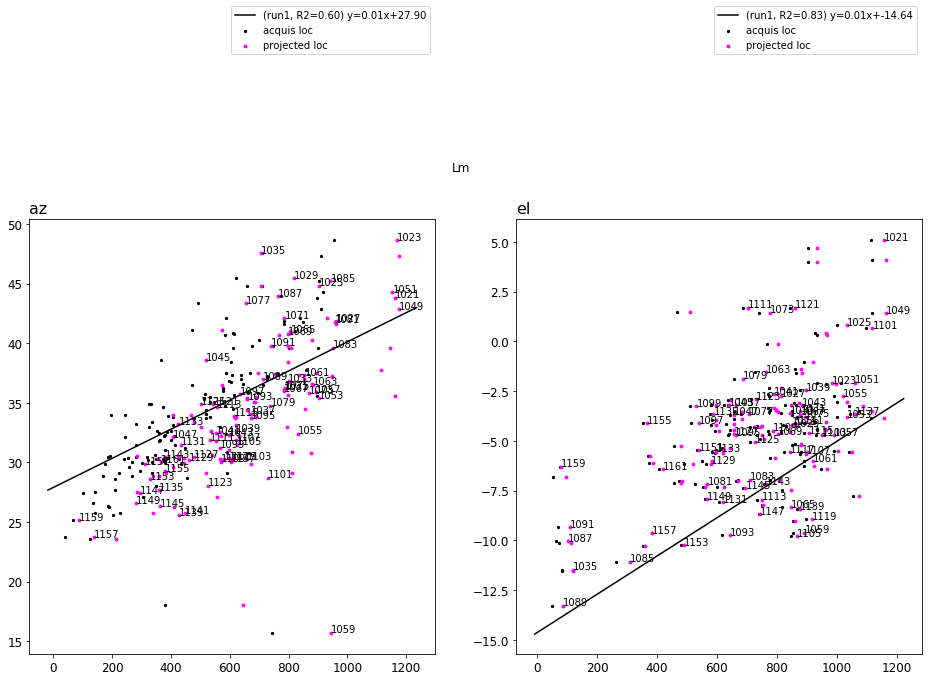

In [607]:
did_above=True
datakey = '20190622_JC085_fov1' #'20190522_JC084_fov1' #'20190607_JC091_fov1'
retinorun = 'retino_run1'

rf_ = rfdf[rfdf['datakey']==datakey].copy()
ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]

#vhat_az = gresults['az']['vhat']
#vhat_el = gresults['el']['vhat']

fig, axn = pl.subplots(1,2, figsize=(16,8))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'
    vhat_ = vhat_az if cond=='az' else vhat_el
    if did_above:
        ret_ = ret_az[~np.isnan(ret_az)] if cond=='az' else ret_el[~np.isnan(ret_el)]
        regr_ = regr_az if cond=='az' else regr_el
        fitv_ = fitv_az if cond=='az' else fitv_el
    #print(cond, vhat_)
    
    cell_locs = rf_['%s_pos' % xname].values
    rf_locs = rf_['%s' % yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='acquis loc')

    #proj_locs = rfdf[rfdf['datakey']==datakey]['%s_proj' % xname].values
    #ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='dodgerblue')    
    
    # Plot projected points, not abs
    proj_locs2 = np.array([np.dot(np.array((ml, ap)), vhat_) \
                          for ap, ml in rf_[['ap_pos', 'ml_pos']].values])
    ax.scatter(proj_locs2, rf_locs, marker='o', s=8, color='magenta', label='projected loc')   
    
    # Label cells
    label_int=2
    for ri, cellid in enumerate(rf_.index.tolist()[0::label_int]):
        ax.text(proj_locs2[0::label_int][ri], rf_locs[0::label_int][ri], cellid)

    # Plot retino direction
    if did_above:
        slope = float(regr_.coef_) 
        intercept = float(regr_.intercept_) 
        r2_v = skmetrics.r2_score(ret_, fitv_) 
    else:
        slope = float(ret_[ret_['cond']==cond]['coefficient'])
        intercept = float(ret_[ret_['cond']==cond]['intercept'])
        r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix)

   #ax.invert_yaxis()
    ax.set_title(cond, loc='left', size=16)
    ax.legend(bbox_to_anchor=(1.,1.5))
    
pl.suptitle(currvs['visual_area'].unique()[0])

# Filter dfs: Only include dsets with both retino + rfs/rfs10 measured.
#### Also filter retino gradient df to only include dsets that have good fits (i.e., R2 > thr means retino direction well enough estimated or consistent enough to get a good projection)
NOTE:  TODO, check bad-fit retino dsets, since these may be split FOVs

In [44]:
retino_datakeys = gradient_df['datakey'].unique()
rf_datakeys = rf_df['datakey'].unique()
common_datakeys = np.intersect1d(gradient_df['datakey'].unique(), rf_df['datakey'].unique())

print("Retino: %i, RFs: %i, Common: %i" % (len(retino_datakeys), len(rf_datakeys), len(common_datakeys)))

Retino: 55, RFs: 61, Common: 53


In [45]:
# pass_regr_datakeys = projdf['datakey'].unique()
#rfdf = df[df['datakey'].isin(pass_regr_datakeys)].copy()
rfdf = rf_df[rf_df['datakey'].isin(common_datakeys)].copy()
print("RFs:")
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

projdf = gradient_df[gradient_df['datakey'].isin(common_datakeys)].copy()
print("retinogradients:")
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

RFs:
             datakey
visual_area         
Li                21
Lm                18
V1                14
retinogradients:
             datakey
visual_area         
Li                21
Lm                18
V1                14


In [46]:
projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
print("retinogradients (filt):")
print(projdf_filtered[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

retinogradients (filt):
             datakey
visual_area         
Li                13
Lm                12
V1                12


In [47]:
#filter_by, fit_str, magthr_str
figstr = 'rfs_%s_retino_%s' % (rf_filter_by, magthr_str)
figstr

'rfs_None_retino_pixels_thr-0.003'

# Drop Repeats, paired

V1: (t-stat:6.69, p=0.00)
Lm: (t-stat:6.96, p=0.00)
Li: (t-stat:4.43, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'abs_coef_paired__rfs_None_retino_pixels_thr-0.003')


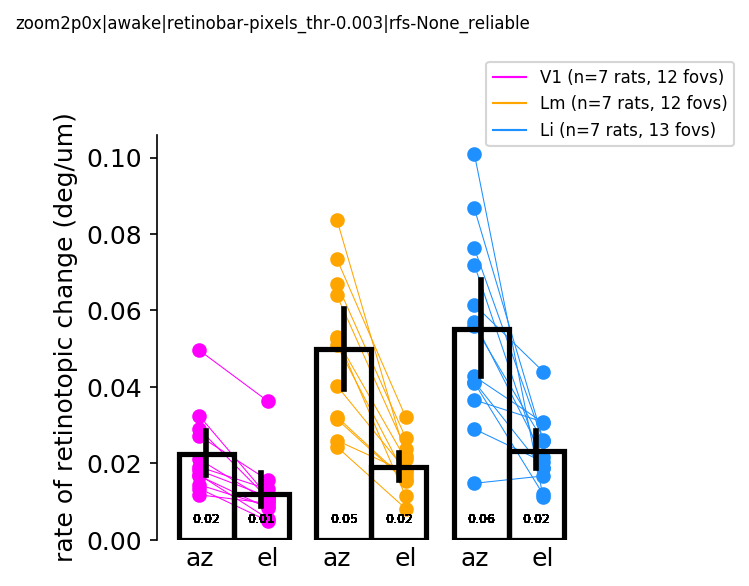

In [48]:
metric = 'abs_coef'
fig = plot_pairwise_by_axis(projdf_filtered, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors, fontsize=6, fontcolor='k')
pl.subplots_adjust(left=0.2, right=0.75, top=0.8)
if metric=='cortical_mag':
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)
elif metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)

label_figure(fig, data_id)
figname = '%s_paired__%s' % (metric, figstr)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)

## Drop Repeats - any (not paired)

In [367]:
projdf_either = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'cortical_mag_any__rfs_drop_repeats_retino_pixels_thr-0.003')


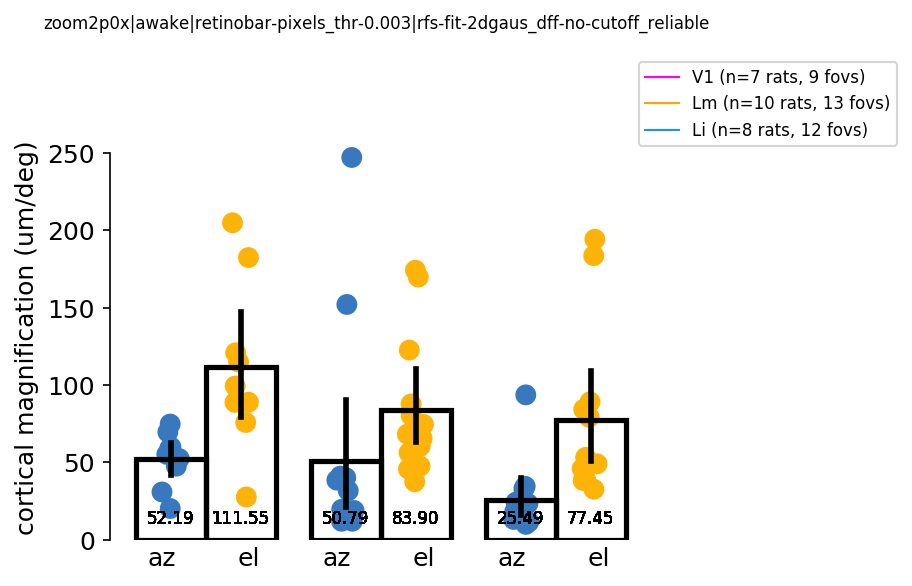

In [371]:
plotdf = projdf_either.copy()

metric='cortical_mag'
hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(plotdf, currmetric=metric, hue=hue,
                            currcols=currcols, area_colors=area_colors,
                             fontsize=8, fontcolor='k')
pl.subplots_adjust(left=0.1, right=0.8, top=0.8)
if metric=='cortical_mag':
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)
elif metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)

label_figure(fig, data_id)
figname = '%s_any__%s' % (metric, figstr)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)


# Get projected ctx positions

In [49]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((datakey, exp), rd) in enumerate(rfdf.groupby(['datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))
        
    retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])

1 of 61 gradient result files loaded.
11 of 61 gradient result files loaded.
21 of 61 gradient result files loaded.
31 of 61 gradient result files loaded.
41 of 61 gradient result files loaded.
51 of 61 gradient result files loaded.
61 of 61 gradient result files loaded.


In [50]:
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
# projdf.groupby(['visual_area', 'datakey', 'cond']).mean()

             datakey
visual_area         
Li                21
Lm                18
V1                14


In [51]:
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                21
Lm                18
V1                14


## Plot az/el per session, for 1 FOV (rfs or rfs10, best retino)

In [52]:
def plot_retino_scatter_by_fov(vdf, projdf, cond_colors=['blue', 'orange'], cond_names=['az', 'el'],
                            markersize=10, col_wrap=6):
    n_fovs = len(vdf['datakey'].unique())
    n_subplots = n_fovs*2
    n_rows = int(np.ceil(n_subplots/float(col_wrap))) #nsubplots % col_wrap

    fig, axn = pl.subplots(n_rows, col_wrap, figsize=(col_wrap*3, n_rows*4))
    ai=0
    for datakey, rfs_ in vdf.groupby(['datakey']):
        for ci, (col, cond) in enumerate(zip(cond_colors, cond_names)):
            ax = axn.flat[ai]
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'

            # Get RF fit info
            cell_locs = rfs_['%s_pos' % xname].values
            proj_locs = rfs_['%s_proj' % xname].values
            rf_locs = rfs_[yname].values

            # Plot RF pos
            ax.scatter(cell_locs, rf_locs, marker='o', s=markersize, color='k')

            # Plot projected
            ax.scatter(proj_locs, rf_locs, marker='o', s=markersize, color=col)

            # Plot retino direction
            # Get best retino run, in case there is > 1
            retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
            ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()

            slope = float(ret_[ret_['cond']==cond]['coefficient'])
            intercept = float(ret_[ret_['cond']==cond]['intercept'])
            ls = ':' if float(ret_[ret_['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(ret_[ret_['cond']==cond]['R2'])
            label_prefix = '%s, R2=%.2f' % (cond, r2_v) #(retinorun.split('_')[-1], r2_v)
            # label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix, ls=ls)
            if ci==0:
                ax.set_title(datakey, fontsize=20, loc='left')
            ai += 1
            ax.legend(loc='bottom') #bbox_to_anchor=(0.5, -0.1))
            
    for a in np.arange(ai, (n_rows*col_wrap)):
        axn.flat[a].axis('off')
        
    return fig


In [53]:

by_session_dir = os.path.join(dst_dir, 'scatter_by_session')
if not os.path.exists(by_session_dir):
    os.makedirs(by_session_dir)

print(data_id)

zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-None_reliable


In [54]:
by_session_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session'

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs_Li_retinoscatter_rfs_None_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs_Lm_retinoscatter_rfs_None_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs_V1_retinoscatter_rfs_None_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs10_Li_retinoscatter_rfs_None_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs10_Lm_retinoscatter_rfs_None_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session', 'rfs10_V1_retinoscatter_rfs_None_retino_pixels_thr-

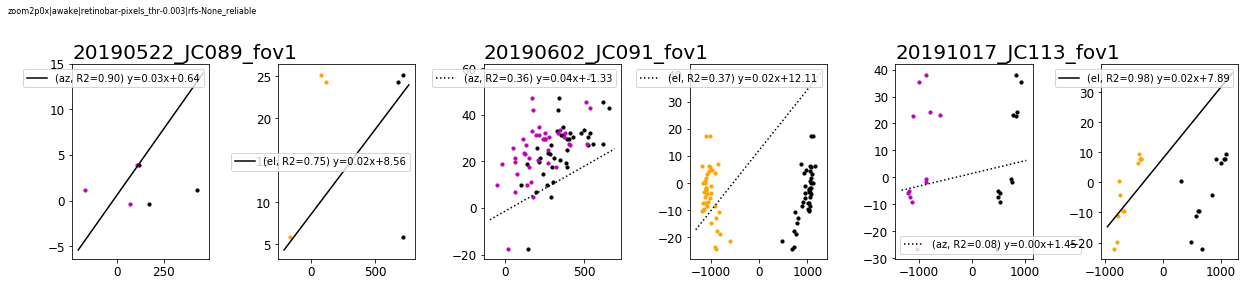

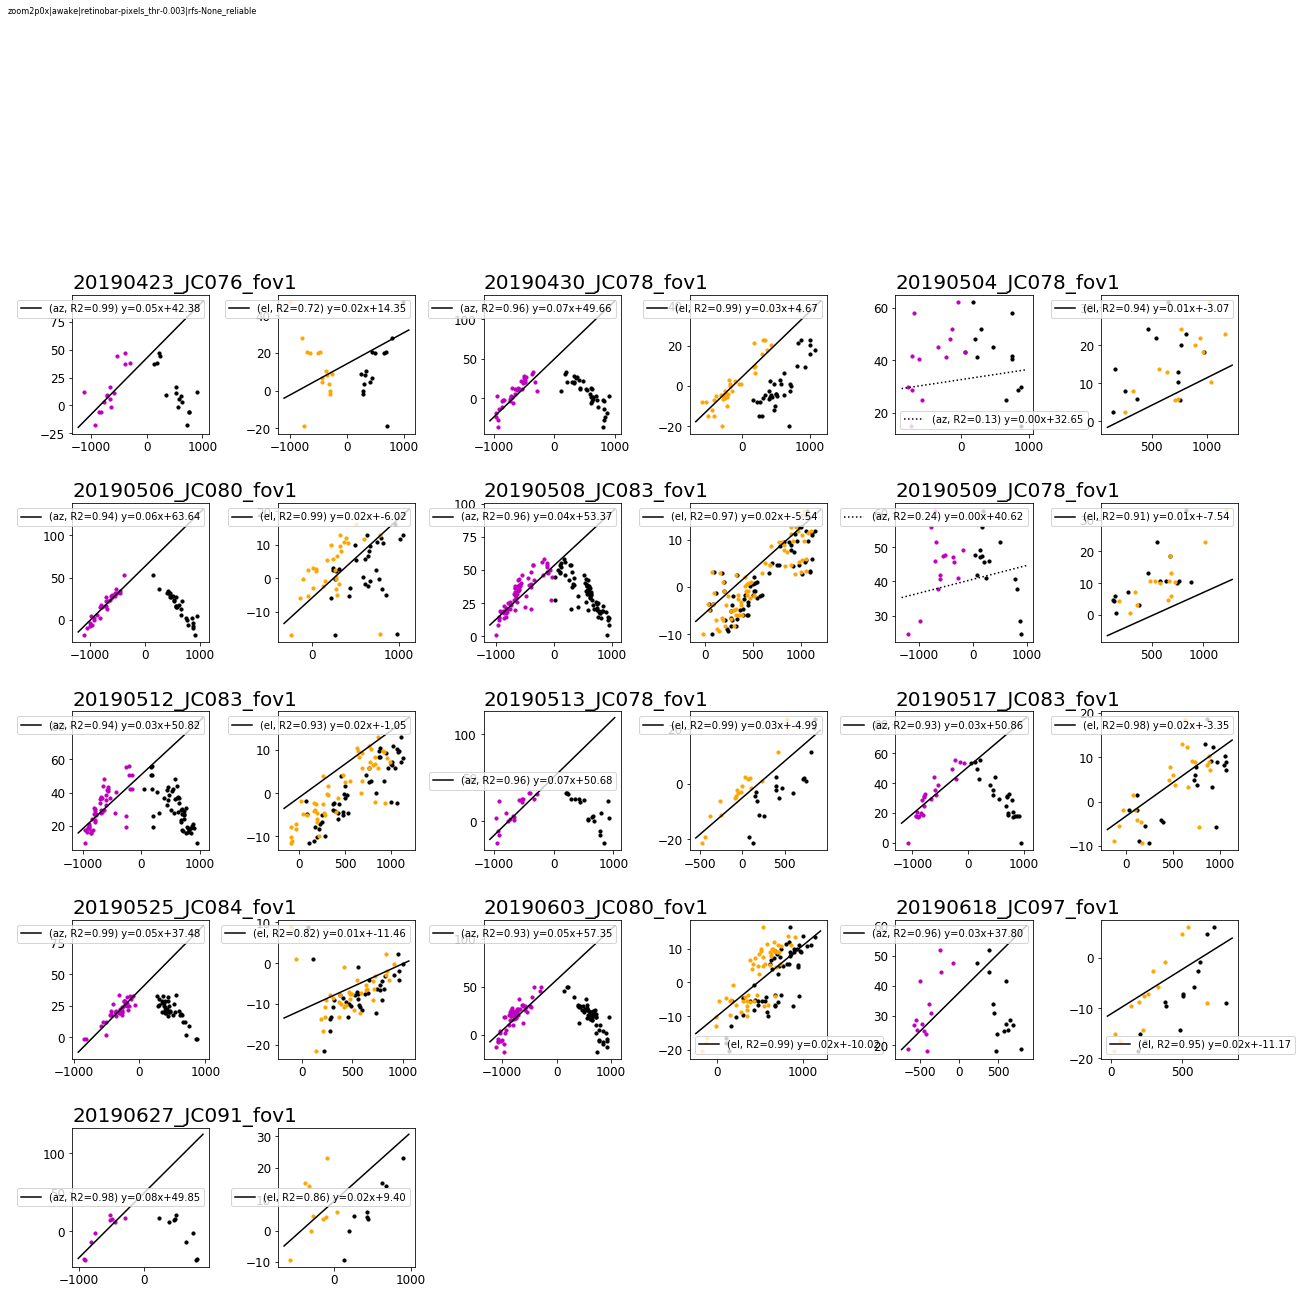

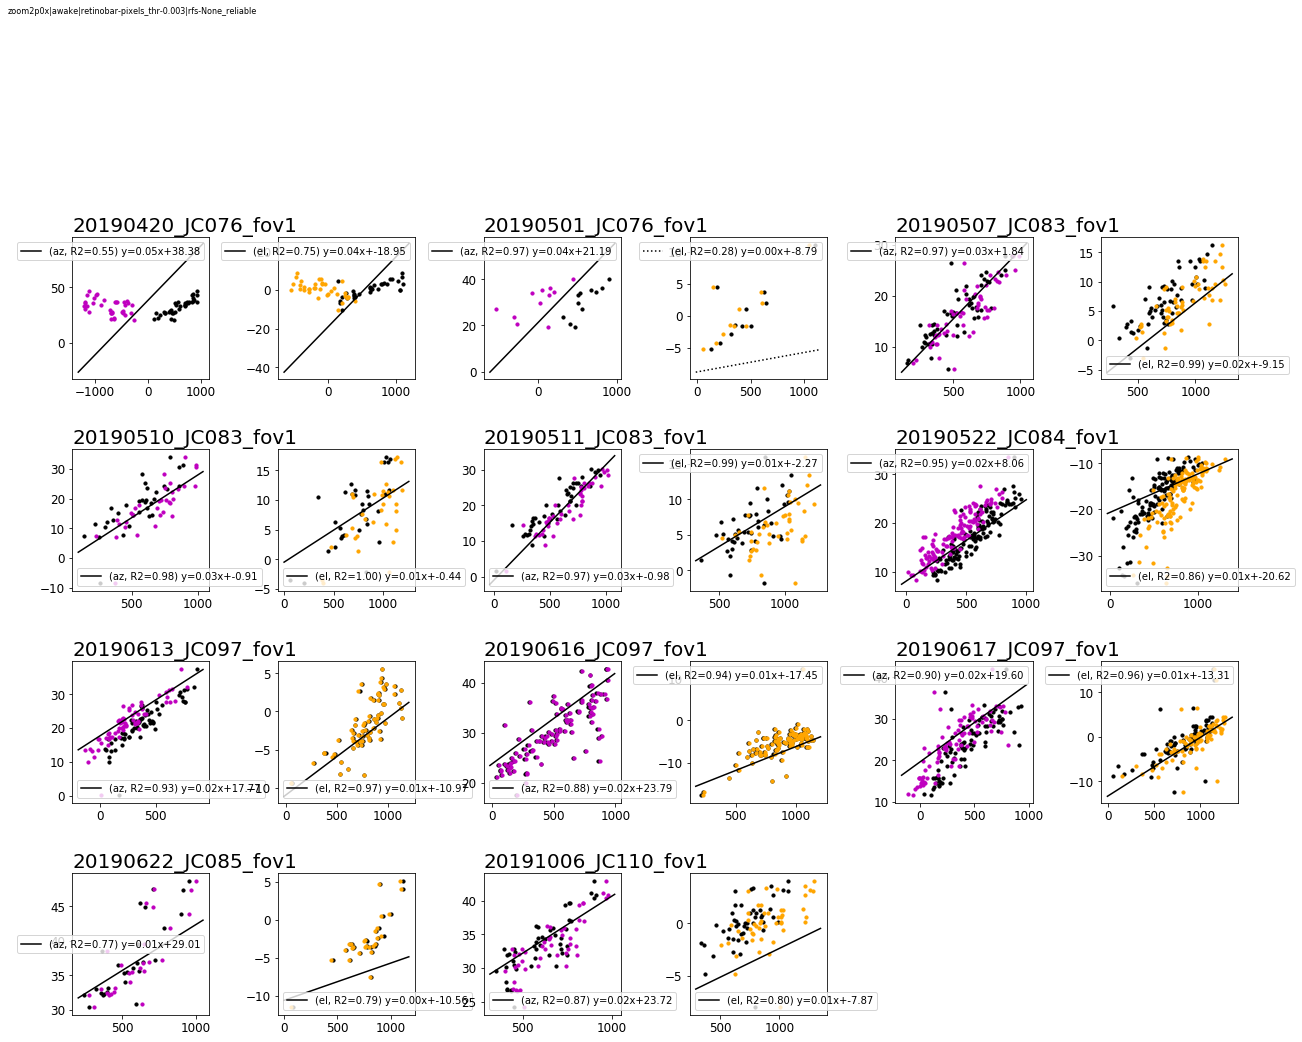

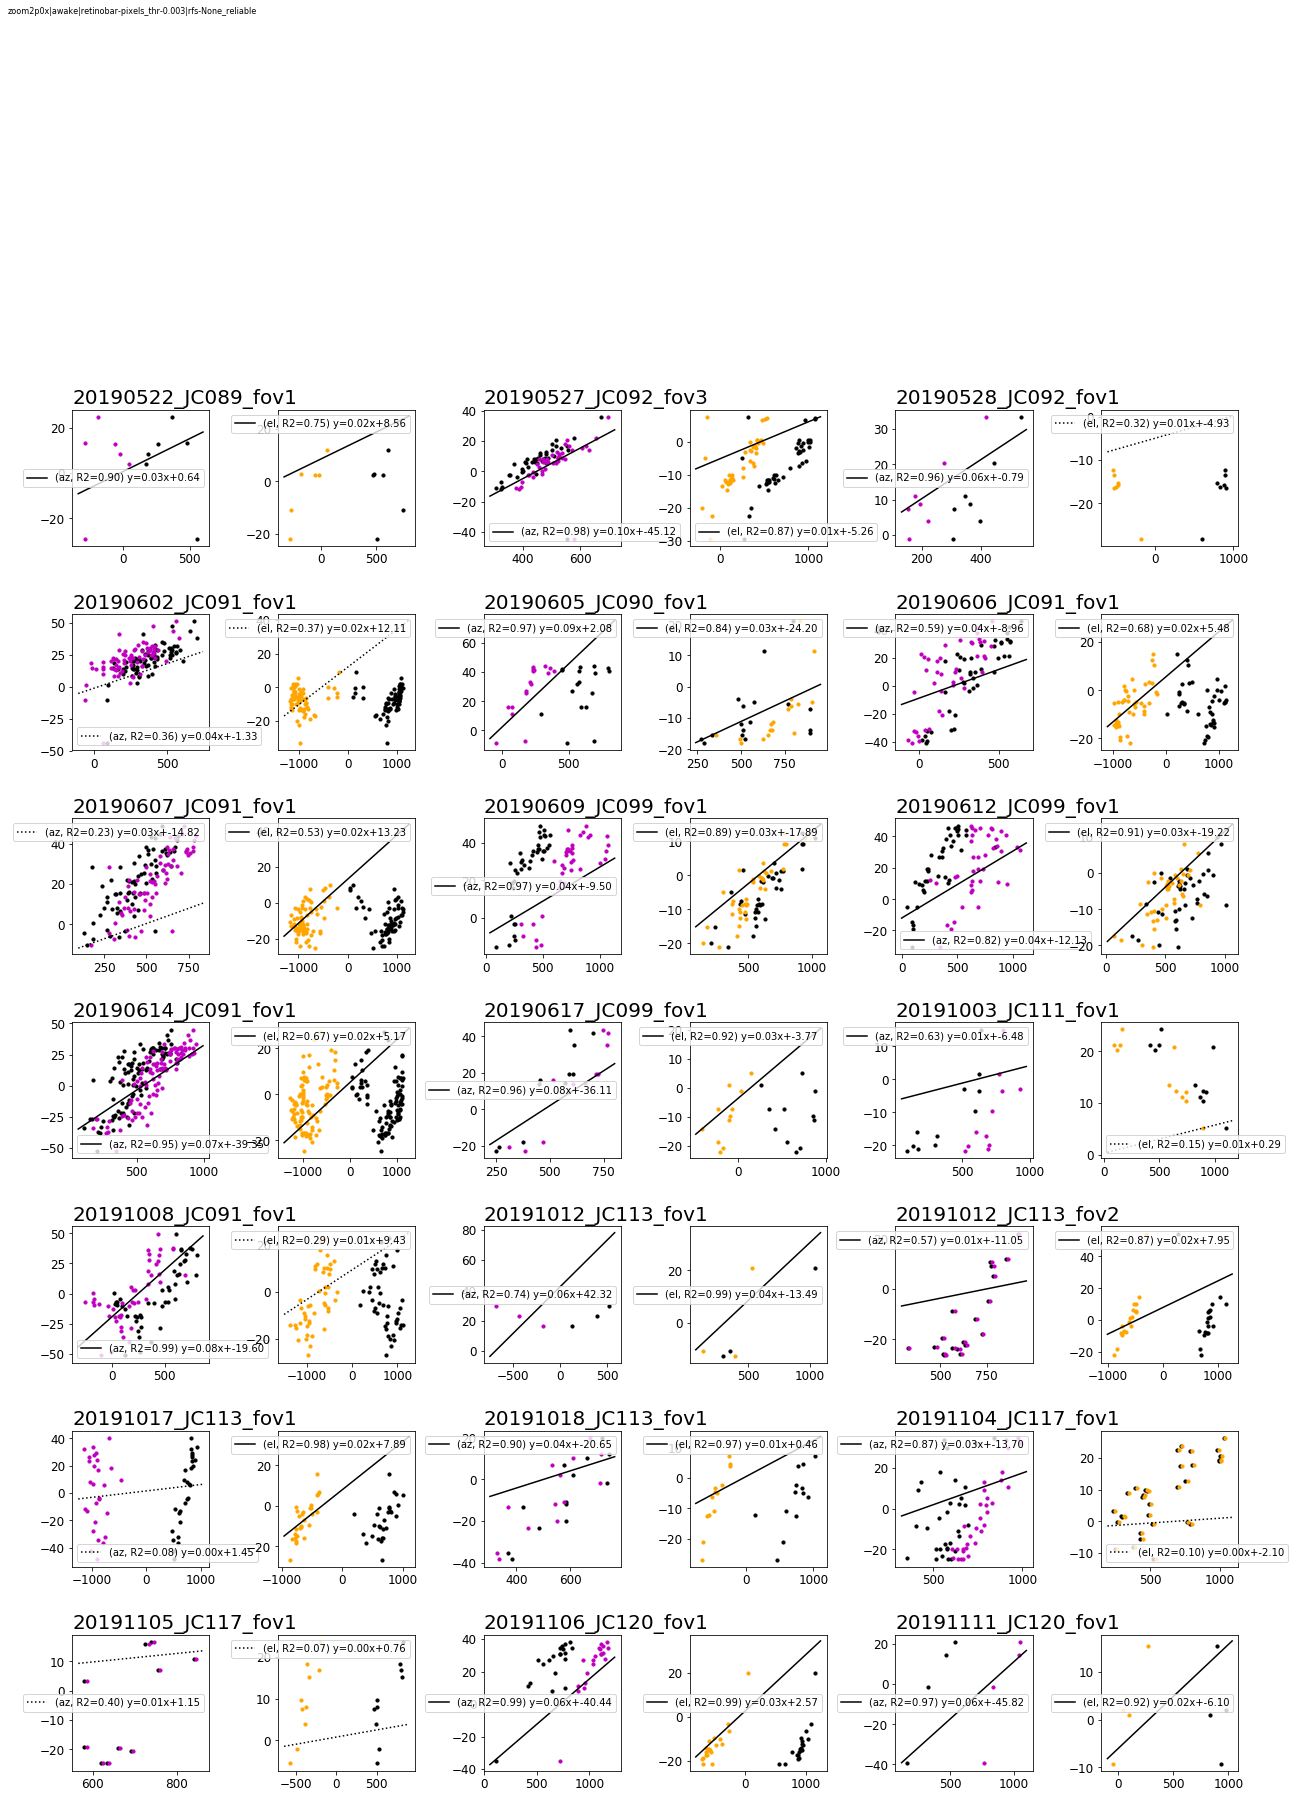

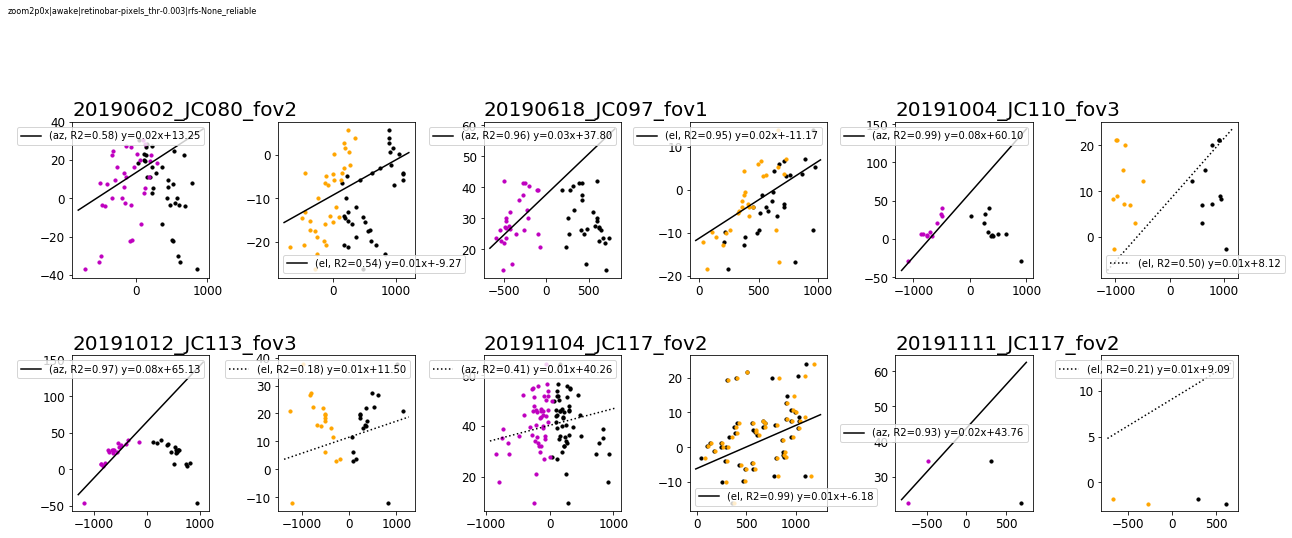

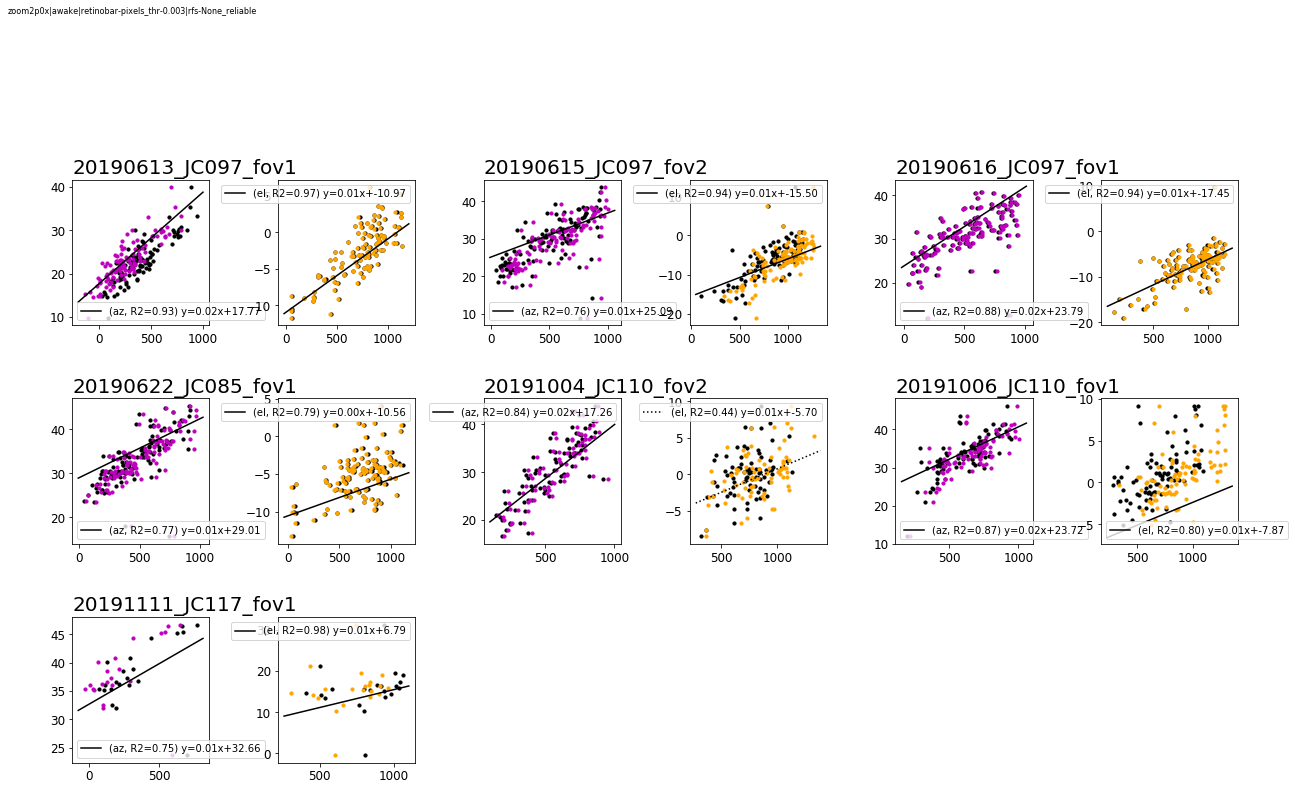

In [79]:
col_wrap = 6
cond_names = ['az', 'el']
cond_colors = ['m', 'orange']
markersize = 10

for rfname, rfdf_exp in rfdf.groupby(['experiment']):
    for visual_area, rfdf_vis in rfdf_exp.groupby(['visual_area']): #['V1', 'Lm', 'Li']:

        curr_fig_title = '%s: RFS (%s), Retino (magthr-%.3f)' % (visual_area, rfname, mag_thr)

        fig = plot_retino_scatter_by_fov(rfdf_vis, projdf, cond_colors=cond_colors, cond_names=cond_names,
                                    markersize=markersize, col_wrap=col_wrap)

        label_figure(fig, data_id)   
        pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.05, right=0.95)

        figname = '%s_%s_retinoscatter_%s' % (rfname, visual_area, figstr) 
        pl.savefig(os.path.join(by_session_dir, '%s.svg' % figname))

        print(by_session_dir, figname)

In [74]:
print(by_session_dir, figname)

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/scatter_by_session', 'compare_runs_retinograd_pixels_thr-0.003')


# Aggregate scatter metrics

In [55]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)



In [56]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [57]:
rfdf.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
19  0.631459  45.961738  34.231365  0.216454   1.111327   5.854219    JC089   
20  0.520312  39.363302  31.265255  5.491278  -0.359113  25.227100    JC089   
21  0.559490  31.689496  36.726462  6.074524   3.931988  24.304596    JC089   
22  0.585001  46.670332  36.780253  6.081151 -29.065480 -11.080597    JC089   
23  0.696801  45.149795  27.452993  0.127034  13.248381 -21.937449    JC089   

    cell              datakey experiment   ...           area datakey_ix  \
19    85  20190522_JC089_fov1        rfs   ...     895.024271          1   
20   115  20190522_JC089_fov1        rfs   ...     700.112194          1   
21   122  20190522_JC089_fov1        rfs   ...     662.077125          1   
22    71  20190522_JC089_fov1      rfs10   ...     976.494391          1   
23    89  20190522_JC089_fov1      rfs10   ...     705.114482          1   

   fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix   ml_pos   ap_pos  ml_proj  \
19  463.205           201    542.56           285   430.24  714.395 -174.648   
20  467.814           203   801.465           421  171.335  709.786  68.6981   
21  504.686           219   856.673           450  116.127  672.914  108.922   
22  433.246           188   415.011           218  557.789  744.354 -285.532   
23  668.305           290   489.256           257  483.544  509.295 -291.729   

    ap_proj  
19 -163.382  
20  78.7199  
21  118.211  
22 -273.293  
23 -282.889  

[5 rows x 27 columns]

In [58]:
projdf.head()

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
50  0.901562  2.499300     0.028963   az   0.635746        0.0   0.949506   
51  0.746420  3.354784     0.020363   el   8.556024        0.0   0.863956   
68  0.979097  3.561265     0.100937   az -45.122451        0.0   0.989493   
69  0.865969  1.405181     0.011212   el  -5.264790        0.0   0.930575   
70  0.962362  2.790341     0.055195   az  -0.788421        0.0   0.981000   

      retinorun            fov   session animalid              datakey  \
50  retino_run1  FOV1_zoom2p0x  20190522    JC089  20190522_JC089_fov1   
51  retino_run1  FOV1_zoom2p0x  20190522    JC089  20190522_JC089_fov1   
68  retino_run1  FOV3_zoom2p0x  20190527    JC092  20190527_JC092_fov3   
69  retino_run1  FOV3_zoom2p0x  20190527    JC092  20190527_JC092_fov3   
70  retino_run1  FOV1_zoom2p0x  20190528    JC092  20190528_JC092_fov1   

   visual_area     retinoid  \
50          Li  analysis002   
51          Li  analysis002   
68          Li  analysis002   
69          Li  analysis002   
70          Li  analysis002   

                                                fpath  abs_coef  cortical_mag  \
50  /n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0...  0.028963     34.526839   
51  /n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0...  0.020363     49.108692   
68  /n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0...  0.100937      9.907182   
69  /n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0...  0.011212     89.191941   
70  /n/coxfs01/2p-data/JC092/20190528/FOV1_zoom2p0...  0.055195     18.117744   

                          retinokey  
50  20190522_JC089_fov1_retino_run1  
51  20190522_JC089_fov1_retino_run1  
68  20190527_JC092_fov3_retino_run1  
69  20190527_JC092_fov3_retino_run1  
70  20190528_JC092_fov1_retino_run1

In [59]:
projdf[projdf['R2']>=0.8]


R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
50   0.901562  2.499300     0.028963   az   0.635746        0.0   0.949506   
68   0.979097  3.561265     0.100937   az -45.122451        0.0   0.989493   
69   0.865969  1.405181     0.011212   el  -5.264790        0.0   0.930575   
70   0.962362  2.790341     0.055195   az  -0.788421        0.0   0.981000   
54   0.971651  4.045375     0.086688   az   2.078897        0.0   0.985723   
55   0.840756  3.038677     0.026144   el -24.198734        0.0   0.916928   
82   0.972491  2.037660     0.036569   az  -9.504906        0.0   0.986150   
83   0.886375  3.515216     0.030803   el -17.891425        0.0   0.941475   
84   0.821225  6.609731     0.042727   az -12.128063        0.0   0.906215   
85   0.906554  3.096527     0.030660   el -19.218406        0.0   0.952131   
62   0.949854  4.620945     0.071945   az -39.349226        0.0   0.974605   
86   0.960582  4.343107     0.076231   az -36.107319        0.0   0.980093   
87   0.922607  2.100972     0.025849   el  -3.773853        0.0   0.960525   
66   0.993042  1.871423     0.078159   az -19.595909        0.0   0.996515   
97   0.991841  1.009066     0.044015   el -13.492350        0.0   0.995912   
99   0.868390  1.814419     0.016680   el   7.945579        0.0   0.931875   
103  0.978551  0.983406     0.023749   el   7.887749        0.0   0.989217   
104  0.904675  3.713707     0.041065   az -20.652341        0.0   0.951144   
105  0.973853  0.547798     0.011865   el   0.457571        0.0   0.986840   
106  0.869041  3.111238     0.031155   az -13.696996        0.0   0.932224   
116  0.988740  1.764074     0.055904   az -40.443482        0.0   0.994354   
117  0.990689  0.701564     0.025859   el   2.572678        0.0   0.995334   
118  0.974480  2.711279     0.057053   az -45.815744        0.0   0.987158   
119  0.923728  1.923477     0.021750   el  -6.103929        0.0   0.961108   
4    0.991063  1.404291     0.050939   az  42.383800        0.0   0.995521   
8    0.963970  4.018243     0.073462   az  49.656641        0.0   0.981820   
9    0.990914  0.925833     0.032127   el   4.666290        0.0   0.995447   
11   0.935996  1.217668     0.014499   el  -3.073134        0.0   0.967469   
16   0.944550  4.422250     0.063945   az  63.642712        0.0   0.971880   
17   0.991186  0.732534     0.023811   el  -6.020502        0.0   0.995583   
..        ...       ...          ...  ...        ...        ...        ...   
22   0.932360  4.020459     0.052401   az  57.349610        0.0   0.965588   
23   0.987114  0.803152     0.021022   el -10.016816        0.0   0.993536   
80   0.955981  1.574913     0.025954   az  37.801216        0.0   0.977743   
81   0.954744  1.286870     0.017753   el -11.170420        0.0   0.977110   
64   0.984867  2.944137     0.083791   az  49.851246        0.0   0.992404   
65   0.859201  2.633447     0.021886   el   9.403484        0.0   0.926931   
90   0.994419  1.840174     0.083632   az  60.103841        0.0   0.997206   
100  0.969217  3.968813     0.077274   az  65.125830        0.0   0.984488   
109  0.994101  0.325130     0.012436   el  -6.176934        0.0   0.997046   
114  0.928911  1.907024     0.024895   az  43.764491        0.0   0.963800   
6    0.970451  1.975928     0.035081   az  21.188475        0.0   0.985114   
26   0.969593  1.329378     0.027163   az   1.843966        0.0   0.984679   
27   0.991331  0.463236     0.015533   el  -9.152357        0.0   0.995656   
32   0.980412  1.133761     0.028921   az  -0.911300        0.0   0.990158   
33   0.996759  0.184275     0.010772   el  -0.442980        0.0   0.998378   
34   0.969838  1.530477     0.032389   az  -0.984265        0.0   0.984804   
35   0.992780  0.269218     0.011260   el  -2.273032        0.0   0.996384   
42   0.948758  1.103196     0.016687   az   8.058423        0.0   0.974042   
43   0.857723  1.054133     0.008271   el -20.621027        0.0   0.926133   
72   0.929008  1.640767     0.021

In [60]:
rfname = 'rfs10'
retino_r2=0.8
min_ncells=5

curr_gradients = projdf[projdf['R2']>=retino_r2].copy()
#curr_rfs = rfdf[rfdf['experiment']==rfname].copy()


not_enough_cells_fit = []
bad_fits = []
d_list = []
for (visual_area, datakey, rfname), rfs_ in rfdf.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:
    if rfs_.shape[0] < min_ncells:
        print("--- too few cells (min%i), %s" % (min_ncells, datakey))
        not_enough_cells_fit.append(datakey)
        continue
    if datakey not in curr_gradients['datakey'].unique():
        print("---bad gradient, %s" % datakey)
        continue

    # Get retino gradient
    #retinorun = curr_gradients[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()
    ret_ = curr_gradients[curr_gradients['datakey']==datakey].copy()
    
    for cond, ret_cond in ret_.groupby(['cond']):
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'
        max_degrees = screen['azimuth_deg'] if cond=='az' else screen['altitude_deg']
        max_fovdist = 1177 if cond=='ap' else 972.
        
        # Get RF fit info
        proj_locs = np.array(rfs_['%s_proj' % xname].values)
        rf_locs = np.array(rfs_[yname].values)

        # Get dist to line:
        slope = float(ret_cond['coefficient'])
        intercept = float(ret_cond['intercept'])
        r2 = float(ret_cond['R2'])
        predicted_rf_locs = slope*proj_locs + intercept

        deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
        deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees]
        dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
        dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist]
        keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
        n_pts = len(keep_ixs)
        if (n_pts)==0:
            bad_fits.append((datakey, cond))
            continue
            
        if any(np.isnan(dist_sc)):
            print(visual_area, datakey, r2)
        if any(np.isnan(deg_sc)):
            print(visual_area, datakey, r2)
        tmpd=pd.DataFrame({'deg_scatter': deg_sc[keep_ixs],
                           'dist_scatter': dist_sc[keep_ixs],
                           'measured_rf': rf_locs[keep_ixs],
                           'predicted_rf': predicted_rf_locs[keep_ixs],
                           'measured_loc': proj_locs[keep_ixs],
                           'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                           'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                           'axis': [cond for _ in np.arange(0, n_pts)],
                           'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                           'datakey': [datakey for _ in np.arange(0, n_pts)],
                           'rfname': [rfname for _ in np.arange(0, n_pts)]
                     })
        d_list.append(tmpd)
scatdf = pd.concat(d_list, axis=0)
print(scatdf.shape)
scatdf.head()


--- too few cells (min5), 20190522_JC089_fov1
---bad gradient, 20190602_JC091_fov1
---bad gradient, 20190602_JC091_fov1
---bad gradient, 20190606_JC091_fov1
---bad gradient, 20190607_JC091_fov1
---bad gradient, 20191003_JC111_fov1
--- too few cells (min5), 20191012_JC113_fov1
---bad gradient, 20191105_JC117_fov1
--- too few cells (min5), 20191111_JC120_fov1
---bad gradient, 20190602_JC080_fov2
--- too few cells (min5), 20191111_JC117_fov2
---bad gradient, 20190420_JC076_fov1
---bad gradient, 20190622_JC085_fov1
---bad gradient, 20190622_JC085_fov1
(3420, 11)


axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190522_JC089_fov1    21.431368    739.957399     -285.532   
1   az  20190522_JC089_fov1    21.061976    727.203431     -291.729   
2   az  20190522_JC089_fov1    13.761406    475.137852     -63.8608   
3   az  20190522_JC089_fov1     1.921464     66.342063      40.0868   
4   az  20190522_JC089_fov1     8.503079    293.584445     -22.8635   

   measured_rf  predicted_loc predicted_rf  retino_R2 rfname visual_area  
0   -29.065480   -1025.489421     -7.63411   0.901562  rfs10          Li  
1    13.248381     435.474412     -7.81359   0.901562  rfs10          Li  
2    12.547553     411.277051     -1.21385   0.901562  rfs10          Li  
3     3.718242     106.428844      1.79678   0.901562  rfs10          Li  
4     8.476630     270.720964   -0.0264489   0.901562  rfs10          Li

In [61]:
print("Not enough cells passed RF fit:", not_enough_cells_fit)
print("Bad fits for predicted pos/rf:", bad_fits)

('Not enough cells passed RF fit:', ['20190522_JC089_fov1', '20191012_JC113_fov1', '20191111_JC120_fov1', '20191111_JC117_fov2'])
('Bad fits for predicted pos/rf:', [])


0.8


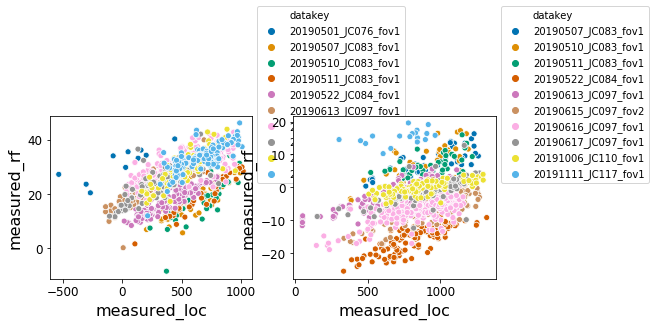

In [62]:
print(retino_r2)
plotdf = scatdf[scatdf['retino_R2']>retino_r2].copy()
sns.set_palette('colorblind')
fig, axn = pl.subplots(1,2, figsize=(8,3))
visual_area = 'V1'

vdf = plotdf[plotdf['visual_area']==visual_area]

for ax, (cond, vdf_ax) in zip(axn.flat, vdf.groupby(['axis'])):

    sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                    hue='datakey')
    
    ax.legend(bbox_to_anchor=(1., 1.7))

In [63]:
scatdf['retino_R2'].min()

0.80428503971723098

In [64]:
#retino_thr = 0.9
#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

mean_scatter = scatdf.groupby(['visual_area', 'datakey', 'rfname', 'axis']).mean().reset_index()
mean_scatter.head()

print(mean_scatter.shape)
#print(mean_values[mean_values['retino_R2']>0.9].shape)
mean_scatter.head()

(76, 9)


visual_area              datakey rfname axis  deg_scatter  dist_scatter  \
0          Li  20190522_JC089_fov1  rfs10   az    13.335859    460.445038   
1          Li  20190527_JC092_fov3  rfs10   az     4.436619     43.954395   
2          Li  20190527_JC092_fov3  rfs10   el     4.840973    431.775811   
3          Li  20190528_JC092_fov1  rfs10   az     5.211220     94.415554   
4          Li  20190605_JC090_fov1  rfs10   az    12.020167    138.660025   

   measured_rf  predicted_loc  retino_R2  
0     1.785065      39.682370   0.901562  
1     5.861071     505.103050   0.979097  
2    -5.772041     -45.242686   0.865969  
3    11.936031     230.538367   0.962362  
4    28.172636     301.007347   0.971651

In [65]:
mean_scatter.tail()

visual_area              datakey rfname axis  deg_scatter  dist_scatter  \
71          V1  20191006_JC110_fov1    rfs   az     2.133275    125.880957   
72          V1  20191006_JC110_fov1    rfs   el     2.987850    545.257001   
73          V1  20191006_JC110_fov1  rfs10   az     2.759607    162.839711   
74          V1  20191006_JC110_fov1  rfs10   el     3.029004    552.767252   
75          V1  20191111_JC117_fov1  rfs10   el     2.465466    283.345695   

    measured_rf  predicted_loc  retino_R2  
71    33.398244     571.196679   0.869042  
72     0.049870    1444.574256   0.804285  
73    33.453957     574.484197   0.869042  
74    -0.144574    1409.089957   0.804285  
75    15.310761     978.842892   0.984072

In [66]:
currcols=['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

In [ ]:
print(retino_r2)

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'aggr_scatter_ALL_fovmeans_retino-grad-R2-0.80__rfs_None_retino_pixels_thr-0.003')


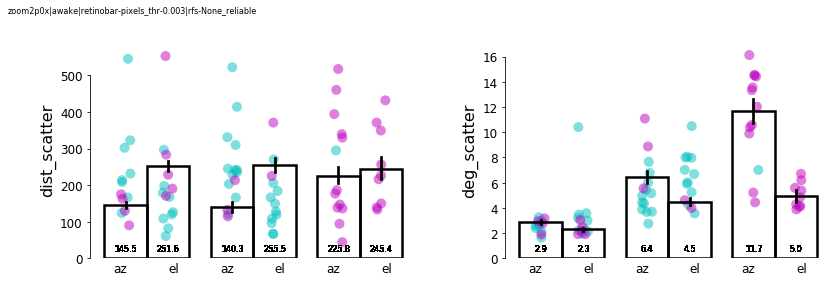

In [68]:
plot_cells=False

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

plot_str = '' if plot_cells else 'fovmeans'

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, data=scatdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs'], 
                  dodge=True, ax=ax, size=10, zorder=0, edgecolor=['c', 'c', 'c',], facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': 'c', 'az': 'c'}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
                  dodge=True, ax=ax, size=10, zorder=0, edgecolor=['c', 'c', 'c',], facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': 'm', 'az': 'm'}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    ax.legend_.remove()
#     sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
#                   dodge=True, ax=ax, size=10, zorder=0, edgecolor='none', color='m', alpha=0.5,
#                   order=['V1', 'Lm', 'Li'])
    
#     sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
#                   dodge=True, ax=ax, size=10, zorder=0, color='c', 
#                   order=['V1', 'Lm', 'Li'])

    scatdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f')
    #scatdf[scatdf['rfname']=='rfs'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='m')
    #scatdf[scatdf['rfname']=='rfs10'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='c')

    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    #ax.legend_.remove()
    
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

figname = 'aggr_scatter_ALL_%s_retino-grad-R2-%.2f__%s' % (plot_str, retino_r2, figstr )
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'aggr_scatter_ALL_fovmeans_retino-grad-R2-0.80__rfs_None_retino_pixels_thr-0.003')


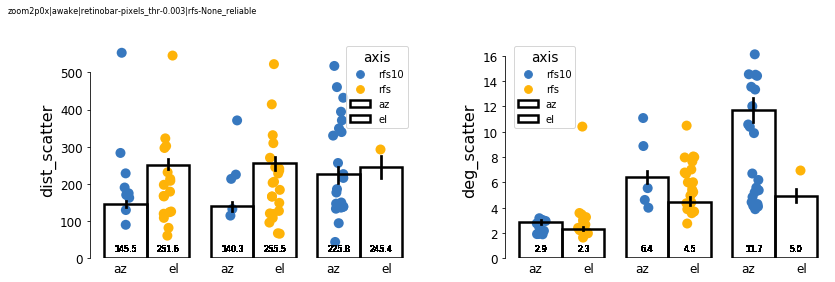

In [103]:
retino_thr = 0.5
plot_cells=False

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

plot_str = '' if plot_cells else 'fovmeans'

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, data=scatdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    
    if plot_cells:
        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=scatdf, 
                      dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                      order=['V1', 'Lm', 'Li'])
    else:
#         sns.stripplot(x='visual_area', y=plotter, hue='rfname', data=mean_scatter, 
#                       dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
#                       order=['V1', 'Lm', 'Li'])
        sns.stripplot(x='visual_area', y=plotter, hue='rfname', data=mean_scatter, 
                      dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                      order=['V1', 'Lm', 'Li'])

    scatdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    #ax.legend_.remove()
    
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

figname = 'aggr_scatter_ALL_%s_retino-grad-R2-%.2f__%s' % (plot_str, retino_r2, figstr )
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [397]:
scatdf.head()

axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190522_JC089_fov1    21.431368    739.957399     -285.532   
1   az  20190522_JC089_fov1    21.061976    727.203431     -291.729   
2   az  20190522_JC089_fov1    13.761406    475.137852     -63.8608   
3   az  20190522_JC089_fov1     1.921464     66.342063      40.0868   
4   az  20190522_JC089_fov1     8.503079    293.584445     -22.8635   

   measured_rf  predicted_loc predicted_rf  retino_R2 visual_area  
0   -29.065480   -1025.489421     -7.63411   0.901562          Li  
1    13.248381     435.474412     -7.81359   0.901562          Li  
2    12.547553     411.277051     -1.21385   0.901562          Li  
3     3.718242     106.428844      1.79678   0.901562          Li  
4     8.476630     270.720964   -0.0264489   0.901562          Li

In [107]:
scatterfov_dir = os.path.join(dst_dir, 'example_scatter_fovs')
if not os.path.exists(scatterfov_dir):
    os.makedirs(scatterfov_dir)
print(scatterfov_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/example_scatter_fovs


((5, 11), (2, 18))
((80, 11), (2, 18))
((7, 11), (2, 18))
((34, 11), (2, 18))
((76, 11), (2, 18))
((80, 11), (2, 18))
((99, 11), (2, 18))
((22, 11), (2, 18))
((46, 11), (2, 18))
((18, 11), (2, 18))
((12, 11), (2, 18))
((28, 11), (2, 18))
((24, 11), (2, 18))
((28, 11), (2, 18))
((40, 11), (2, 18))
((15, 11), (2, 18))
((72, 11), (2, 18))
((11, 11), (2, 18))
((61, 11), (2, 18))
((140, 11), (2, 18))
((12, 11), (2, 18))
((101, 11), (2, 18))
((38, 11), (2, 18))
((46, 11), (2, 18))
((73, 11), (2, 18))
((114, 11), (2, 18))
((28, 11), (2, 18))
((55, 11), (2, 18))
((18, 11), (2, 18))
((11, 11), (2, 18))
((18, 11), (2, 18))
((41, 11), (2, 18))
((11, 11), (2, 18))
((112, 11), (2, 18))
((65, 11), (2, 18))
((87, 11), (2, 18))
((248, 11), (2, 18))
((134, 11), (2, 18))
((214, 11), (2, 18))
((115, 11), (2, 18))
((203, 11), (2, 18))
((260, 11), (2, 18))
((177, 11), (2, 18))
((78, 11), (2, 18))
((92, 11), (2, 18))
((153, 11), (2, 18))
((18, 11), (2, 18))


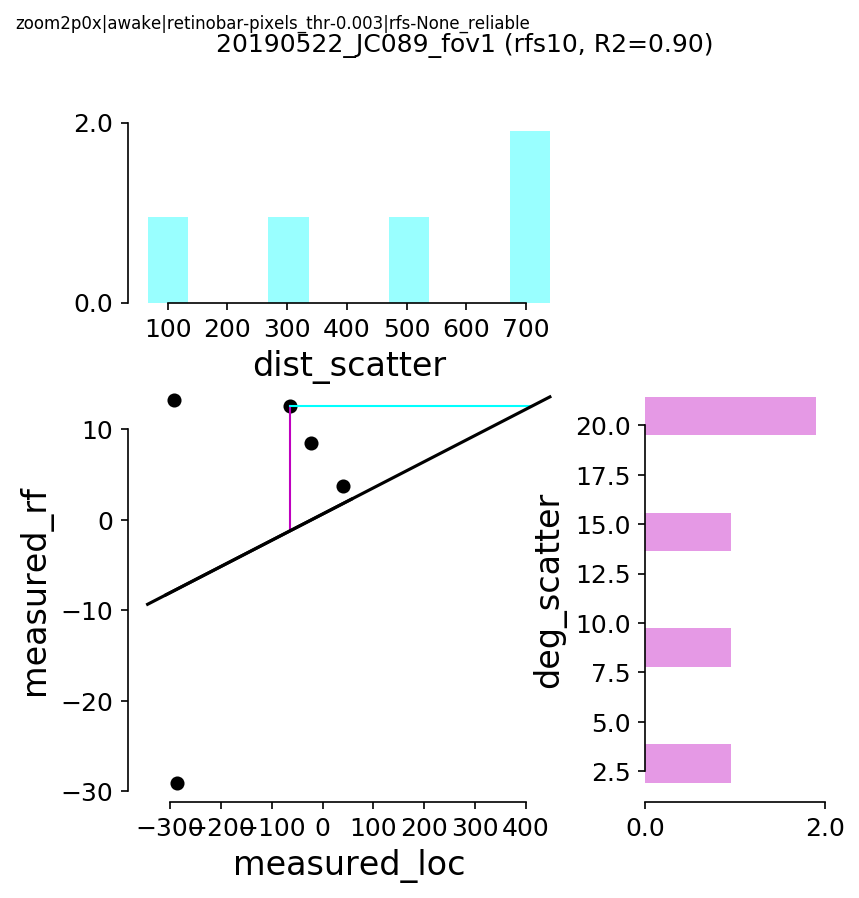

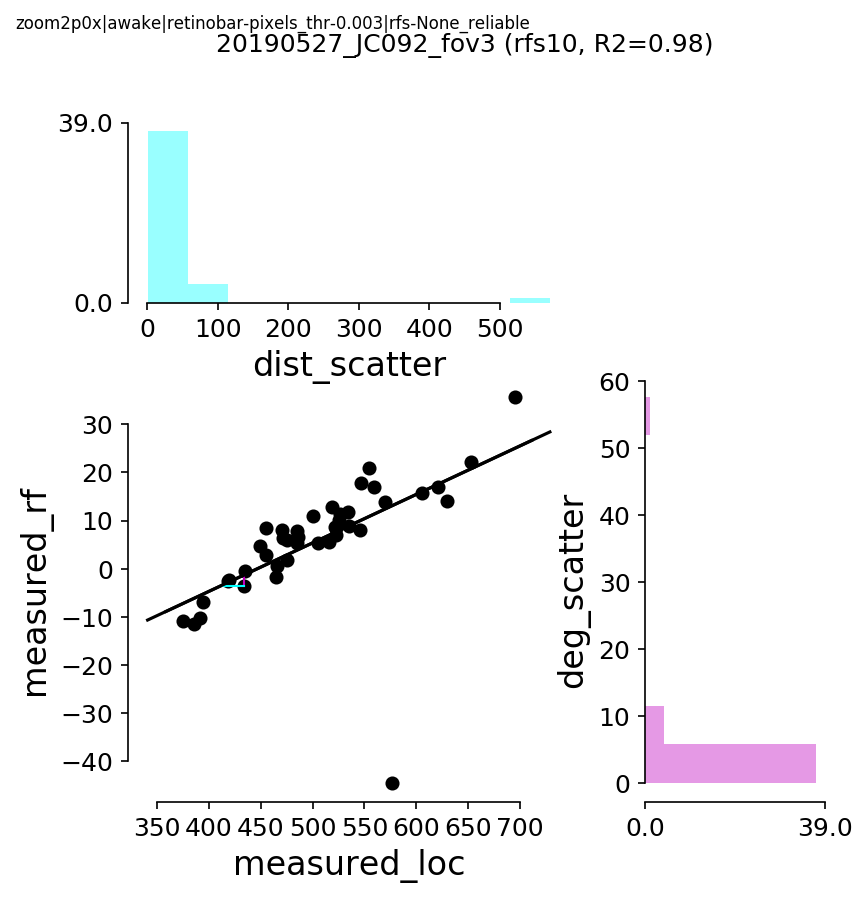

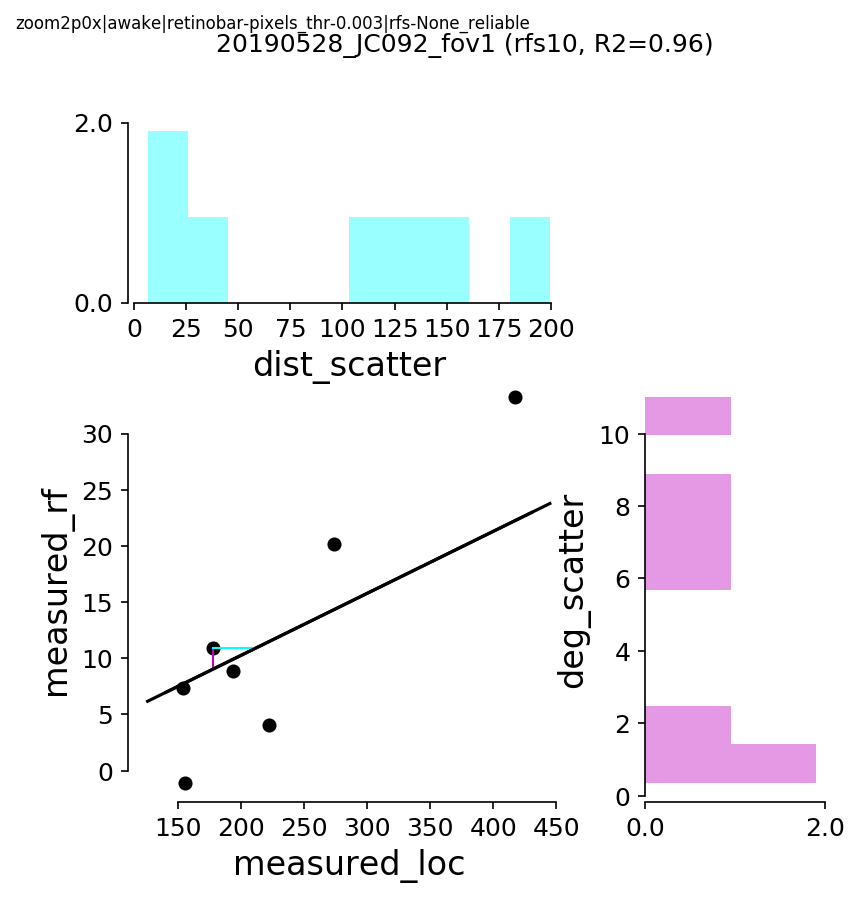

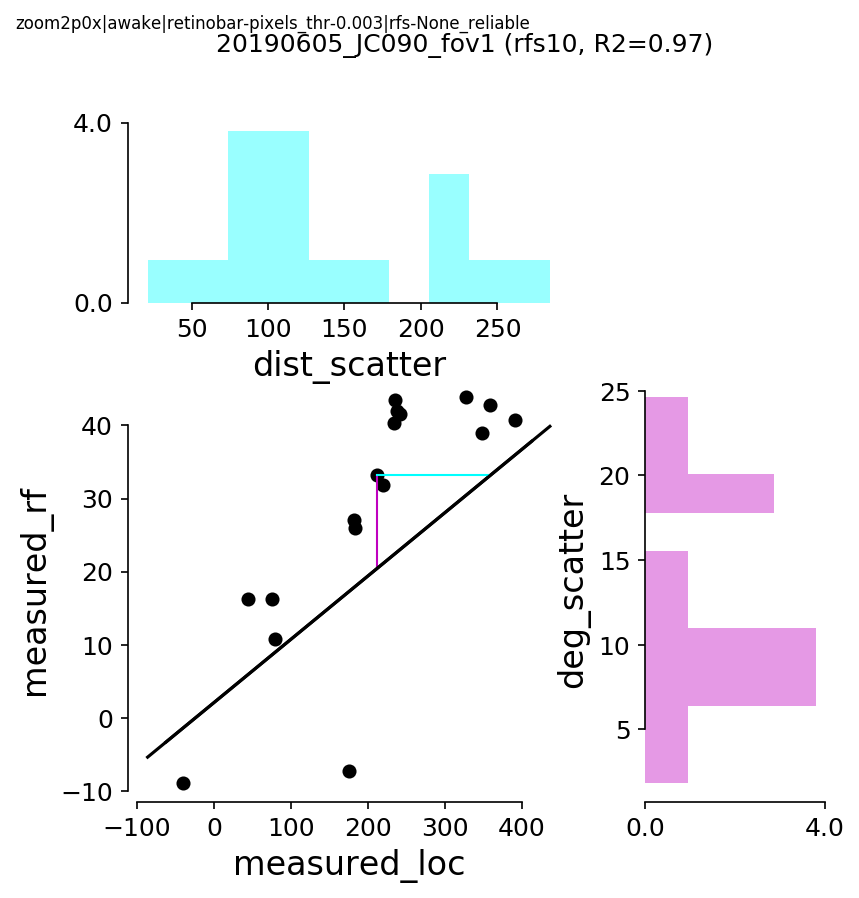

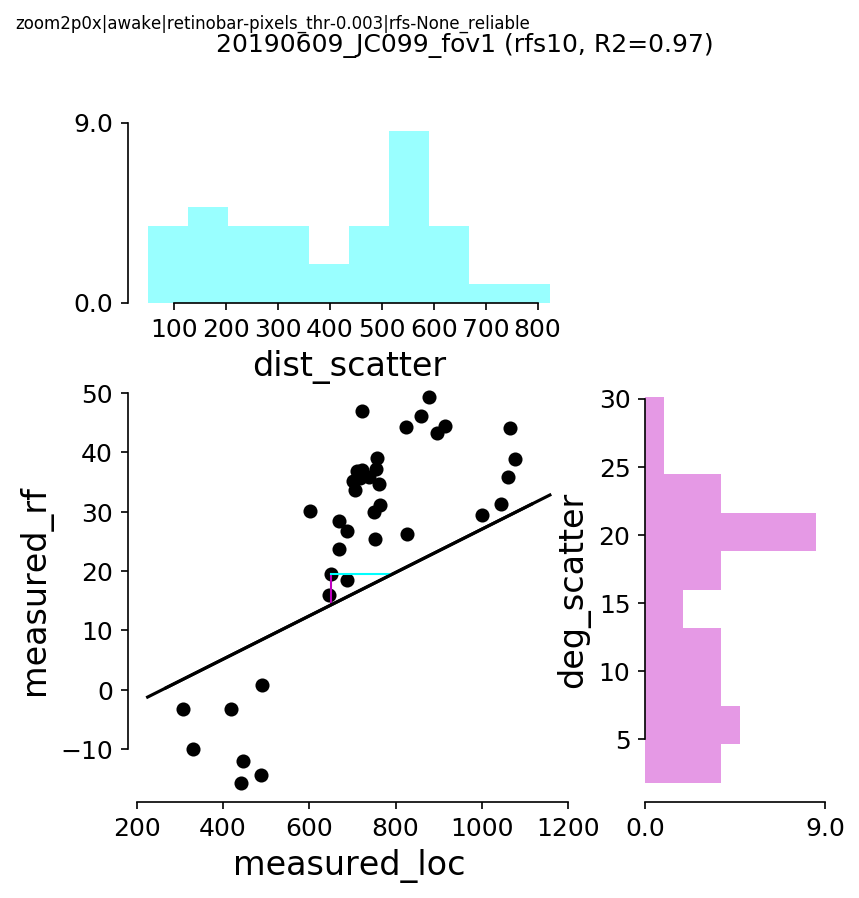

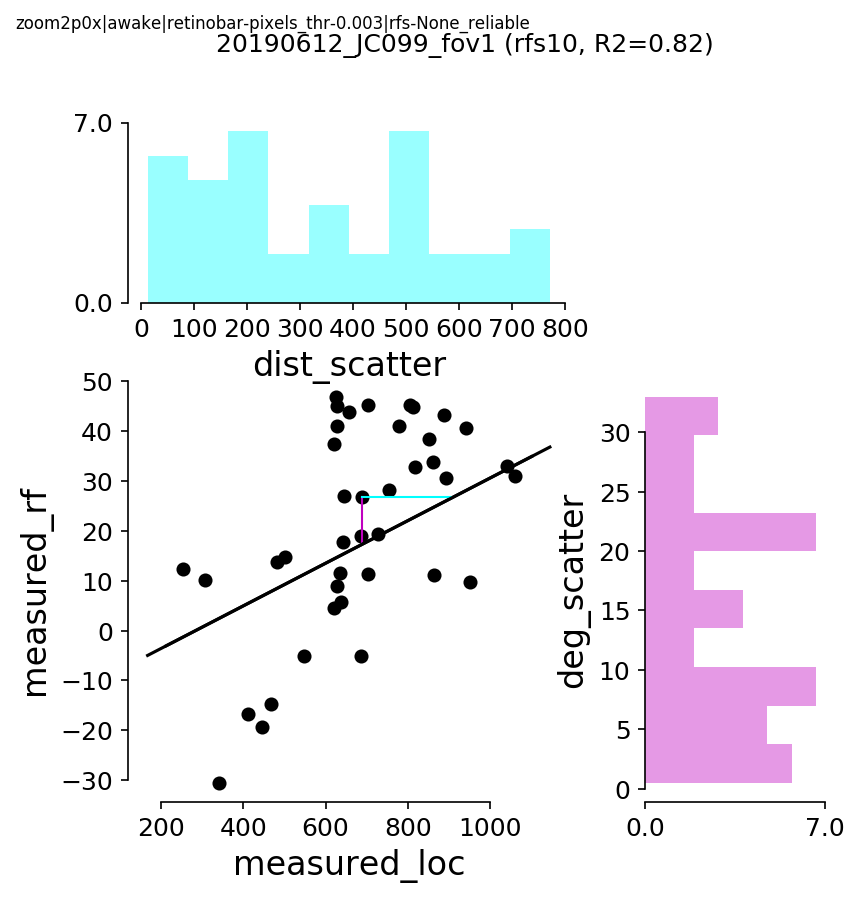

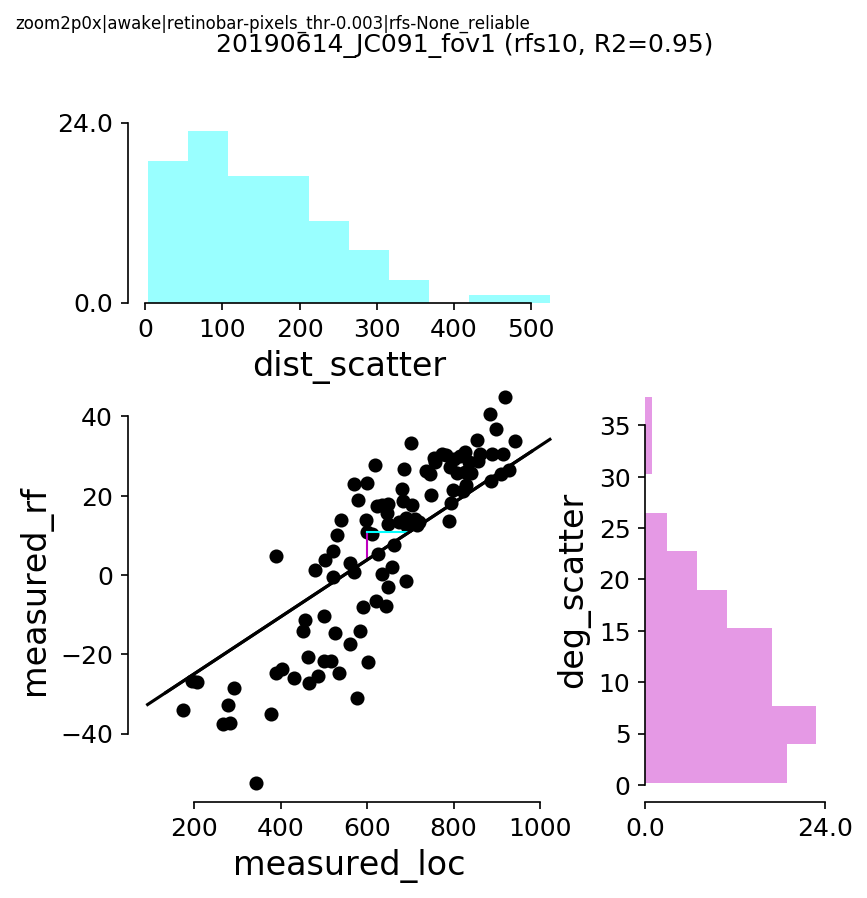

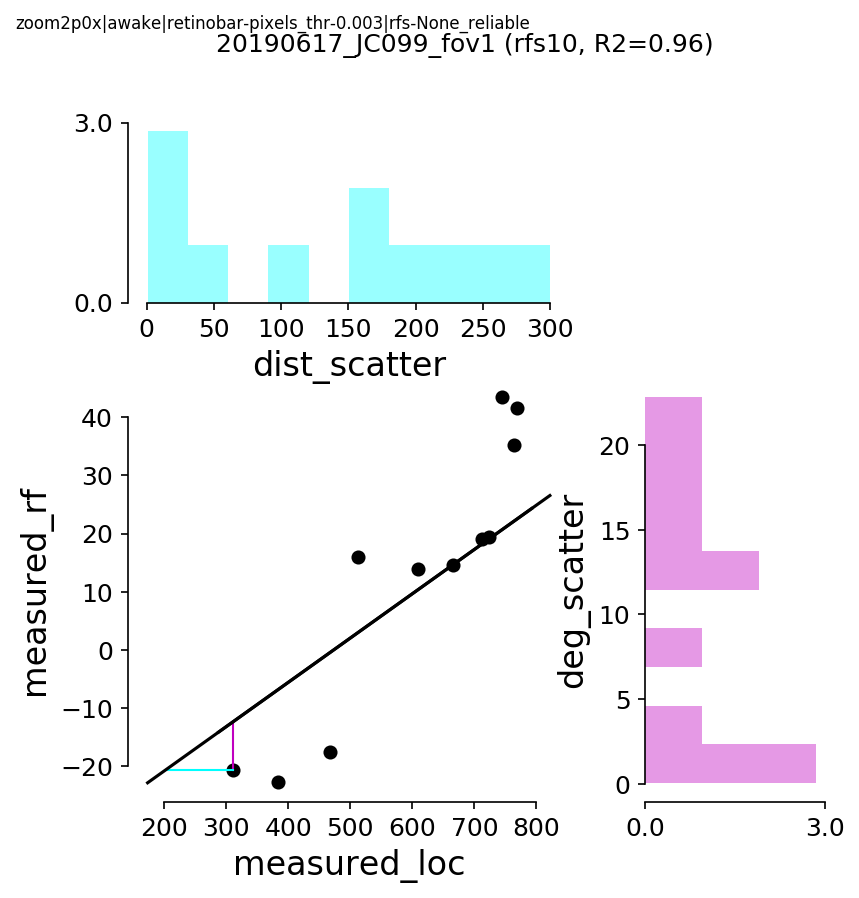

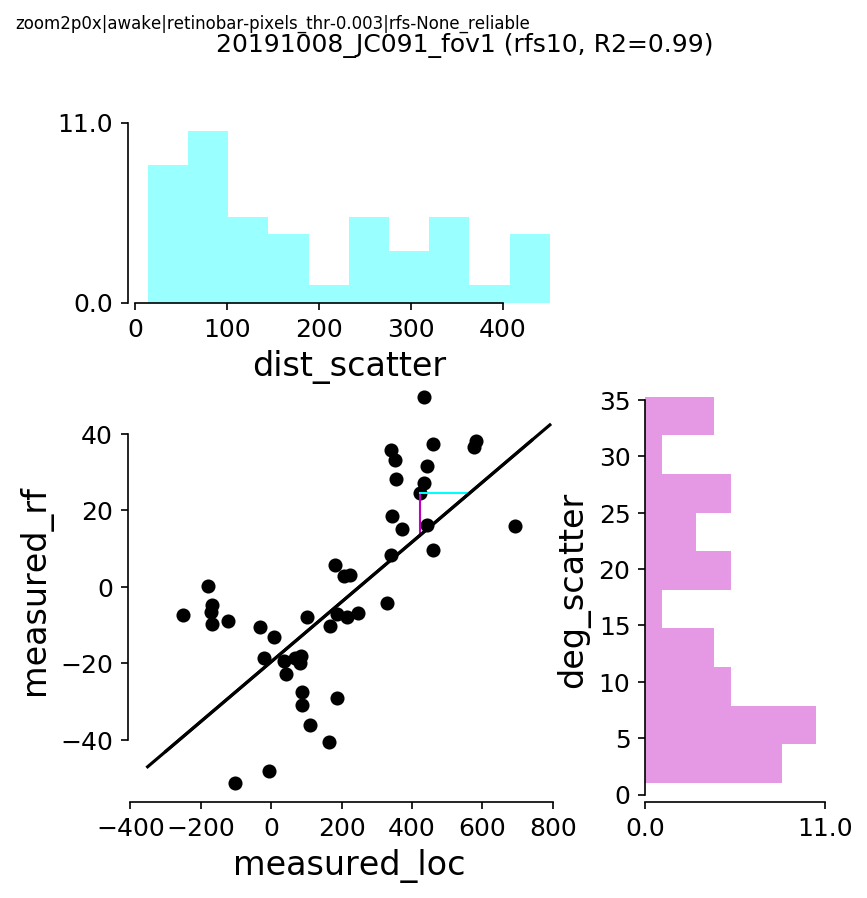

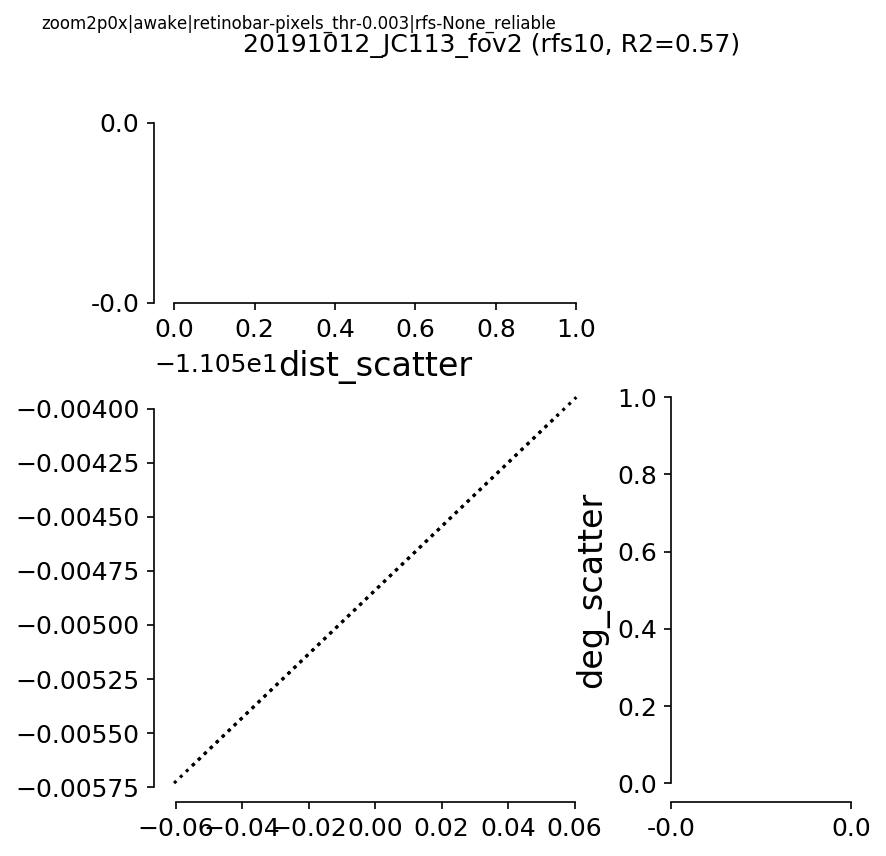

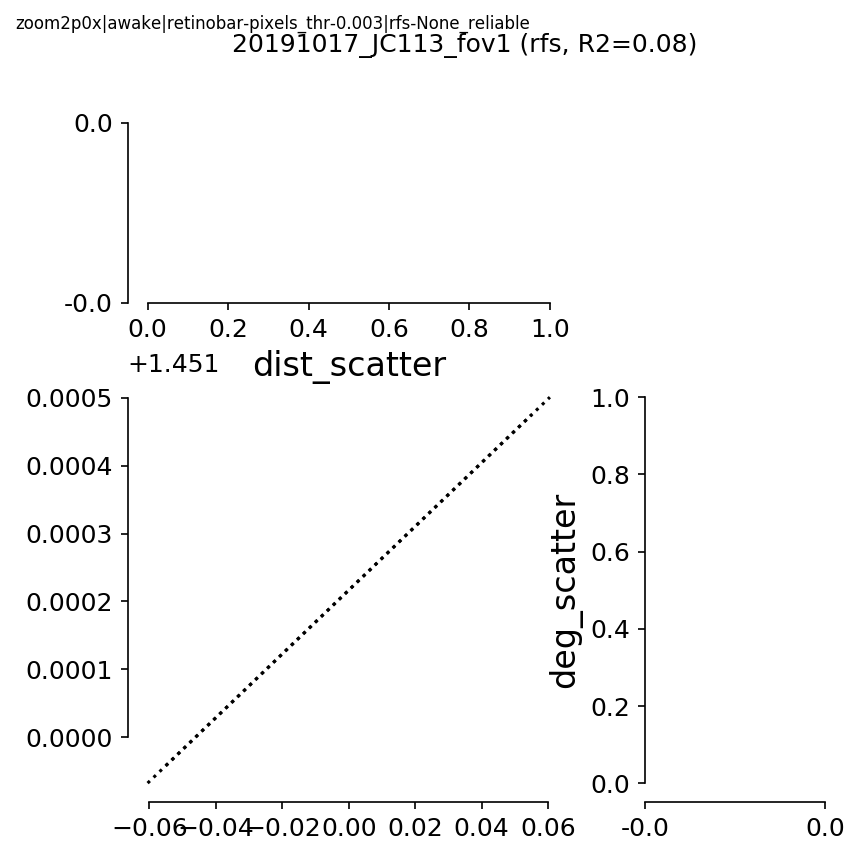

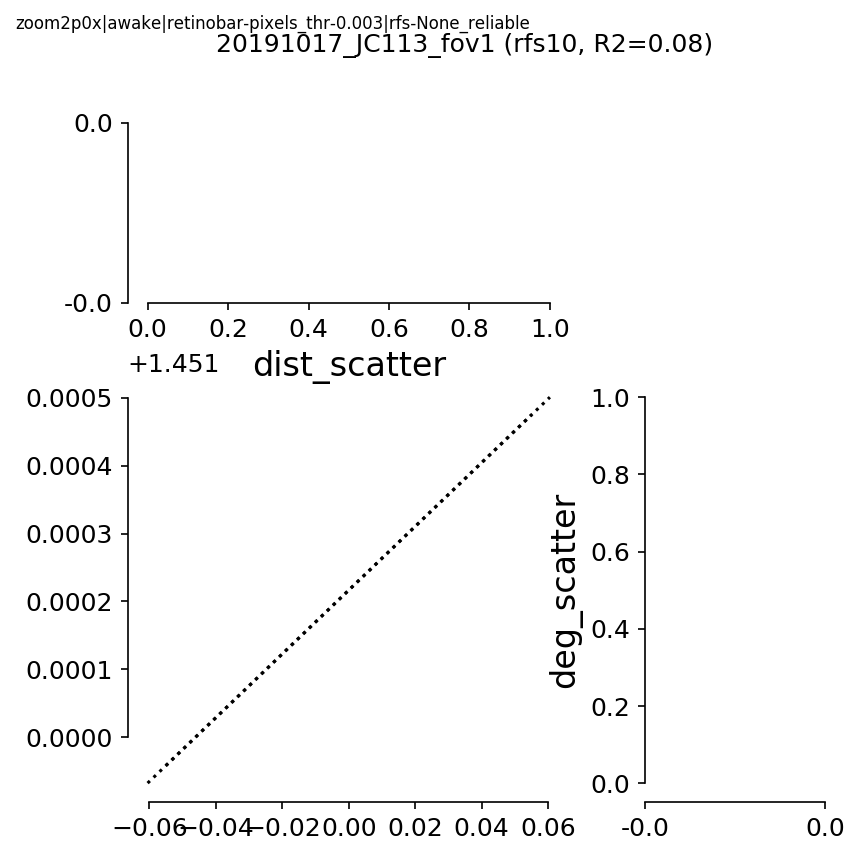

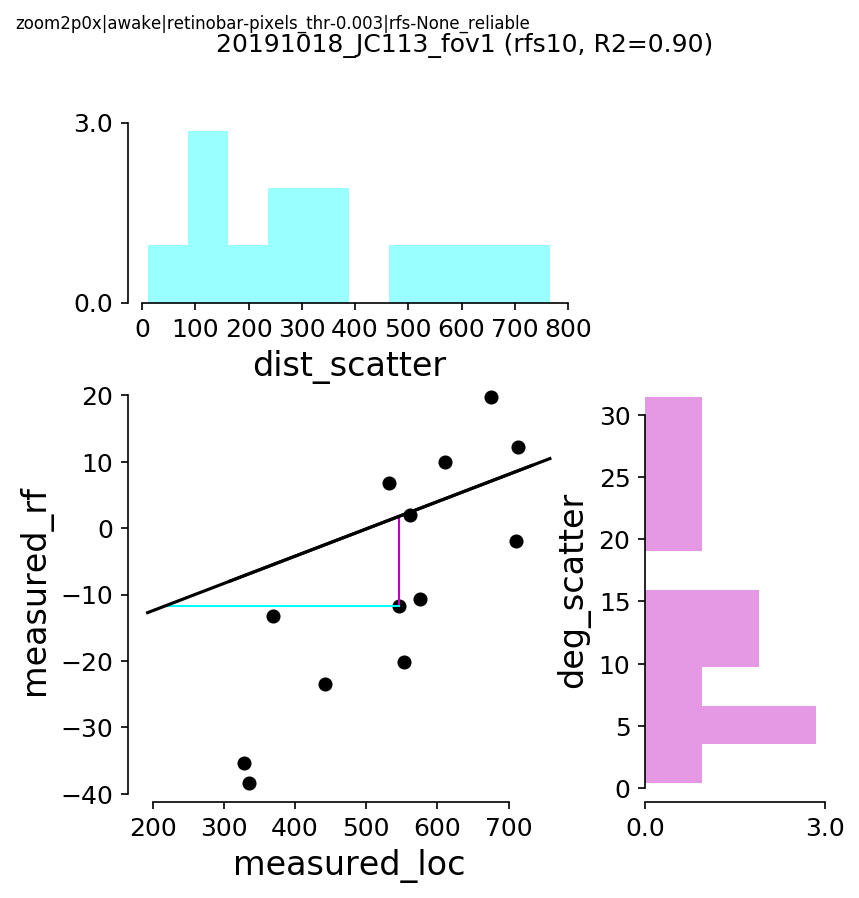

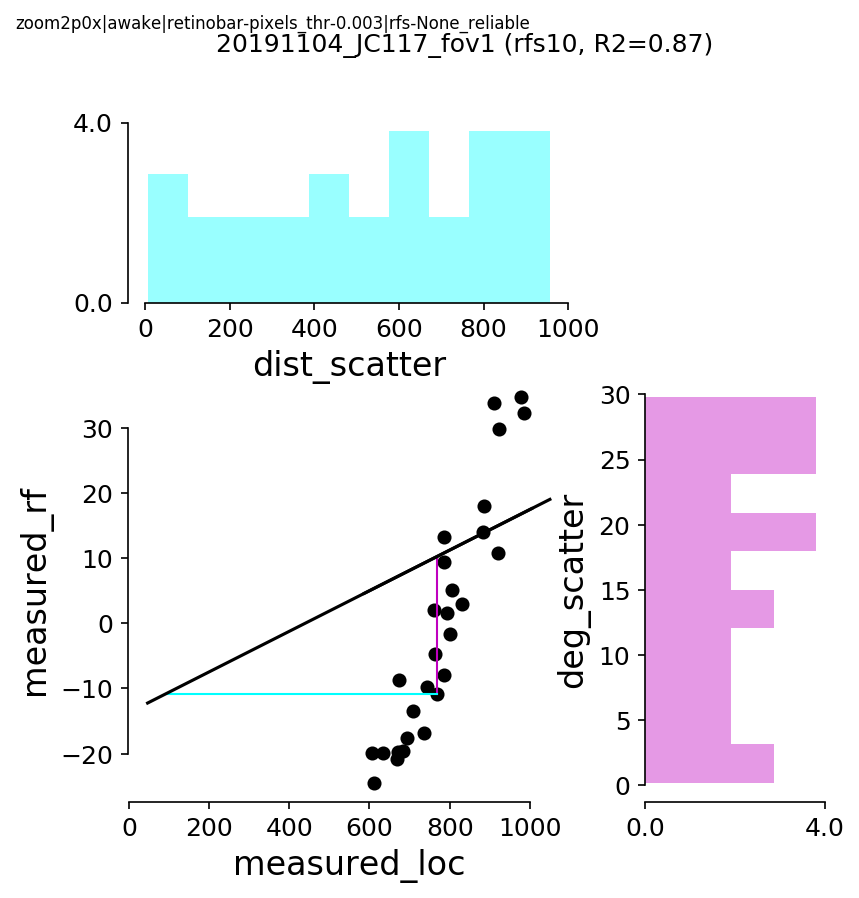

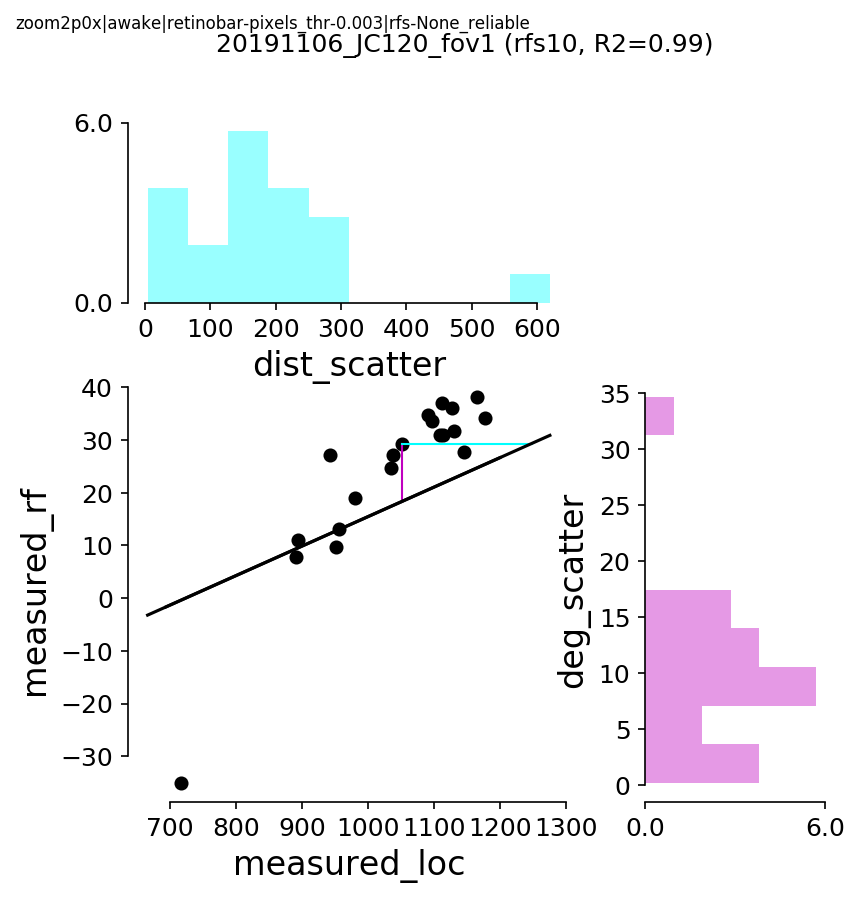

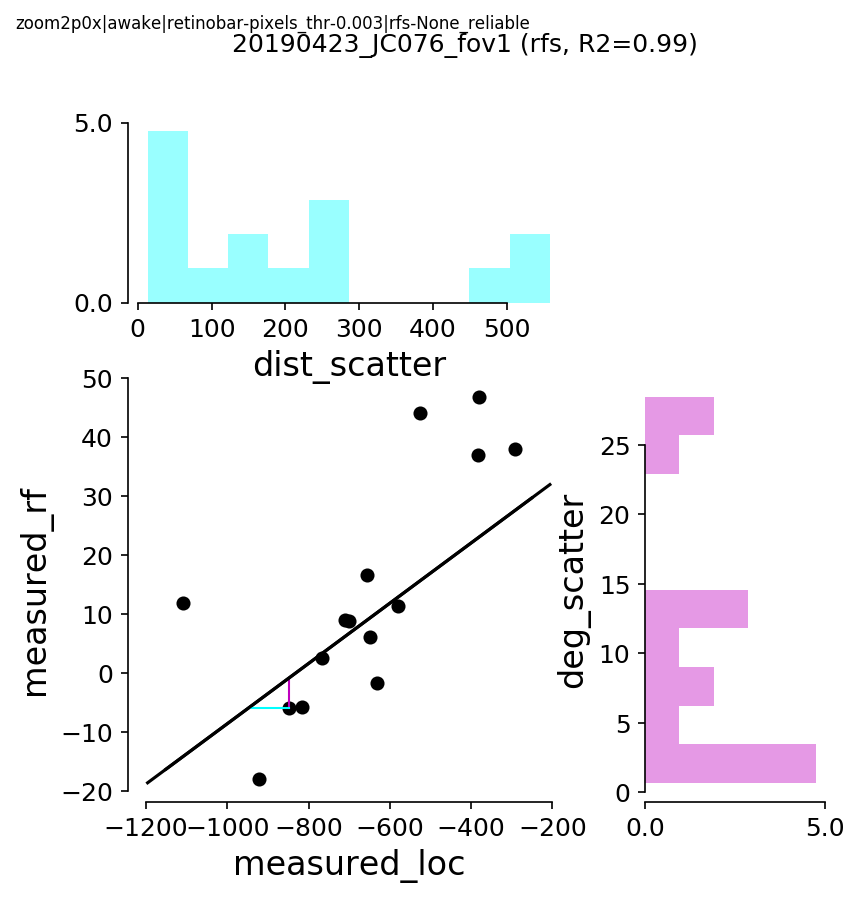

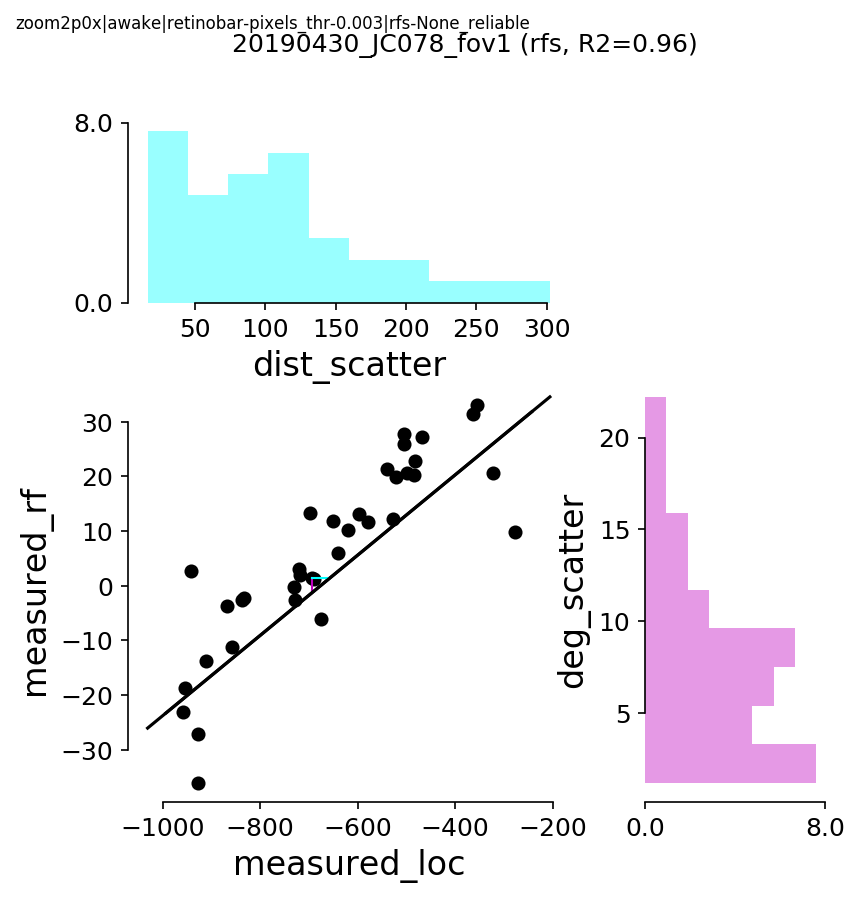

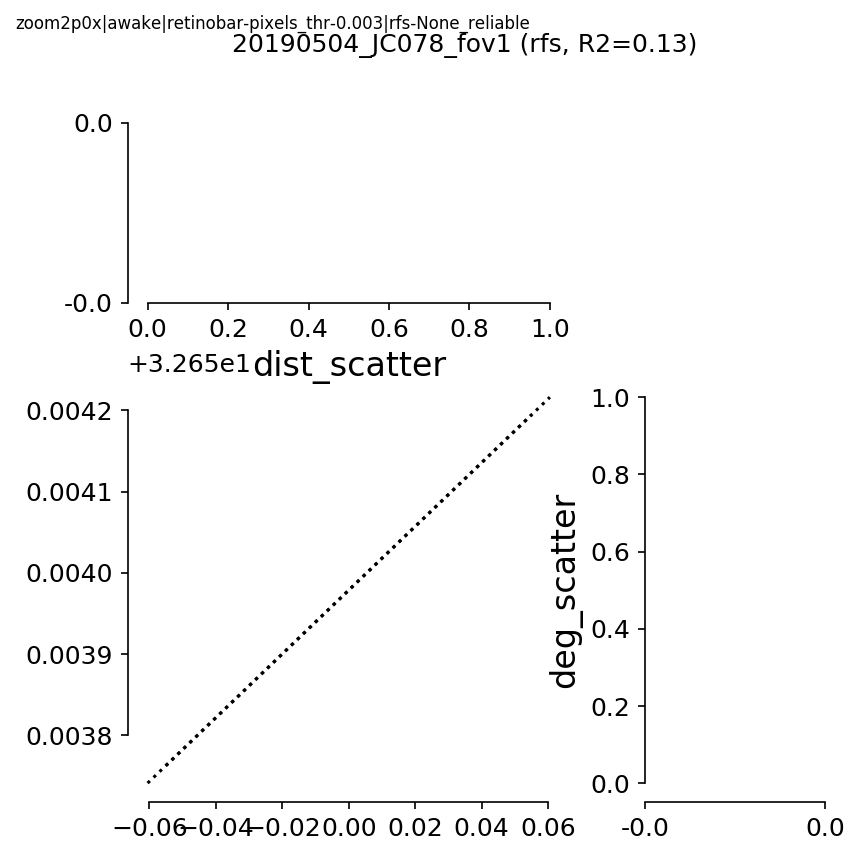

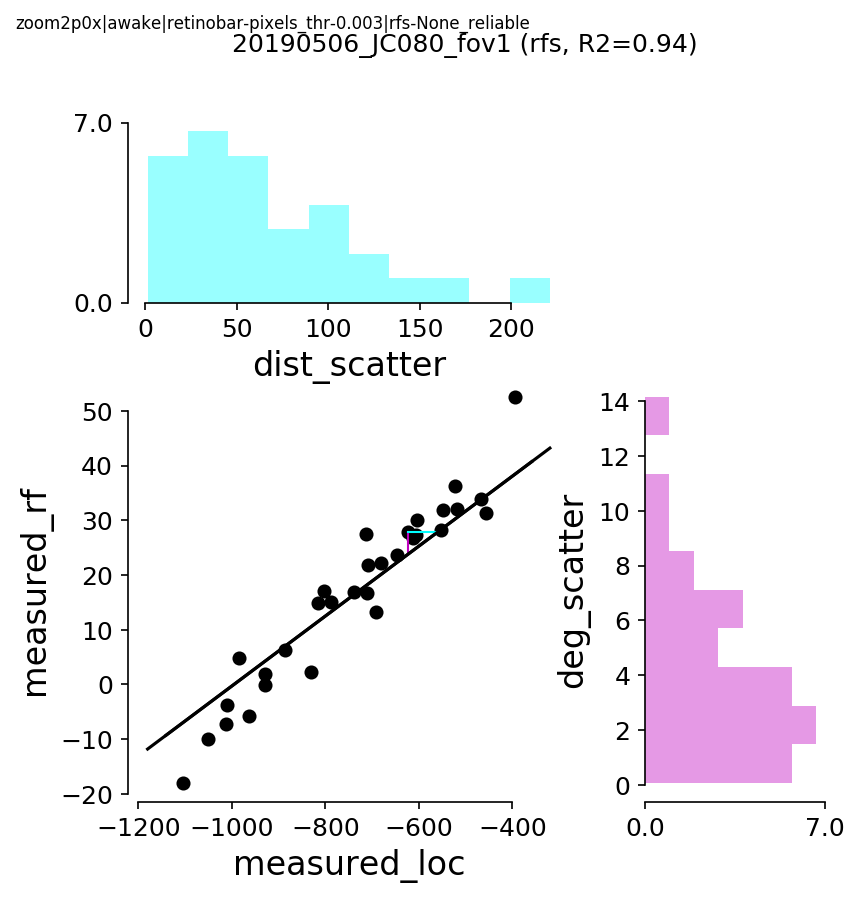

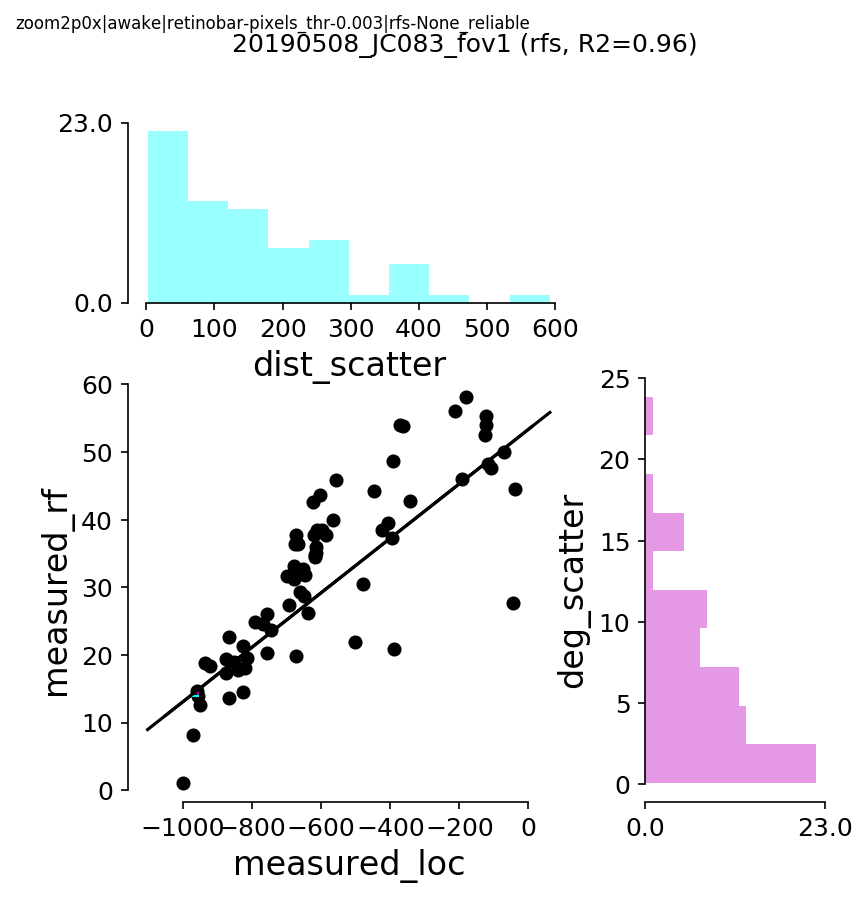

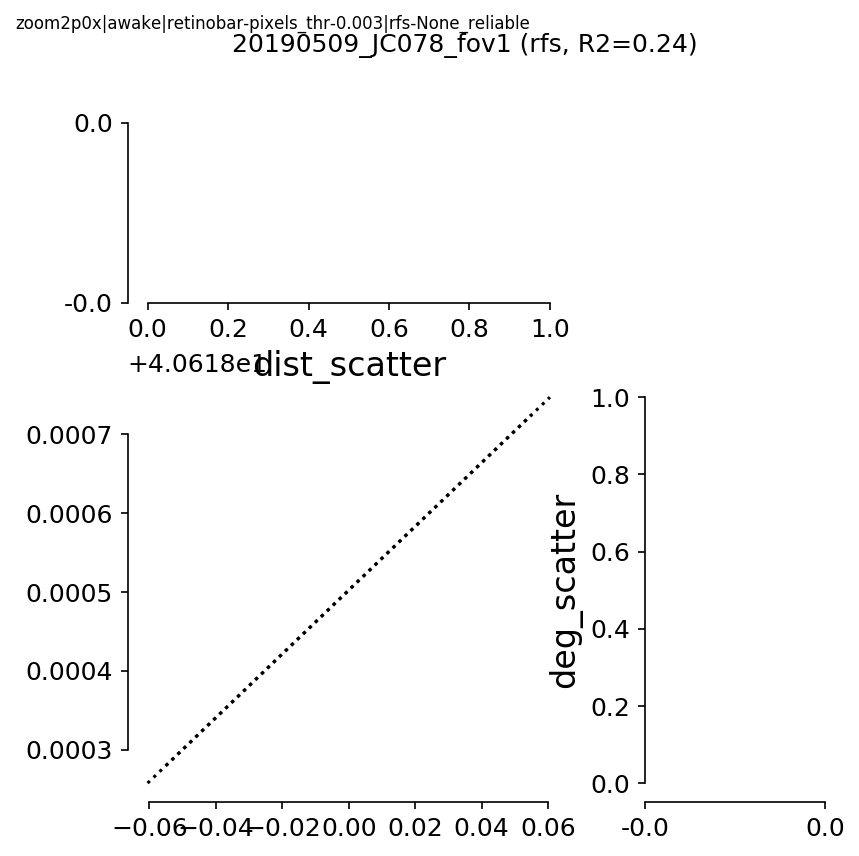

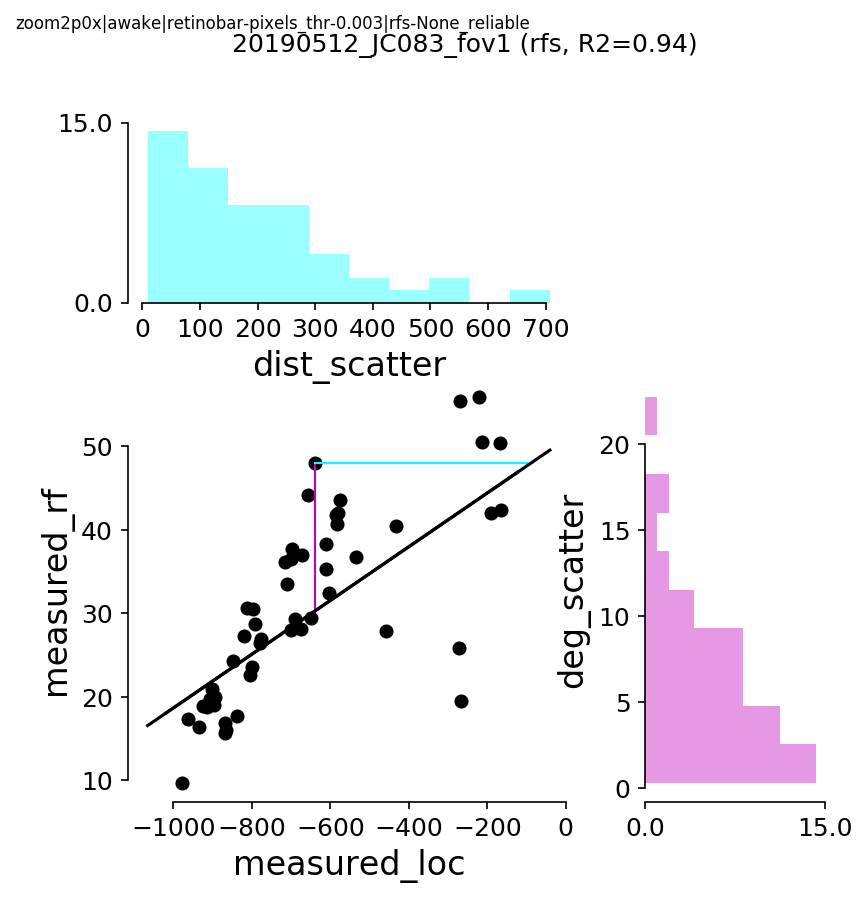

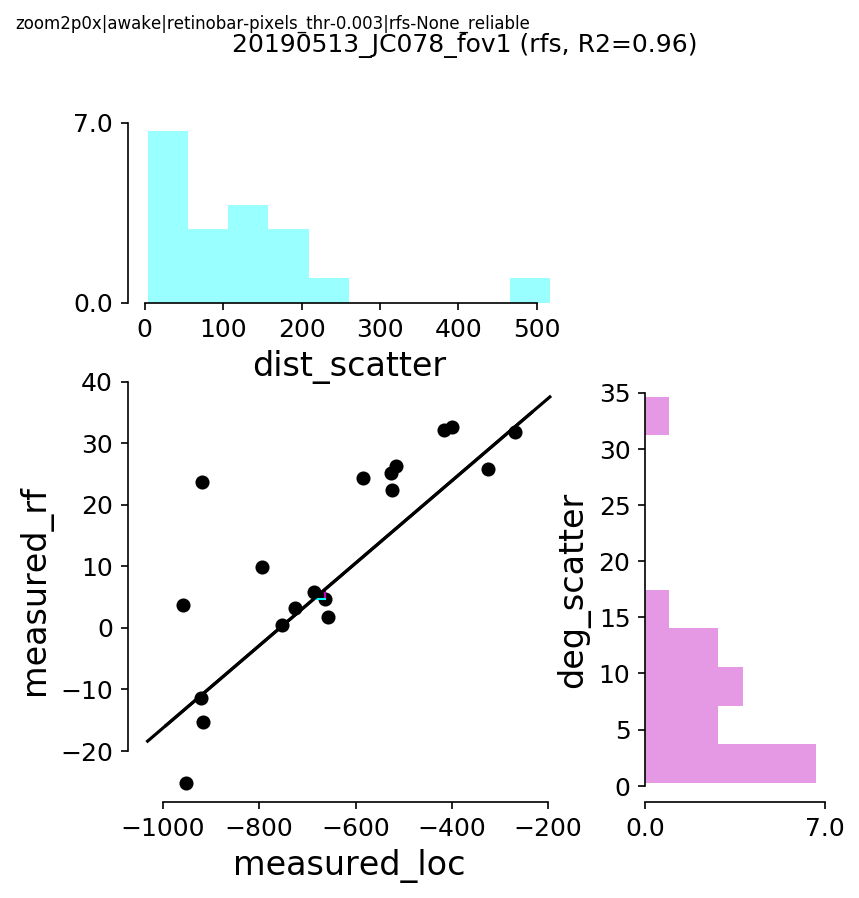

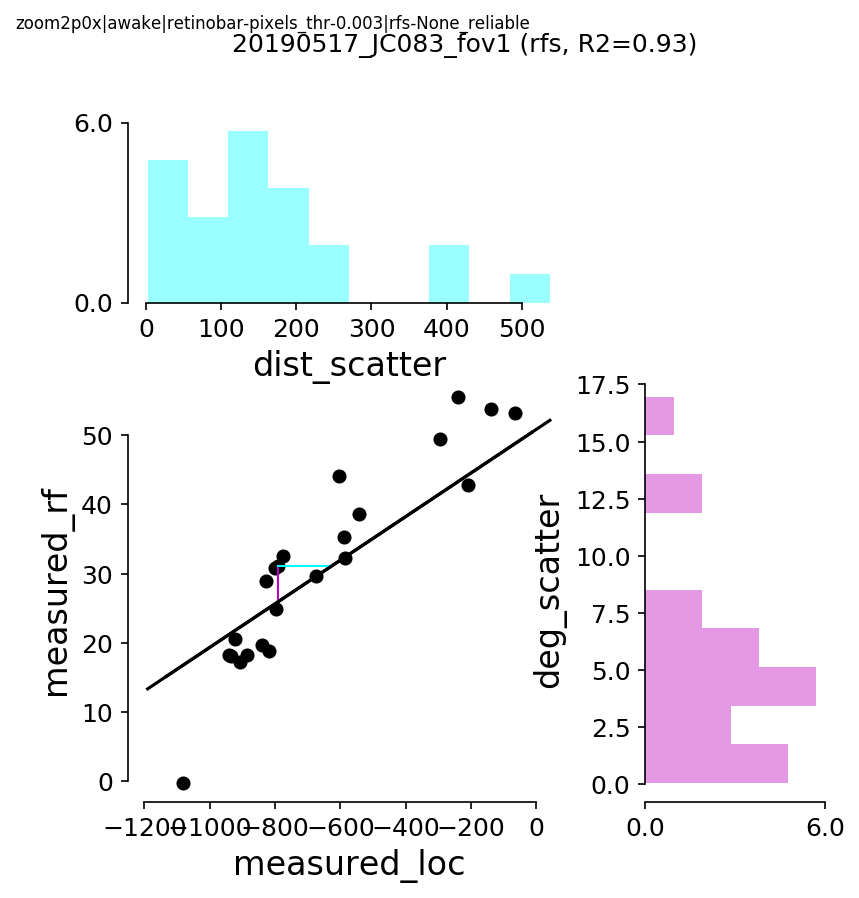

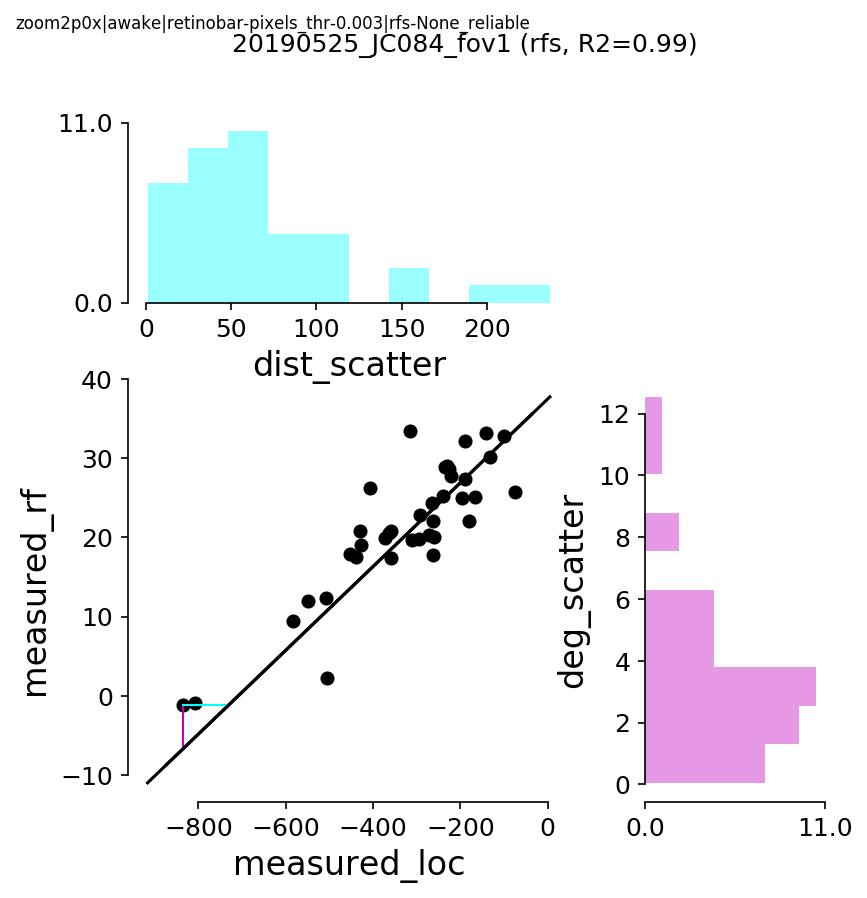

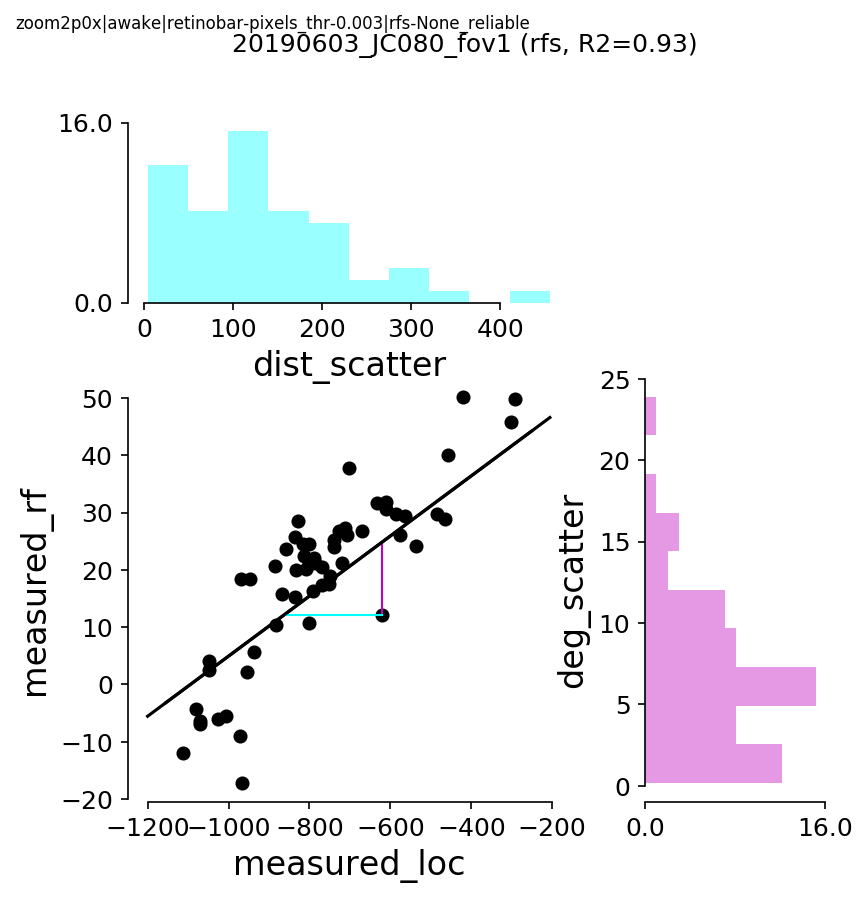

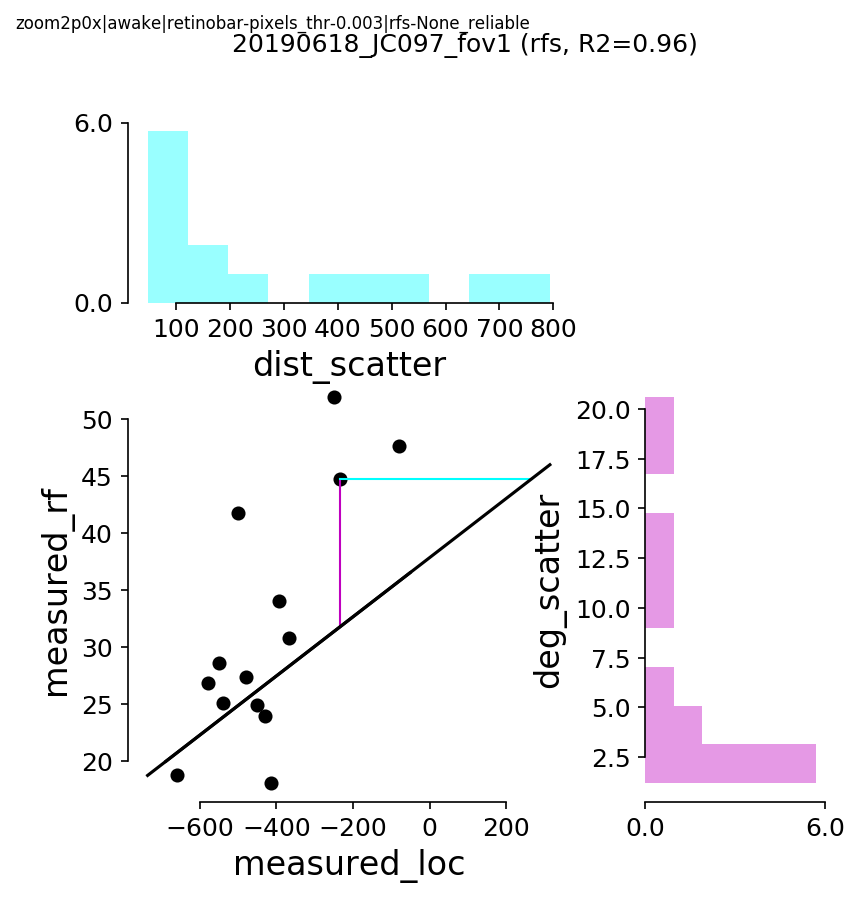

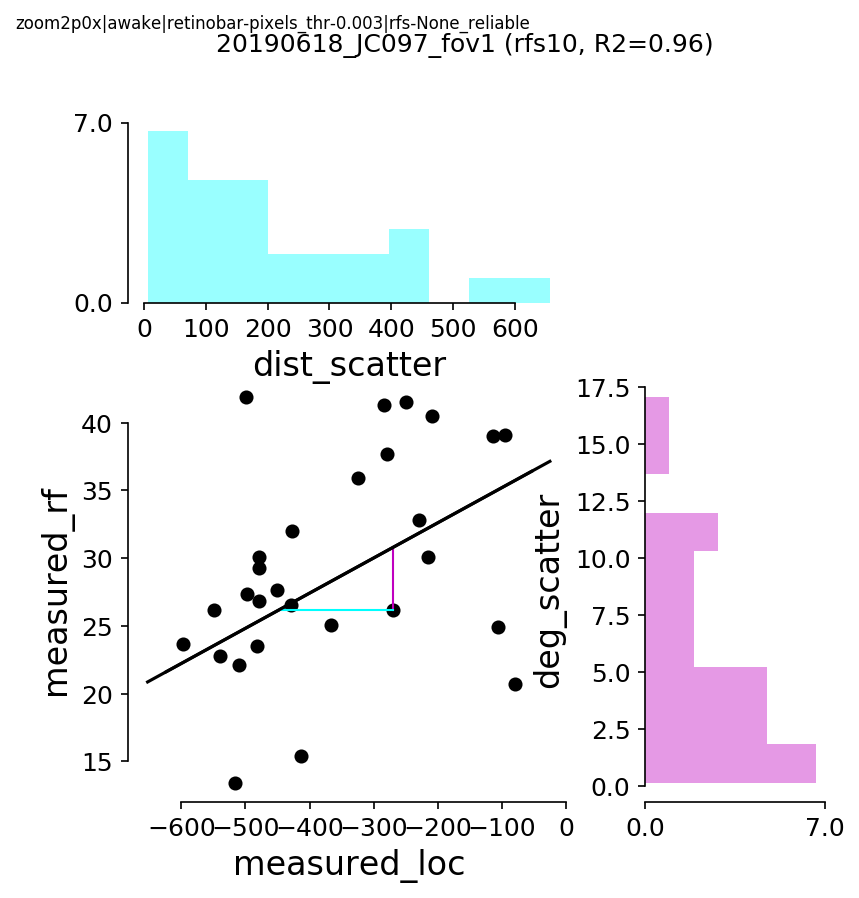

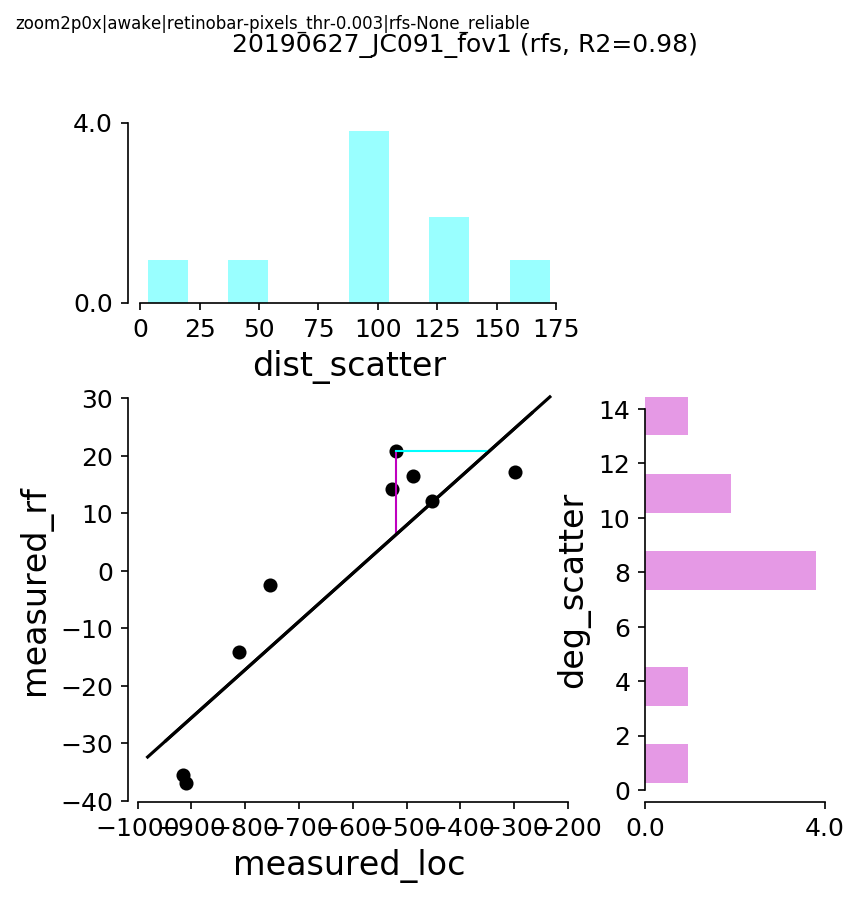

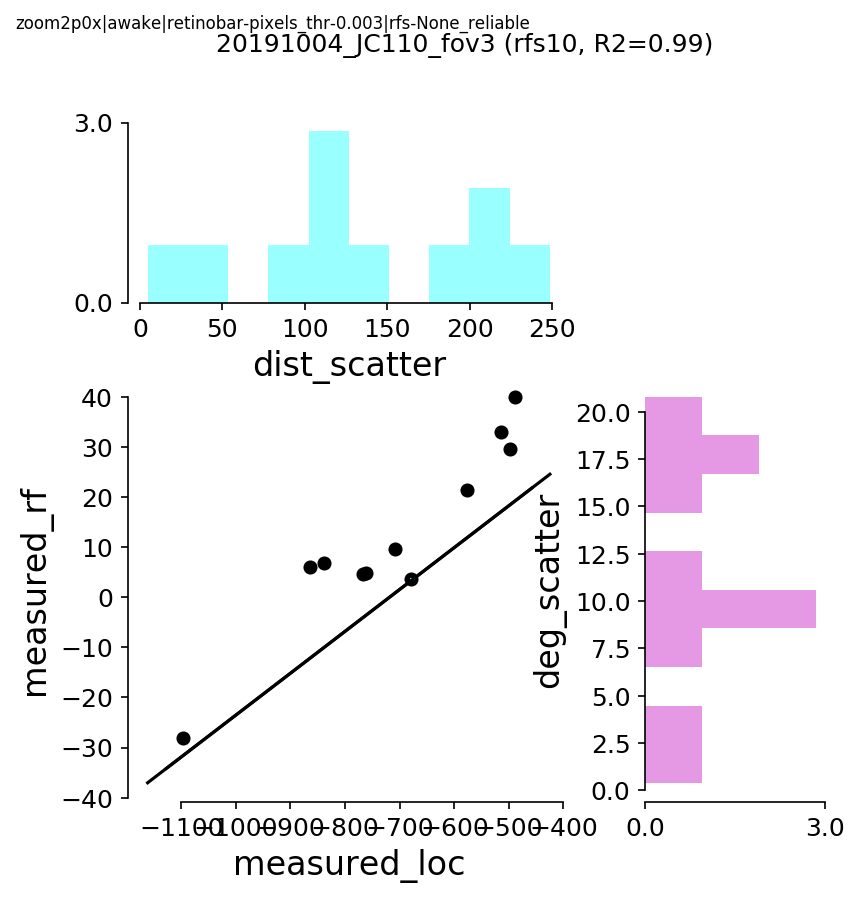

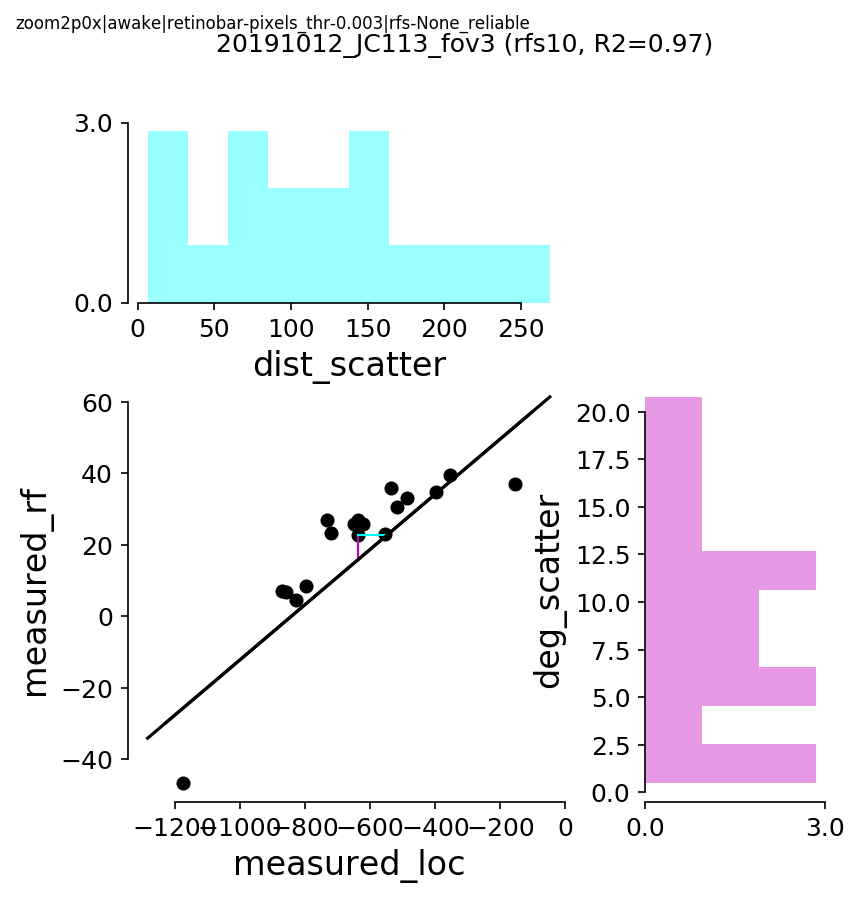

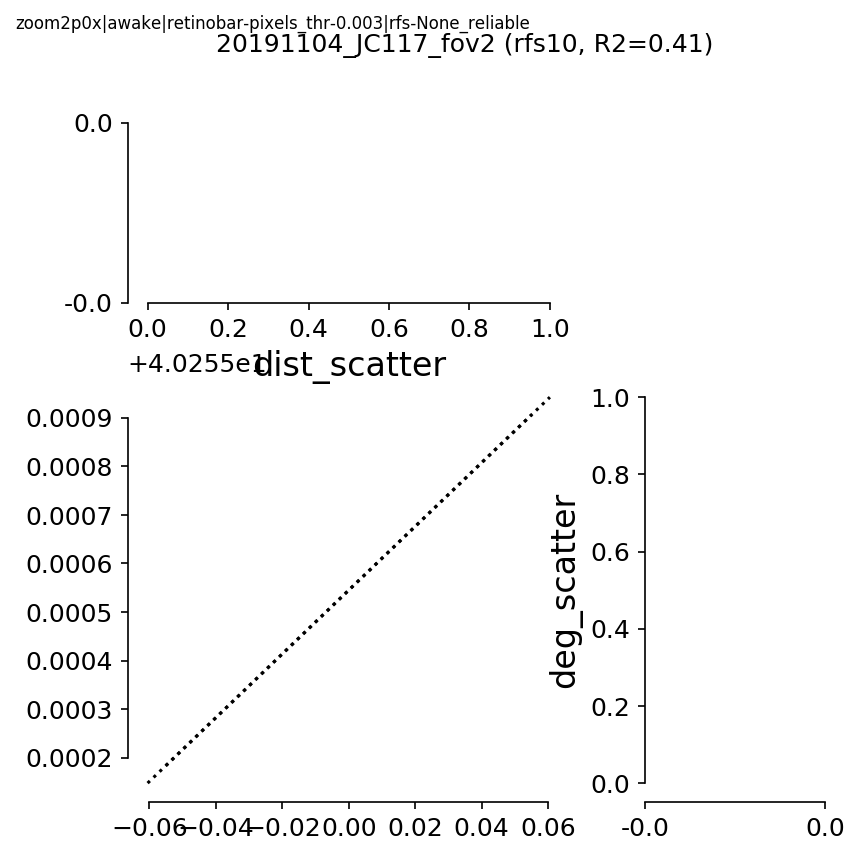

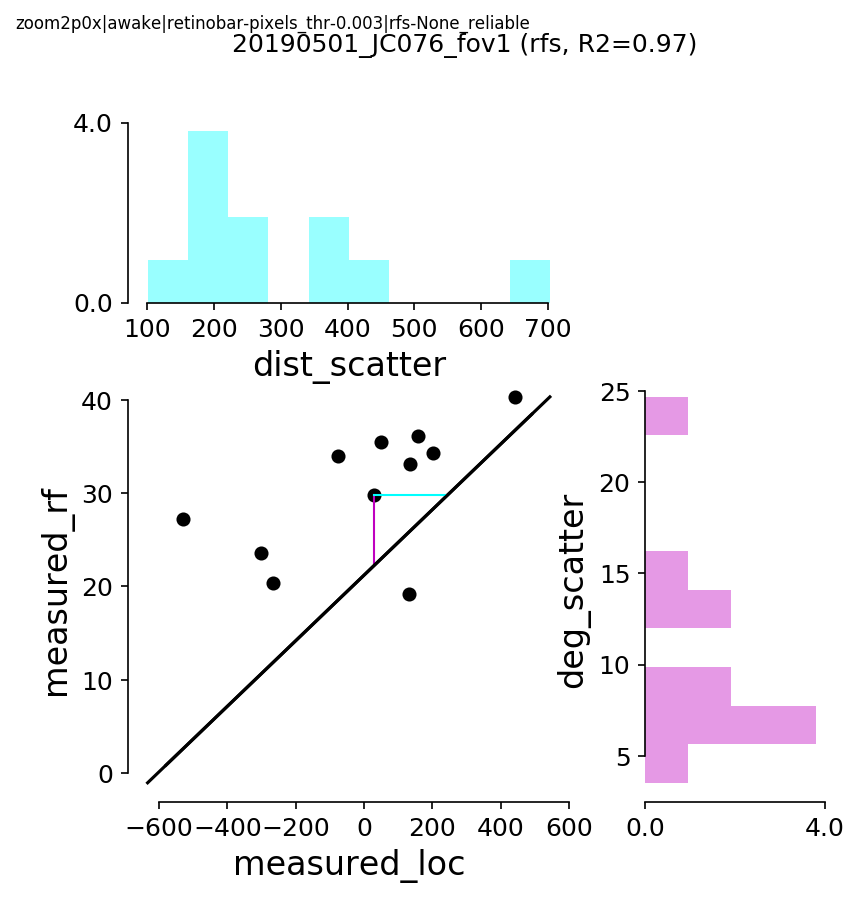

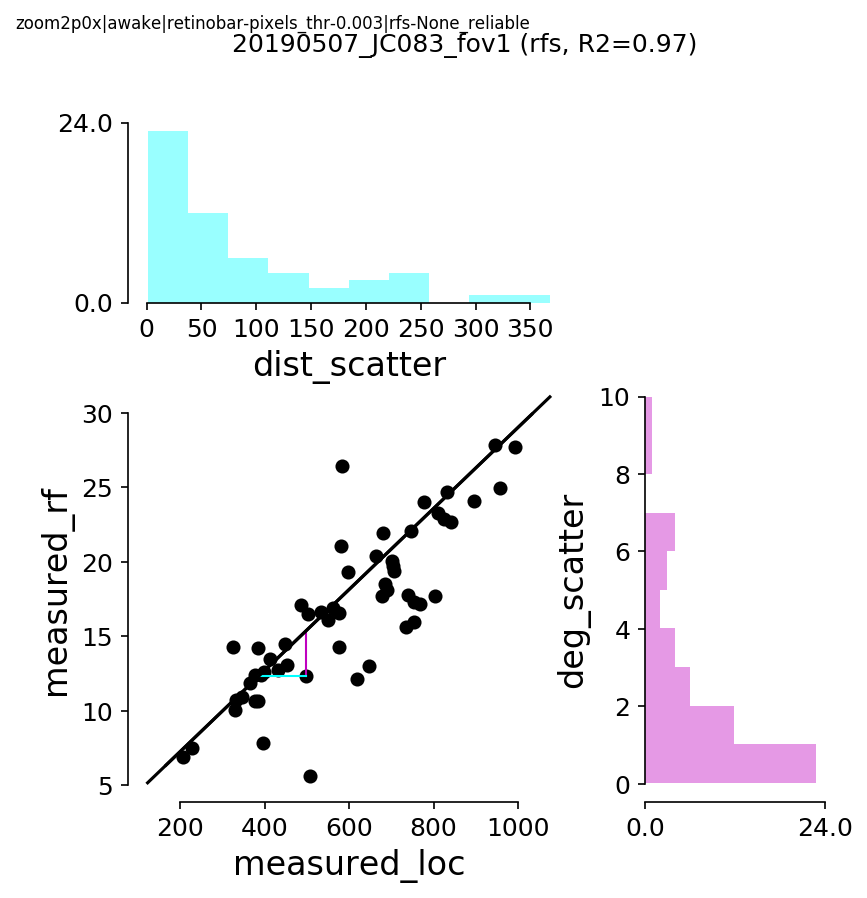

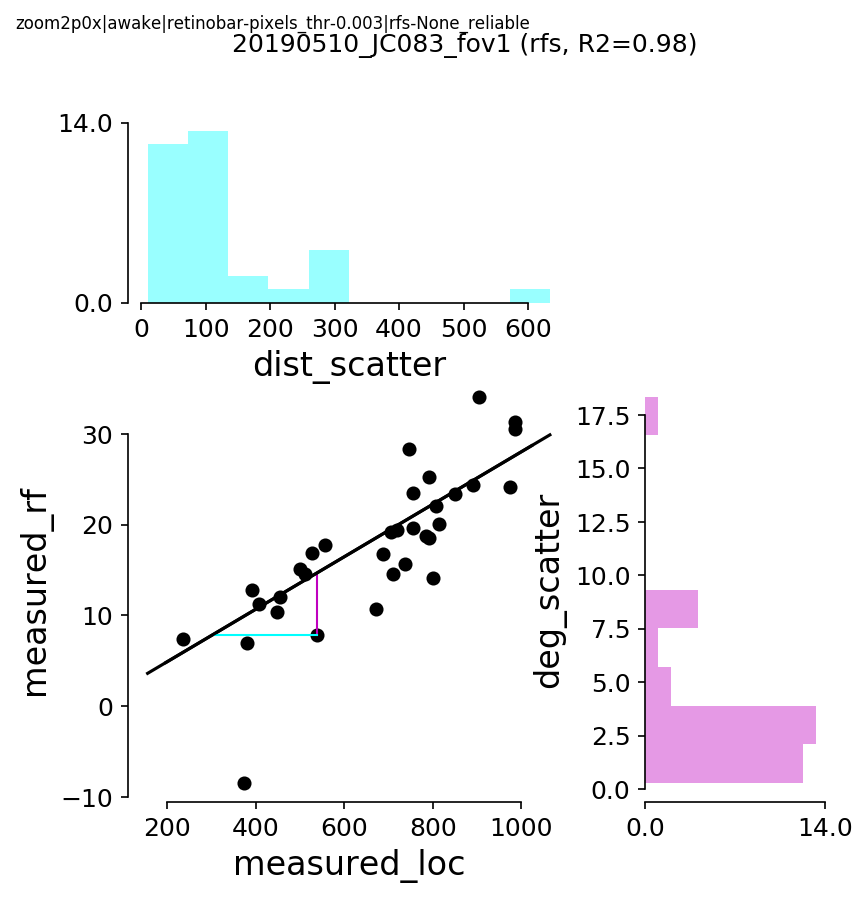

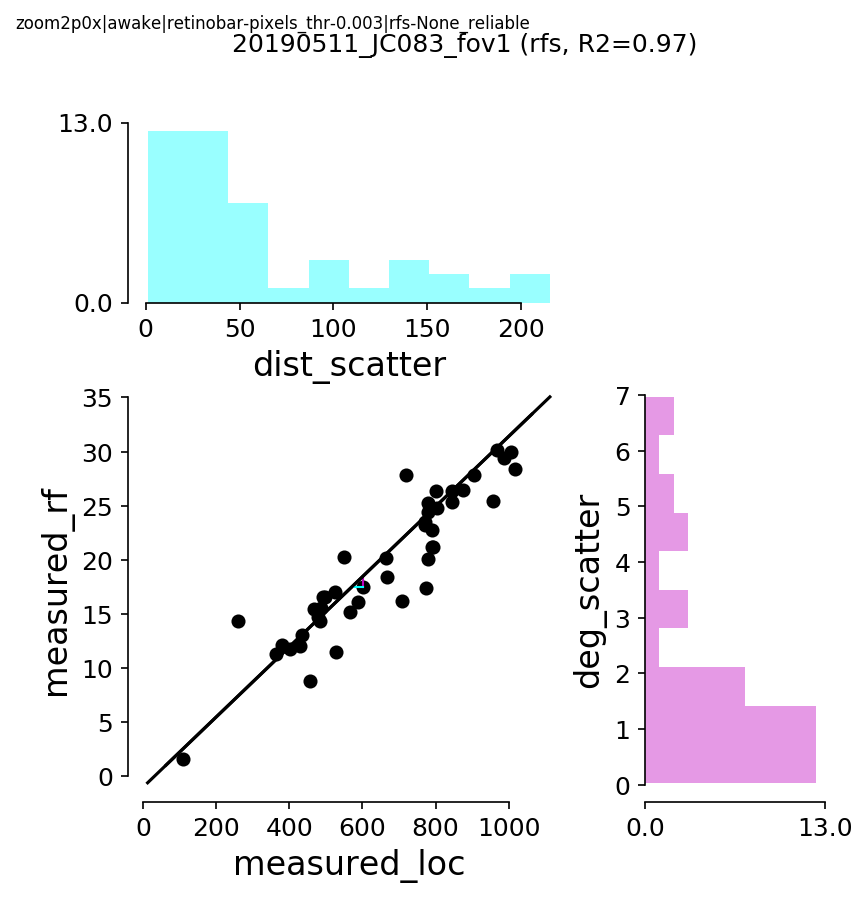

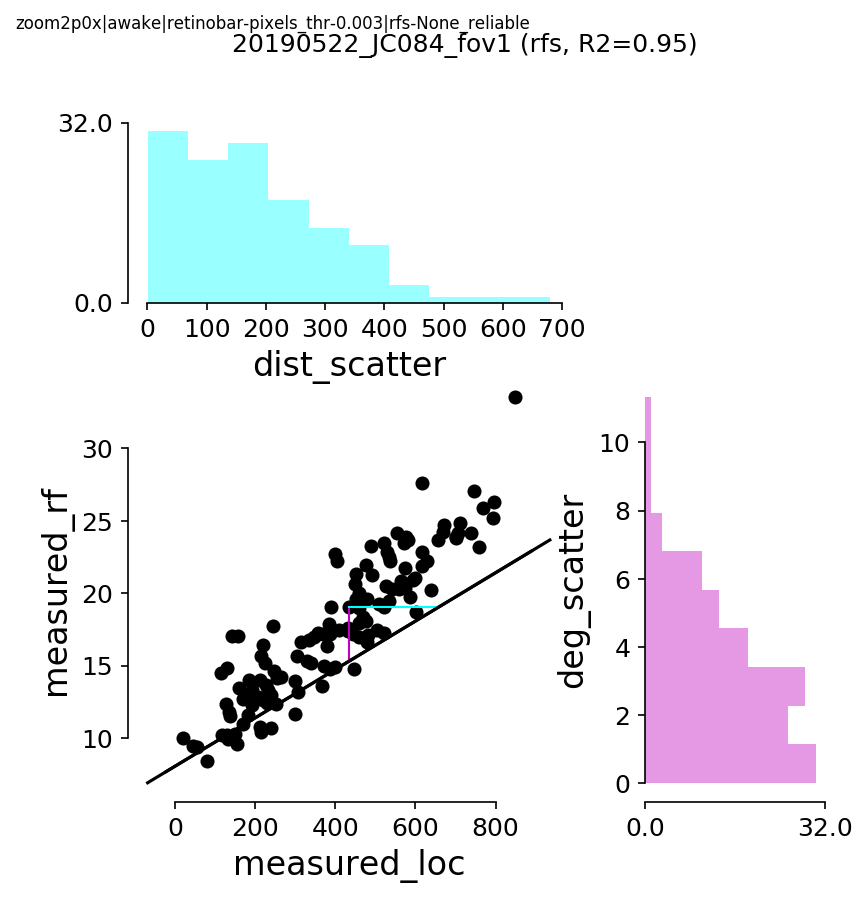

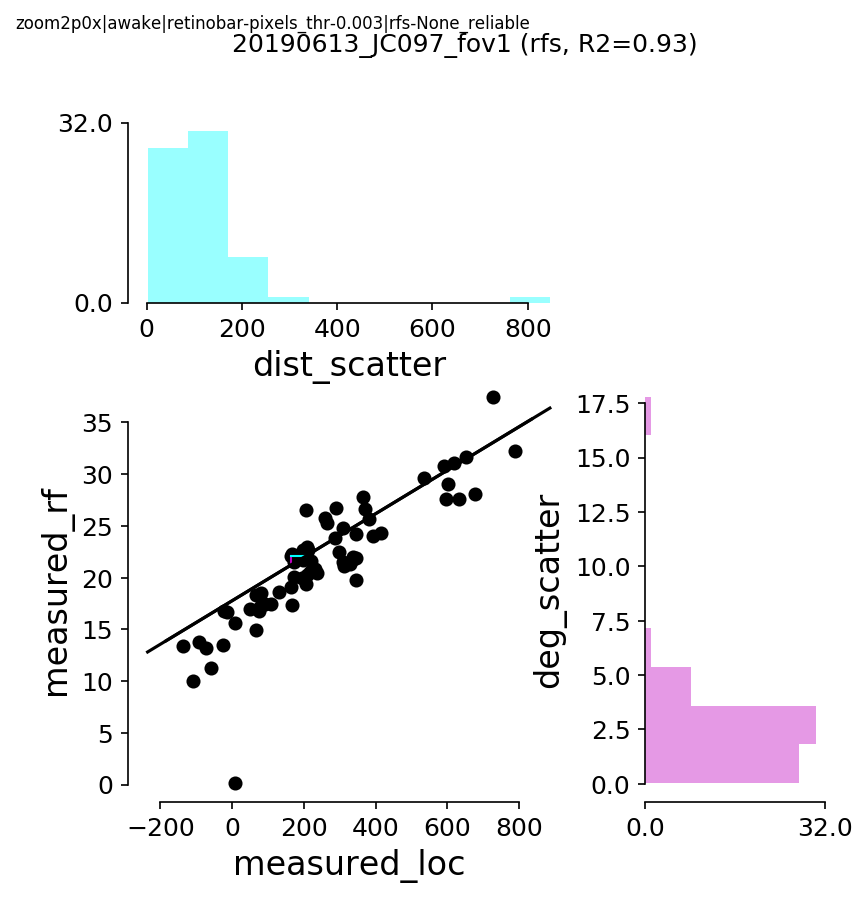

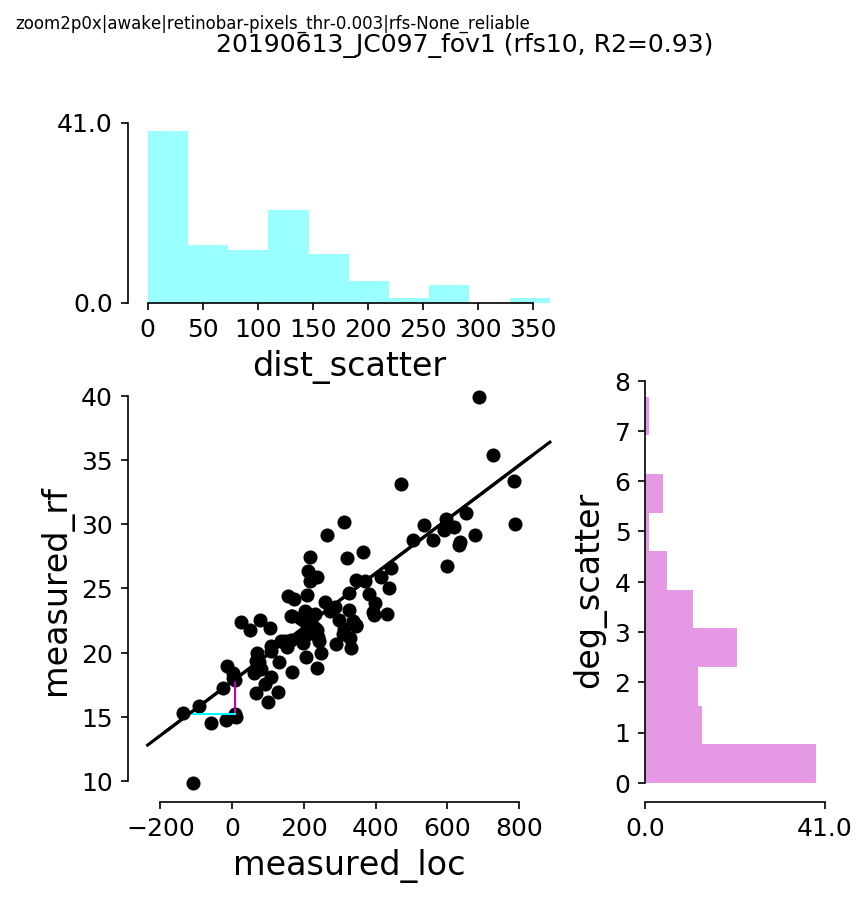

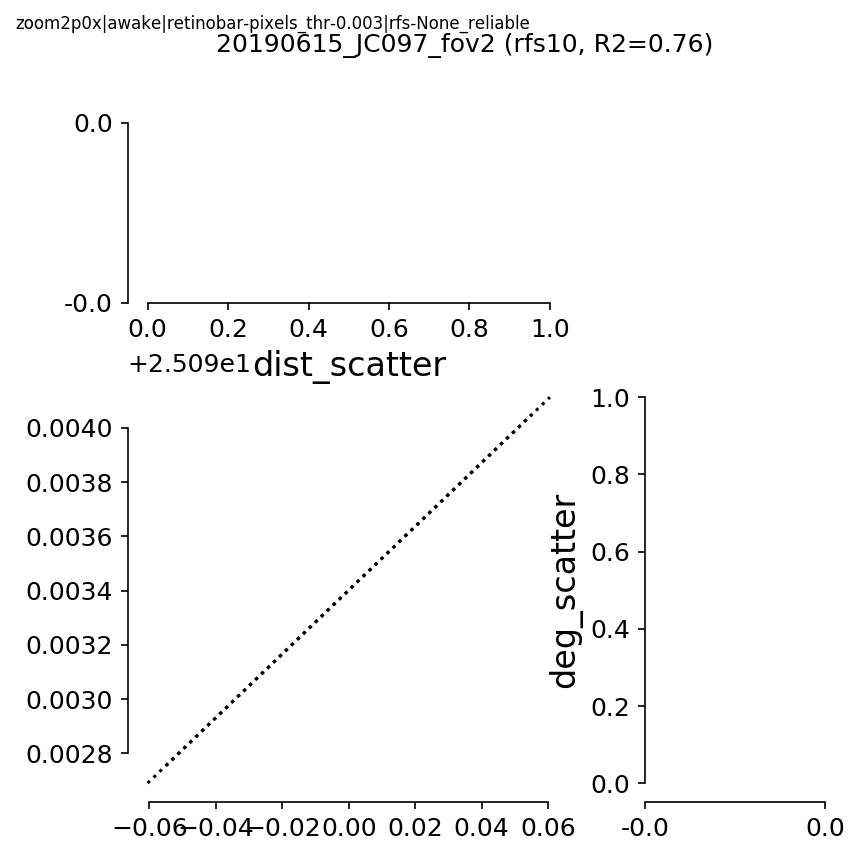

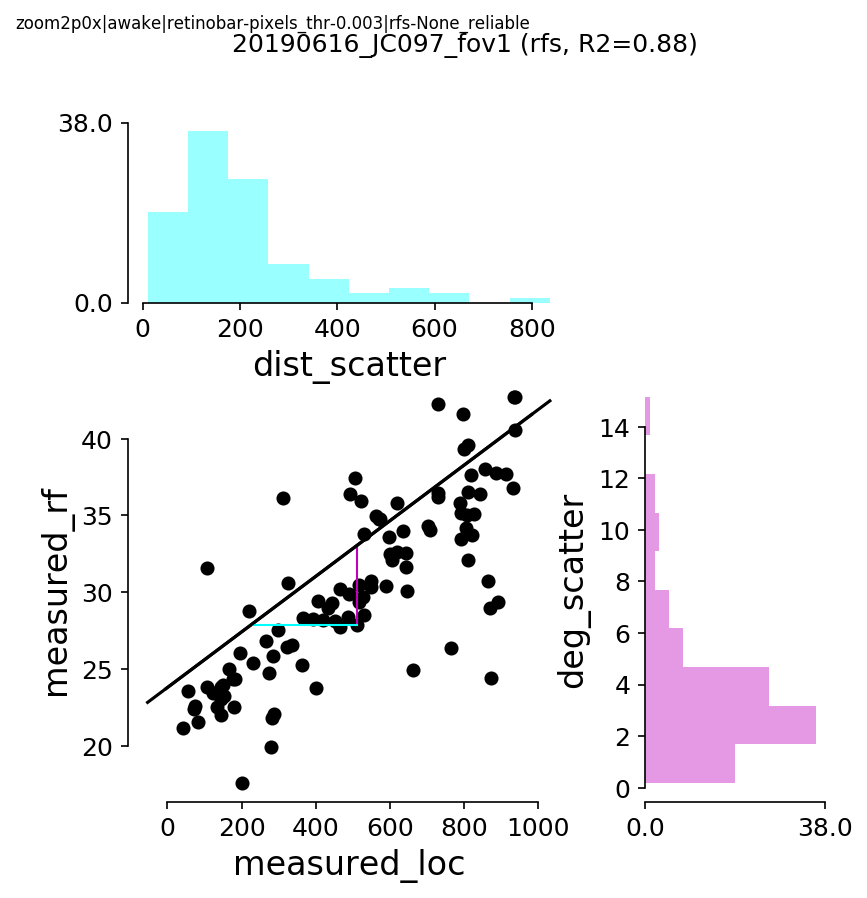

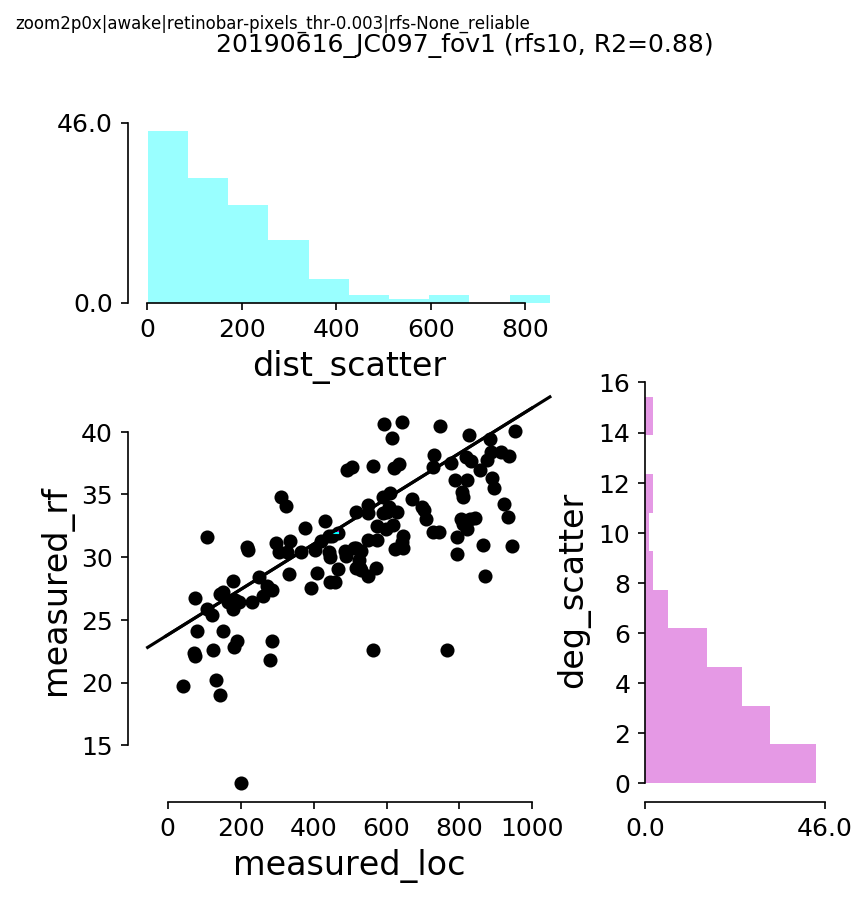

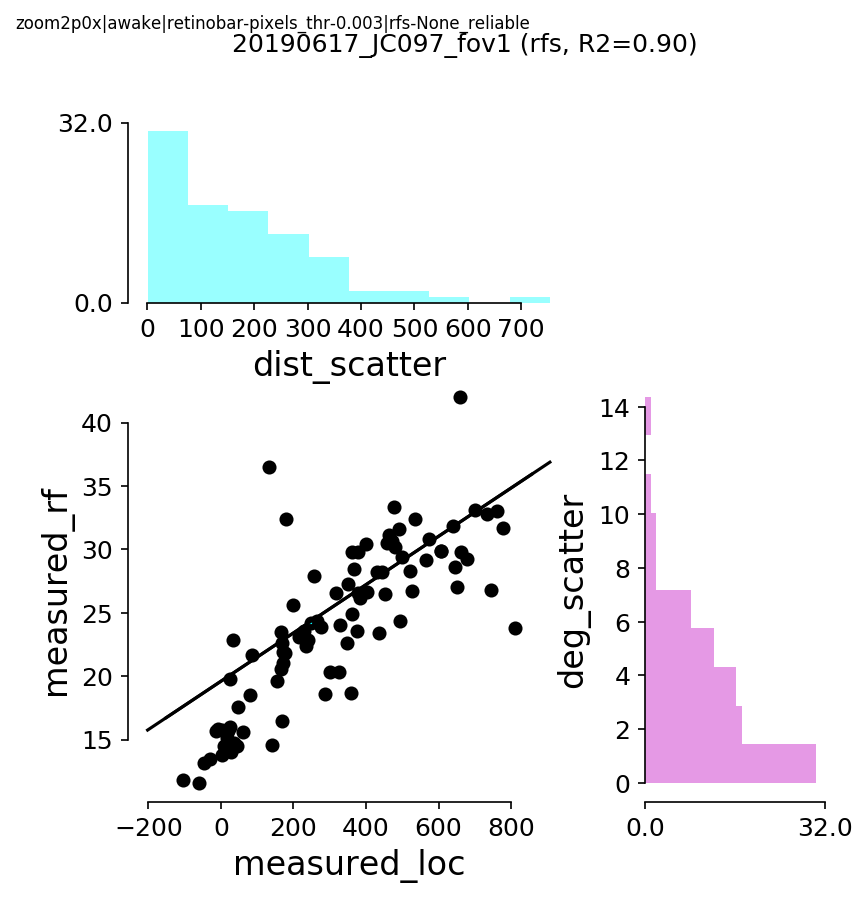

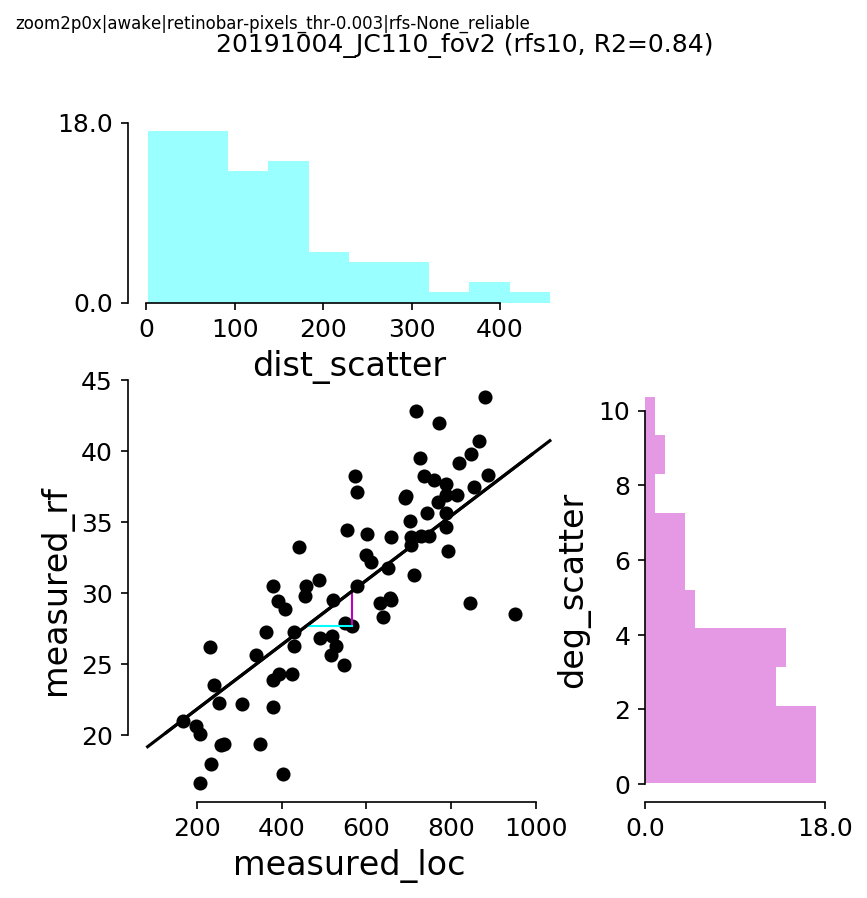

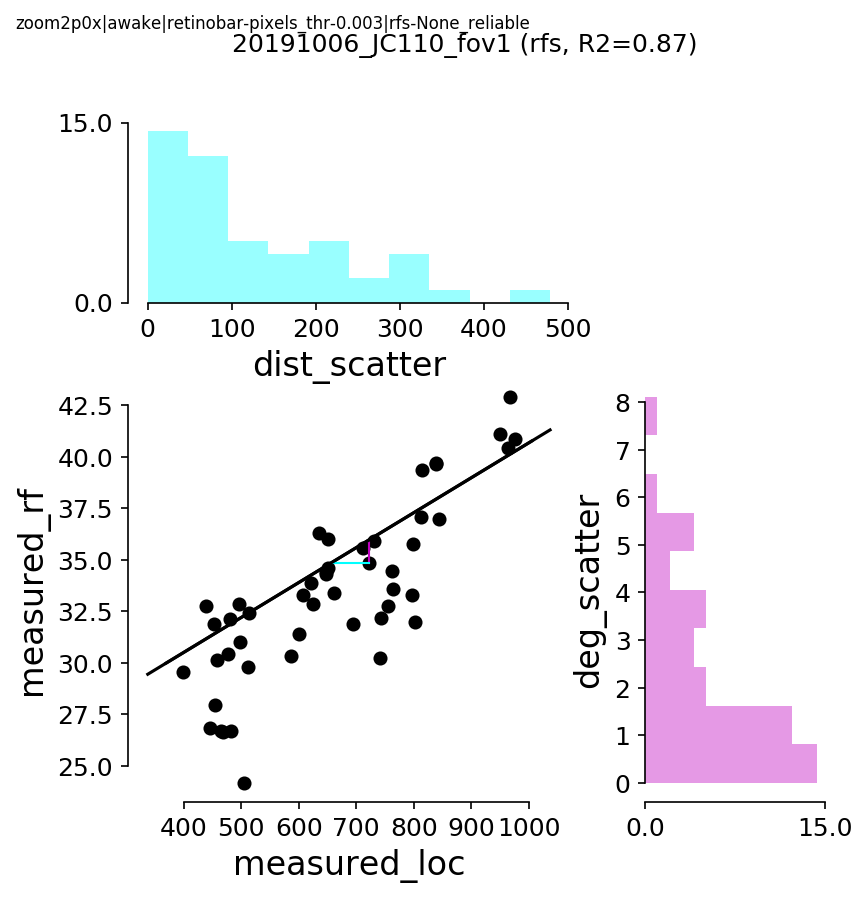

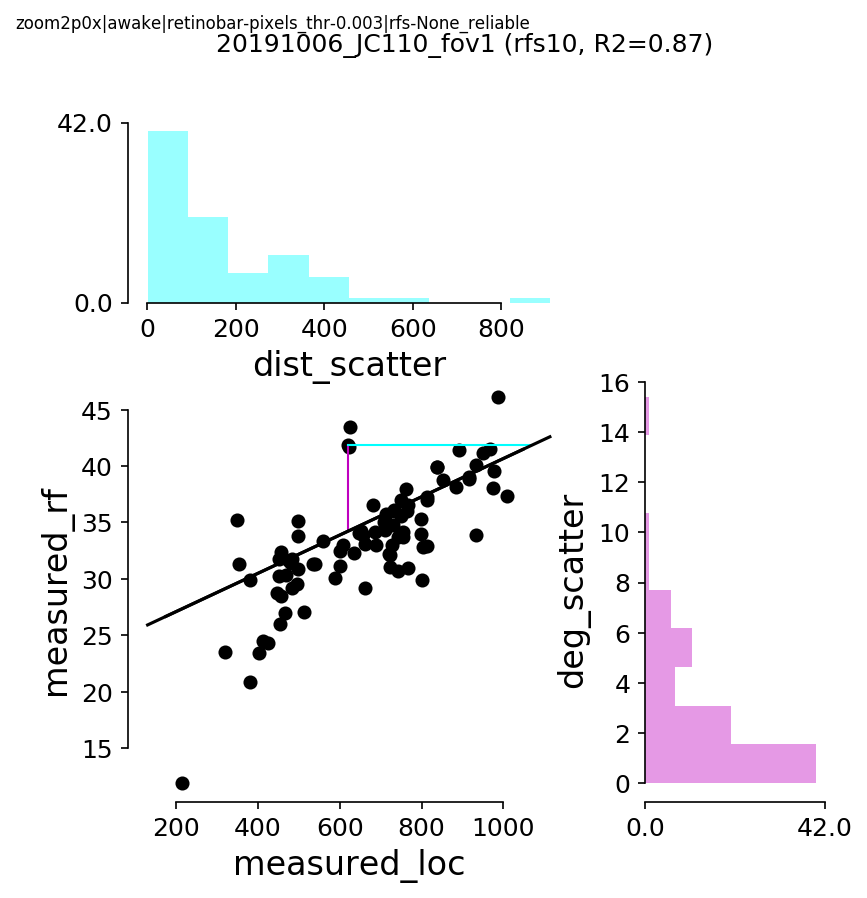

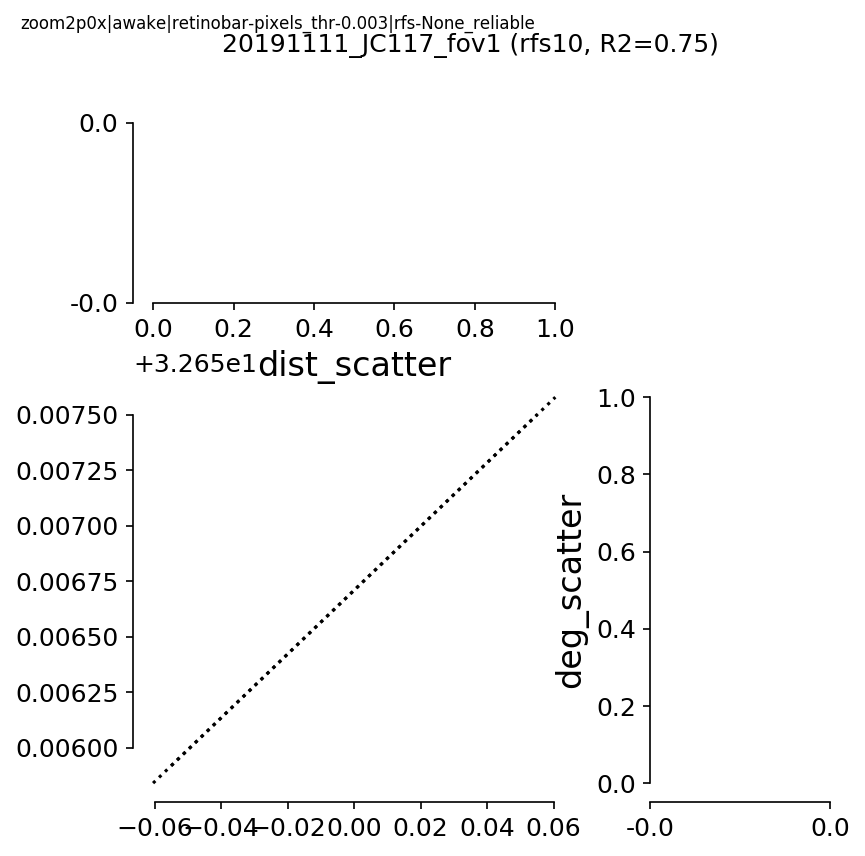

In [109]:
nbins=10
retino_r2 = 0.8

for (visual_area, datakey, rfname), rf_  in scatdf.groupby(['visual_area', 'datakey', 'rfname']):

    #rf_ = scatdf[scatdf['datakey']==datakey]
    ret_ = projdf[projdf['datakey']==datakey]

    print(rf_.shape, ret_.shape)

    fig, scatterax = pl.subplots(figsize=(6,6), dpi=dpi)
    cond='az'
    axdf = rf_[rf_['axis']==cond]
    sns.scatterplot(x='measured_loc', y='measured_rf', data=axdf, ax=scatterax,
                    color='k', edgecolor='k')
    slope = float(ret_[ret_['cond']==cond]['coefficient'])
    intercept = float(ret_[ret_['cond']==cond]['intercept'])
    r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ls = '-' if r2_v > retino_r2 else ':'
    
    npts = axdf.shape[0]
    #if npts>20:
    pt_ixs = [int(npts/2.)] #np.arange(0, npts, 10)
    lw=1 

    for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
        if ii not in pt_ixs:
            continue
        pred = axdf['predicted_rf'].iloc[ii]
        offset = axdf['deg_scatter'].iloc[ii]*-1 if yi>pred else axdf['deg_scatter'].iloc[ii]
        scatterax.plot([xi,xi], [yi, yi+offset], 'm', alpha=1, lw=lw)
    scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
                       color='k', label=False, label_prefix=label_prefix)

    # Plot histogram
    divider = make_axes_locatable(scatterax)
    histax_x = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
    histax_y = divider.append_axes("right", 1.2, pad=0.5, sharey=None) #scatterax)

    sns.distplot(axdf['dist_scatter'], color='cyan', ax=histax_x, kde=False, bins=nbins)
    histax_x.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_x.get_ylim()
    histax_x.set_yticks([xlim, ylim])
    histax_x.set_yticklabels([round(xlim), round(ylim)])
    histax_x.spines["right"].set_visible(False)
    histax_x.spines["left"].set_visible(True)
    histax_x.spines["top"].set_visible(False)
    histax_x.spines["bottom"].set_visible(True)

    for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
        if ii not in pt_ixs:
            continue
        pred = axdf['predicted_loc'].iloc[ii]
        offset = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred else axdf['dist_scatter'].iloc[ii]    
        scatterax.plot([xi, xi+offset], [yi, yi], 'cyan', alpha=1, lw=lw)
    scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
                       color='k', label=False, label_prefix=label_prefix)

    #ax = axn[1, 1]
    sns.distplot(axdf['deg_scatter'], color='m', ax=histax_y, vertical=True, kde=False, bins=nbins)
    histax_y.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_y.get_xlim()
    histax_y.set_xticks([xlim, ylim])
    histax_y.set_xticklabels([round(xlim), round(ylim)])
    histax_y.spines["right"].set_visible(False)
    histax_y.spines["left"].set_visible(True)
    histax_y.spines["top"].set_visible(False)
    histax_y.spines["bottom"].set_visible(True)

    sns.despine(trim=True)
    pl.suptitle('%s (%s, R2=%.2f)' % (datakey, rfname, r2_v))

    label_figure(fig, data_id)

    figname = '%s_%s_%s_deg_v_dist_scatter' % (rfname, visual_area, datakey)
    pl.savefig(os.path.join(scatterfov_dir,'%s.svg' % figname))
    #print(scatterfov_dir, figname)

In [671]:
vdf_ax.head()

axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190613_JC097_fov1     7.275521    334.964654      799.145   
1   az  20190613_JC097_fov1     0.057691      2.656077      476.072   
2   az  20190613_JC097_fov1     5.233501    240.950155      582.386   
3   az  20190613_JC097_fov1     2.484759    114.398174      813.273   
4   az  20190613_JC097_fov1     0.984448     45.323960      877.478   

   measured_rf  predicted_loc predicted_rf  retino_R2 visual_area  
0    39.905866    1134.109349      32.6303   0.916572          V1  
1    25.555434     473.416143      25.6131   0.916572          V1  
2    33.155796     823.336450      27.9223   0.916572          V1  
3    35.421968     927.670898      32.9372   0.916572          V1  
4    33.347307     832.153616      34.3318   0.916572          V1

## Select best Retino, and either rfs/rfs10. Plot projected fov vs. orig fov position

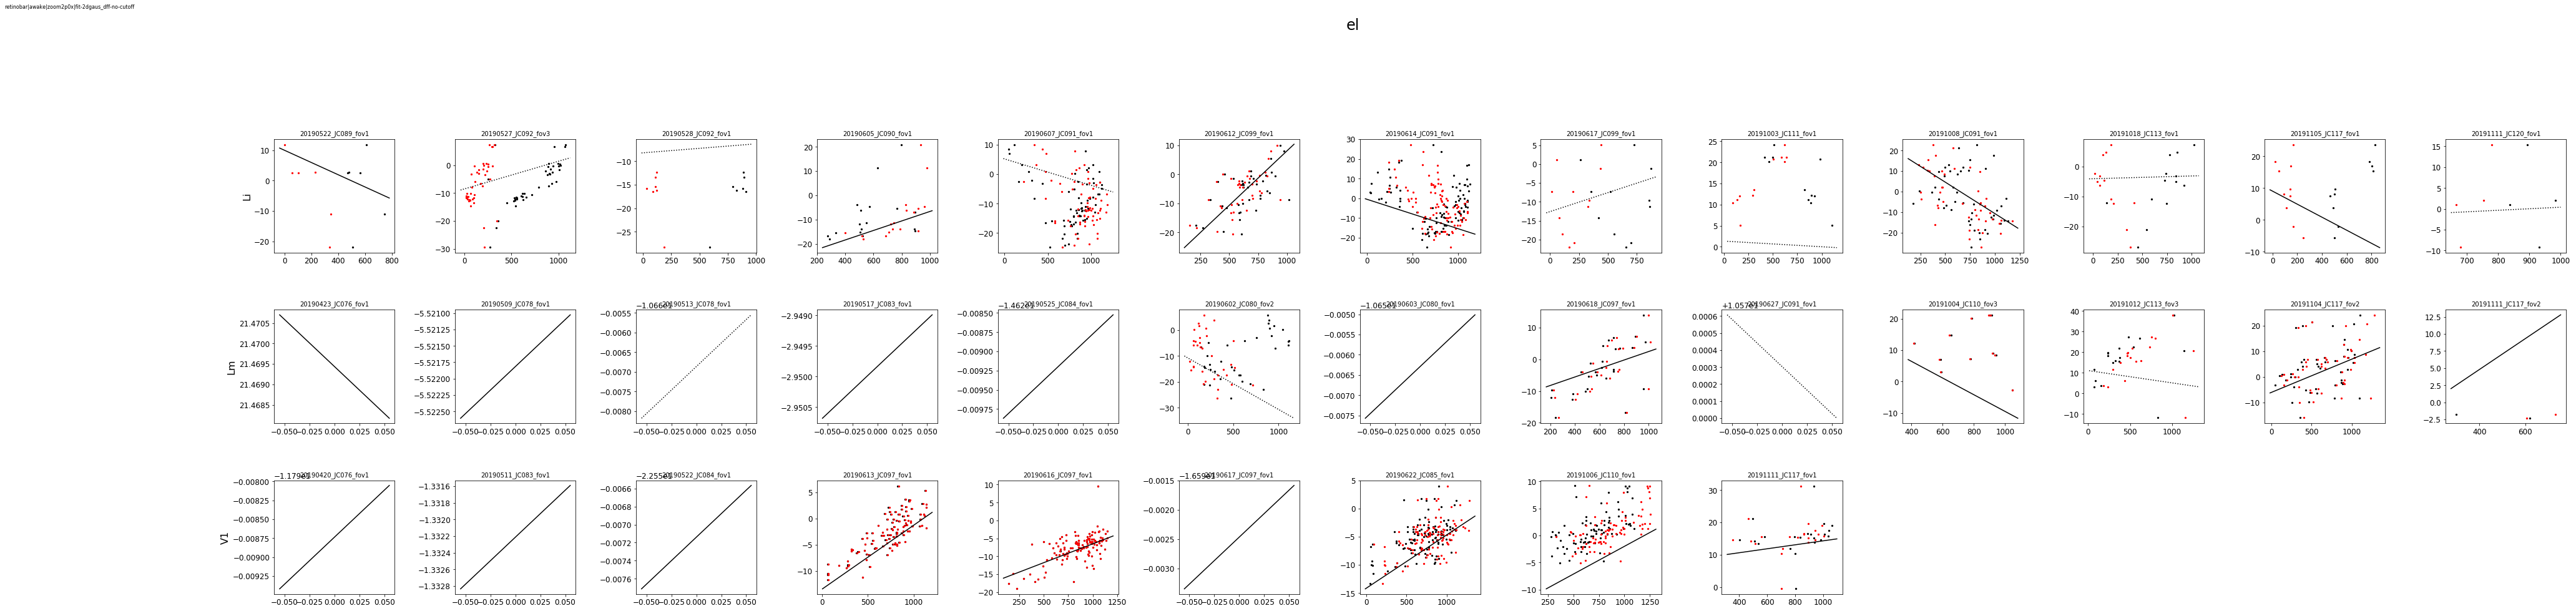

In [204]:
cond = 'el'
rfname = 'rfs10'
alt_rfname = 'rfs10' if rfname=='rfs' else 'rfs10'

rep_colors=['blue', 'orange']

xname = 'ml' if cond=='az' else 'ap'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(rfdf[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(rfdf.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):
        
        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        #for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

        # Plot RF positions vs. cell locs
        edf = ddf[ddf['experiment']==rfname].copy()
        if len(edf)==0:
            edf = ddf[ddf['experiment']==alt_rfname].copy()
            #rfname = alt_rfname
        
        cell_locs = edf['%s_pos' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k')
        
        # plot projected
        cell_locs = edf['%s_proj' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='r')

        # Plot retino direction
        p_df = projdf[projdf['datakey']==datakey]
        retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
        g = p_df[p_df['retinorun']==retinorun].copy()
        
        slope = float(g[g['cond']==cond]['coefficient'])
        intercept = float(g[g['cond']==cond]['intercept'])
        ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
        r2_v = float(g[g['cond']==cond]['R2'])
        label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(p_df)>2 else ''
        label = len(regdf_vs)>2
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = '%s_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (rfname, cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

## Plot all RFs and Retino Runs by session 

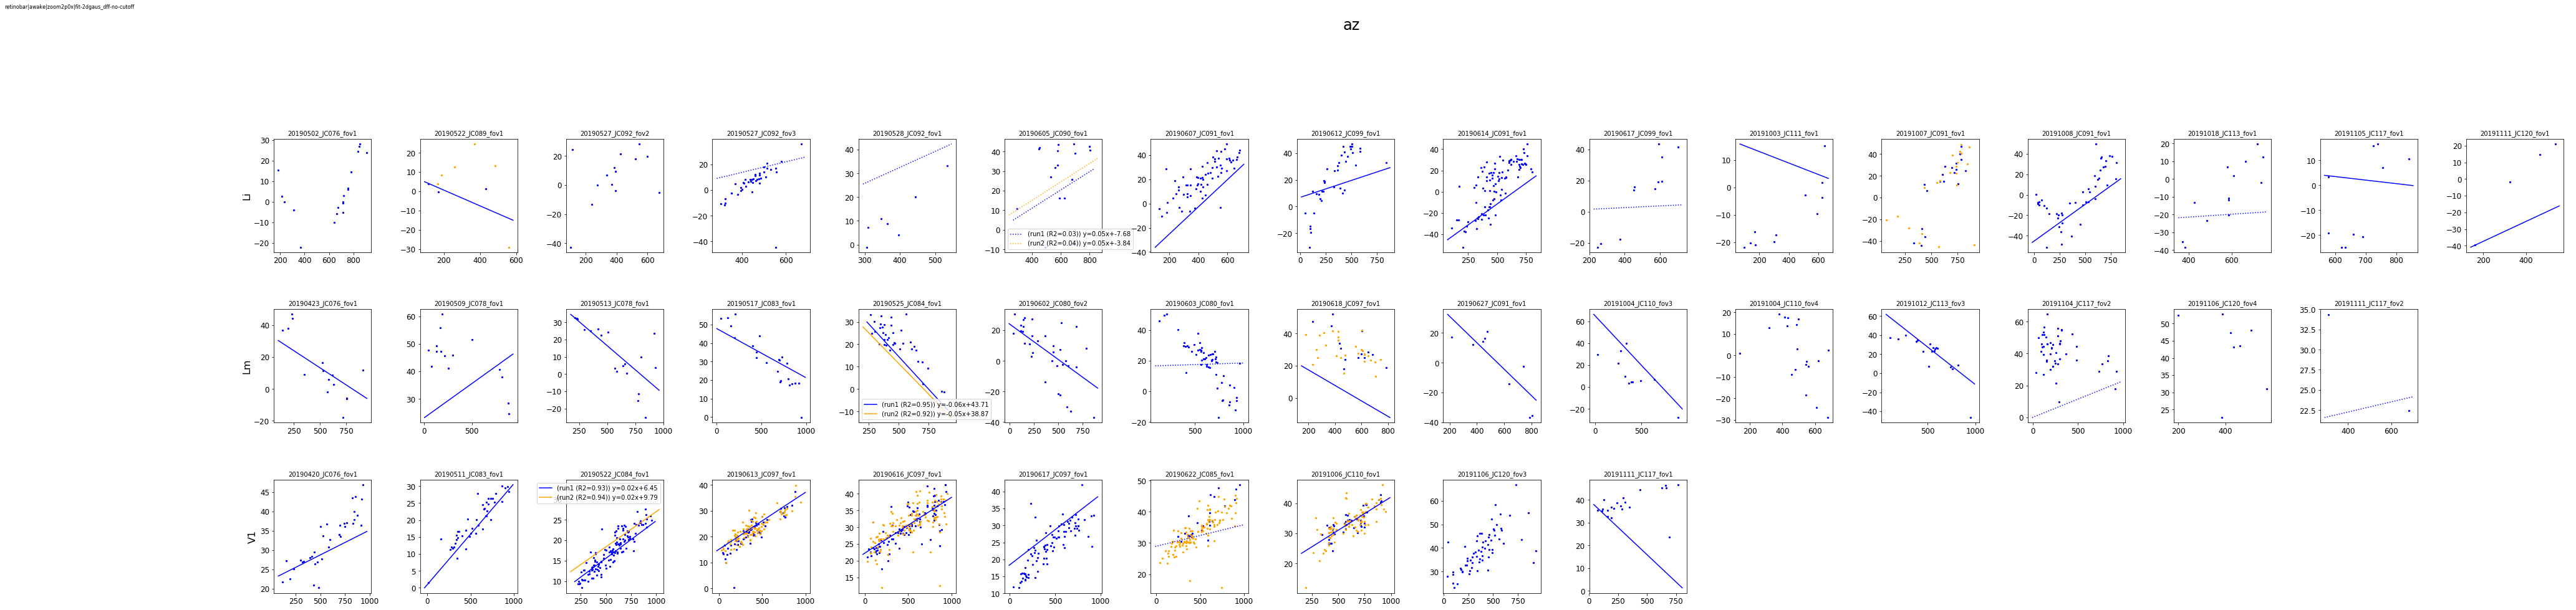

In [188]:
cond = 'az'
rep_colors=['blue', 'orange']

xname = 'ml_pos' if cond=='az' else 'ap_pos'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(r_df[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(r_df.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):

        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

            # Plot RF positions vs. cell locs
            cell_locs = edf[xname].values
            rf_locs = edf[yname].values
            ax.scatter(cell_locs, rf_locs, marker='o', s=5, color=col)

        # Plot retino direction
        regdf_vs = projdf[projdf['datakey']==datakey]
        for col, (retinorun, g) in zip(rep_colors, regdf_vs.groupby(['retinorun'])):
            slope = float(g[g['cond']==cond]['coefficient'])
            intercept = float(g[g['cond']==cond]['intercept'])
            ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(g[g['cond']==cond]['R2'])
            label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(regdf_vs)>2 else ''
            label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color=col,
                        label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = 'inspect_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

In [189]:
projection_df[projection_df['datakey']=='20190607_JC091_fov1']

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.973328  4.286557     0.111963   az -47.418096        0.0   0.986574   
1  0.418045  3.133284    -0.008981   el   5.184302        0.0  -0.646564   

  animalid   session            fov    retinorun     retinoid  \
0    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   
1    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   

               datakey                                              fpath  \
0  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   
1  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   

  visual_area  abs_coef  
0          Li  0.111963  
1          Li  0.008981

In [190]:
datakey = '20190607_JC091_fov1'
#retinorun = 'retino_run1'

p_df = projection_df[projection_df['datakey']==datakey]
# Load 1 fov to test sth
# fpath = [p for p in proj_fit_paths if p[0]=='JC091' and p[1]=='20190607' and p[3]==retinorun][0][5]
# with open(fpath, 'rb') as f:
#     res = pkl.load(f)
# print(res['regr_az'].coef_, res['regr_az'].intercept_)

# p_df = res['regr_df'].copy()


retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
fpath = p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]
gpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(gpath, 'rb') as f:
    gresults = pkl.load(f)

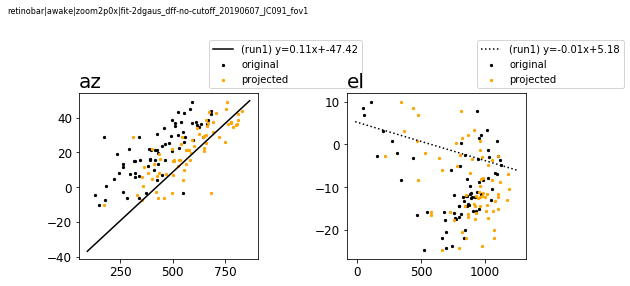

In [192]:
#datakey = '20190522_JC084_fov1' #'20190607_JC091_fov1'
#retinorun = 'retino_run1'
rfname = 'rfs10'

p_df = projdf[projdf['datakey']==datakey]
retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']

g = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
edf = rfdf[(rfdf['datakey']==datakey) & (rfdf['experiment']==rfname)]

fig, axn = pl.subplots(1,2, figsize=(8,4))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'

    # Plot RF positions vs. cell locs
    cell_locs = edf['%s_pos' % xname].values
    rf_locs = edf[yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')
    
    proj_locs = edf['%s_proj' % xname].values
    ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')
    
    proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
                             for ap, ml in edf[['ap_pos', 'ml_pos']].values]))


    # proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
    #                           for ap, ml in edf[['ap_pos', 'ml_pos']].values]))
    #ax.scatter(proj_locs2, rf_locs, marker='o', s=5, color='blue')

    # plot gradient line
    slope = float(g[g['cond']==cond]['coefficient'])
    intercept = float(g[g['cond']==cond]['intercept'])
    ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
    label_prefix = retinorun.split('_')[1]
    label = True
    ax = abline(slope, intercept, ax=ax, color='k',
                label=label, label_prefix=label_prefix, ls=ls)
    ax.set_title(cond, loc='left', fontsize=20)
    
    ax.legend(bbox_to_anchor=(0.7, 1), loc='top')
    
pl.subplots_adjust(top=0.7, wspace=0.5)

label_figure(fig, '%s_%s' % (data_id, datakey))

In [193]:
g

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.973328  4.286557     0.111963   az -47.418096        0.0   0.986574   
1  0.418045  3.133284    -0.008981   el   5.184302        0.0  -0.646564   

  animalid   session            fov    retinorun     retinoid  \
0    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   
1    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   

               datakey                                              fpath  \
0  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   
1  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   

  visual_area  abs_coef  
0          Li  0.111963  
1          Li  0.008981

In [630]:
proj_ = [np.dot(np.array((ap, ml)), gresults['el']['vhat']) for ap, ml in edf[['ap_pos', 'ml_pos']].values]



[1265.2474336870805,
 1306.7746604873687,
 1220.4113895819639,
 1111.3053426323288,
 1099.6193022330513,
 1093.6652739832678,
 1056.9476933257663,
 1015.6602439137907,
 990.40668755527713,
 1006.5293870488546,
 1019.7771998236738,
 1021.1258367429371,
 1081.1799756229473,
 988.56073457136483,
 997.45181404798802,
 975.52605725282399,
 901.64686373724146,
 879.57901663789187,
 754.36803148270235,
 726.79906897816022,
 589.01519999303241,
 505.23375455400378,
 719.83386828155369,
 862.66716079778098,
 878.95859252757896,
 784.69765330435064,
 747.82022105464046,
 758.15762453465459,
 903.43953285708426,
 699.47876450594276,
 670.07272966149981,
 725.92998683552287,
 709.92273571409578,
 673.12522926049019,
 648.16473415435871,
 674.66924034800832,
 638.00494355457636,
 573.33653270003447,
 532.19117359224447,
 523.50434892788769,
 464.78996632312948,
 444.19508515920552,
 473.66328451172956,
 281.61057266015501,
 720.26901983812149,
 627.64977878653906,
 787.87448191950318,
 739.54190601

In [610]:
float(g[g['cond']==cond]['intercept'])

6.461437259218765

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


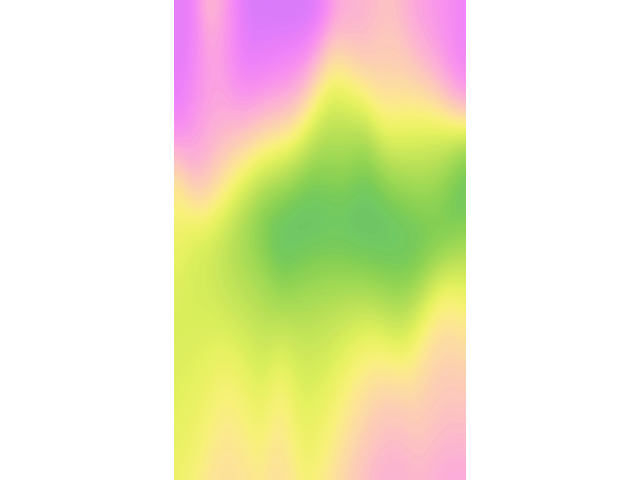

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends